# Run GLMS

In [3]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import shutil
import itertools
import statannot

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter
from scipy import signal

import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf

%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

In [2]:
# useful inbuilt functions/commands

glm1._get_response_fitters().apply(lambda x: x.plot_model_fit())
glm1.plot_groupwise_timecourses()

### PROBLEM
# msit timings not matching, median time to peak does not match possible times in tc for some reason, why? SST is fine.

NameError: name 'glm1' is not defined

In [4]:
def to_psc(x): # calculate percent signal change
    return x / x.mean() * 100 - 100

def load_events_confounds(sub, ses, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
            
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        retroicor_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run_idx}_desc-retroicor_regressors.tsv'
        if not os.path.exists(retroicor_fn):
            ## take first 20 aCompCor components
            print("No retroicor found, including 20 a_comp_cor components")
            a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
#             confounds = pd.concat([confounds, a_comp_cor], axis=1)
        else:
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
            confounds = pd.concat([confounds, retroicor], axis=1)

    return events, confounds

def load_timeseries(atlas_type='MASSP', ses='sstmsit', task='msit'):

    signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/sub-*/ses-{ses}/func/*task-{task}*{atlas_type}-signals.tsv'))

    regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-{ses}_task-{task}_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
    dfs = []
    for signal_fn in signal_fns:
        signals = pd.read_csv(signal_fn, sep='\t')
        gd = regex.match(signal_fn).groupdict()

        if 'time' in signals.columns:
            signals = signals.rename(columns={'time': 'volume'})


        signals = signals.set_index(['volume']).apply(to_psc).reset_index()  # to PSC
        signals['time'] = signals['volume'] * 1.38

        del signals['volume']
        signals['sub'] = gd['sub']
        signals['run'] = int(gd['run'])
        signals = signals.set_index(['sub', 'run', 'time'])
        dfs.append(signals)

    df = pd.concat(dfs)
    
    return df

def sort_data(df, ses, task):
    
    all_events = []
    all_confounds = []

    for sub, run in df.reset_index().set_index(['sub', 'run']).index.unique():
    #     if sub == '010' and run == '2':    # no RETROICOR
    #         continue
        if sub == '007' and run == '1':    # no RETROICOR
            continue
        events, confounds = load_events_confounds(sub, ses, task, run, include_physio=True)
        events['sub'] = sub
        events['run'] = run
        confounds['sub'] = sub
        confounds['run'] = run

        all_events.append(events)
        all_confounds.append(confounds)

    events = pd.concat(all_events).set_index(['sub', 'run'])
    confounds = pd.concat(all_confounds).set_index(['sub', 'run'])

    events = events.rename(columns={'trial_type': 'event_type'})

    events['duration'] = 0.001  # stick function
    if task == 'msit': 
        events.loc[events['event_type']=='timing_feedback','duration'] = 0.4
        
    # make psc
    confounds['global_signal'] = (confounds['global_signal']-confounds['global_signal'].mean())/confounds['global_signal'].std()

    # change subject number ordering
    subs = df.reset_index()['sub'].unique()
    mapping = {y:x+1 for x,y in enumerate(subs)}

    events = events.reset_index()
    events['sub'] = events['sub'].replace(mapping).astype(str)
    events = events.set_index(['sub', 'run'])

    df = df.reset_index()
    df['sub'] = df['sub'].replace(mapping).astype(str)
    df = df.set_index(['sub', 'run', 'time'])

    confounds = confounds.reset_index()
    confounds['sub'] = confounds['sub'].replace(mapping).astype(str)
    confounds = confounds.set_index(['sub', 'run'])

    events.index = events.index.rename('subject', level=0)
    df.index = df.index.rename('subject', level=0)
    confounds.index = confounds.index.rename('subject', level=0)
    
    return events, df, confounds

# # compares timecourse extraction for each extraction method. e.g. nilearn, manual, high passed or not.
# def make_figs(subs, ses, task, params, show_plots=False, overwrite=False):

#     if ses == 'rlsat':
#         runs = [1,2,3]
#     else:    
#         runs = [1,2]

#     # load timeseries all subs for extraction methods
#     df_signals = []
#     for p1, p2, p3, p4 in params:
#         df = load_timeseries(atlas_type=p1, manual_extraction=p2, use_hp_data=p3, ses=ses, task=task)
#         events, df, confounds = sort_data(df, ses, task)
#         df['extraction_method'] = p4
# #         df = df.sort_index() # speeds up index and stops 'impact performance' warning # but it fucks up the ordering
#         df_signals.append(df)

#     df_signals = pd.concat(df_signals).set_index(['extraction_method'],append=True)

#     # loop through structures and make timeseries and correlation matrix
#     for _sub in df_signals.index.unique(level='subject'):
        
#         sub = subs[int(_sub)-1]
#         fn_ext_out = f'../derivatives/extracted_signals_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_signals.pdf'
#         fn_corr_out = f'../derivatives/extracted_signals_plots/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_corr.pdf'
#         if os.path.isfile(fn_ext_out) and not overwrite:
#             print(f'sub {sub} already ran, moving on..')
#             continue
#         os.makedirs(os.path.dirname(fn_ext_out), exist_ok=True)
# #         _sub = sub.lstrip('0')
#         # timeseries
#         pdf = matplotlib.backends.backend_pdf.PdfPages(fn_ext_out)
#         for roi in df_signals.columns:
#             for run in runs:

#                 roi_corr = df_signals.loc[_sub,run,:,'nilearn'].corrwith(df_signals.loc[_sub,run,:,'man_hp'])[roi]
#                 fig = plt.figure(figsize=(40,10))
#                 ax = plt.axes()
#                 ax.set(xlabel='time (s)', ylabel='PSC', title = f'sub {sub} run {run} {roi} timecourse. Corr = {roi_corr}')
#                 for ext in df_signals.index.unique(level='extraction_method'):

#                     x = np.arange(0,len(df_signals.loc[_sub,run,:,ext][roi])*1.38,1.38)
#                     plt.plot(x,df_signals.loc[_sub,run,:,ext][roi], label=ext)

#                 plt.legend(loc='upper right')
#                 pdf.savefig(fig)
#                 if not show_plots:
#                     plt.close()
#         pdf.close()            
#         # correlation matrix of nilearn signals vs manual extraction
#         pdf = matplotlib.backends.backend_pdf.PdfPages(fn_corr_out)
#         corr = pd.concat([df_signals.loc[_sub,:,:,'nilearn'],df_signals.loc[_sub,:,:,'man_hp']], axis=1).corr()
#         fig = plt.figure(figsize=(30,23))
#         sns.heatmap(corr, vmax=1,vmin=-1,
#                 xticklabels=corr.columns,
#                 yticklabels=corr.columns)
#         pdf.savefig(fig)
#         pdf.close()    
#         if not show_plots:
#             plt.close()

#     return 0

# function to plot the deconvolutions 
def plot_deconvs():
    return

# more functions

In [ ]:
def plot_estimated_and_actual_tc(rf,
                                 kernel_pars=kernel_pars,
                                 amplitudes=[5]):
    """
    Plots estimated event-related responses plus the actual underlying
    responses given by kernel_pars and amplitudes
    """
    rf.plot_timecourses(legend=False)
    t = np.linspace(0, 20)

    # Allow for plotting multiple amplitudes
    amplitudes = np.array(amplitudes)
    plt.plot(t,
             double_gamma_with_d(t, **kernel_pars)[:, np.newaxis] * amplitudes,
             label='Actual response',
             ls='--',
             c='k')

    plt.legend()
    plt.suptitle('Estimated event-related response')
    plt.tight_layout()
    
def plot_design_matrix(rf):
    """
    Plots the design matrix of rf in left plot, plus the signal
    it should explain in the right plot.
    Time is in the vertical dimension. Each regressor in X is plotted
    as a seperate line.
    """
    sns.set_style('whitegrid')
    ax = plt.subplot(121)
    rf.plot_design_matrix()

    plt.title('Design matrix')

    plt.subplot(122, sharey=ax)
    plt.plot(rf.input_signal, rf.input_signal.index, c='k')
    plt.title('Measured signal')
    plt.xlabel('Measured signal')

    plt.gcf().set_size_inches(10,15)
    sns.set_style('white')

In [4]:
def make_barplots(df, atlas, task, event, event_types, ttp_med, output_fn, plot_rois, showfig=False):
# def make_barplots(df, atlas, task, event,event_types, ttp_med,  showfig=True):
    
    ttp_med = ttp_med.reset_index() # median time to peak

    output_fn = output_fn.replace('lines/','bars/')
    print(output_fn)
    if not os.path.exists(os.path.dirname(output_fn)):
        os.makedirs(os.path.dirname(output_fn))

    if task == 'msit':
        if event == 'task':
            df = df.loc[df['event type']!='timing_feedback']
            event_types.remove('timing_feedback')
#             event_types = ['con', 'simon', 'flanker', 'inc']
            ttp_med = ttp_med.loc[ttp_med['event type']!='timing_feedback']
        else:
            df.replace({'event type': {'response_ring':'ring','response_middle':'middle','response_index':'index'}},inplace=True)
            event_types = [x.replace('response_', '') for x in event_types]
    elif task == 'sst':
        if event == 'motor':
            df.replace({'event type': {'response_right':'right','response_left':'left'}},inplace=True)
            event_types = [x.replace('response_', '') for x in event_types]

    sns.set_context('talk')
    f, ax = plt.subplots(len(plot_rois),2, figsize=(10,4*len(plot_rois)), sharey='row')
    print(df)
    for i, roi in enumerate(plot_rois):
        for ii, hemi in enumerate(['l', 'r']):
        
            if atlas == 'ATAG':
                this_roi = hemi + roi
            else:
                this_roi = roi + '-' + hemi
                
            if this_roi == 'lIFG':
                continue
                
            ax[i,ii].axhline(0, color='k')
            
            # setup bar chart info
            peaktime = ttp_med[this_roi]

            roi_data = []
            contrast_data = []
            for peak, contrast in zip(peaktime, event_types):
                roi_data.append(df.loc[(df.roi==this_roi) & (df.time==peak) & (df['event type']==contrast), 'signal'])
                contrast_data.append(np.repeat(contrast,len(df.loc[(df.roi==this_roi) & (df.time==peak) & (df['event type']==contrast), 'signal'])))
            
            all_data = pd.concat([pd.DataFrame(flatten(roi_data),columns=['signal']),pd.DataFrame(flatten(contrast_data),columns=['event'])],axis=1)

            # plot
            sns.barplot(x='event',y='signal',data=all_data, ax=ax[i,ii])
            #plot
#             ax[i,ii].bar(event_types, np.array(roi_mean), yerr=np.array(roi_sem), color=['blue','green','red','yellow']) # yerr=np.array(barinfo['sem']),
            ax[i,ii].set_title(this_roi,loc='left')
            ax[i,ii].set_ylim([-0.1, 0.5])
            ax[i,0].set_ylabel('PSC (%)')
            print(list(itertools.combinations(event_types,2)))
            import statannot
            statannot.add_stat_annotation(
                ax=ax[i,ii],
                data=all_data,
                x='event',
                y='signal',
                box_pairs=list(itertools.combinations(event_types,2)),
                test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
                text_format="star",
                loc="outside",
            )
            
    plt.tight_layout()
    sns.despine()
#     f.savefig(output_fn)
    if not showfig:
        plt.close()

def make_barplots_max(df, atlas, task, event, event_types, output_fn, plot_rois, showfig=False):
    
#     output_fn = df.replace('tc_csvs/','bars/').replace('.csv','.pdf')
#     print(output_fn)
#     df = pd.read_csv(df,sep=',')
    
    output_fn = output_fn.replace('lines/','bars/barsmax/')
    print(output_fn)
    if not os.path.exists(os.path.dirname(output_fn)):
            os.makedirs(os.path.dirname(output_fn))
            
    if task == 'msit':
        if event == 'task':
            df = df.loc[df['event type']!='timing_feedback']
            event_types.remove('timing_feedback')
#             event_types = ['con', 'simon', 'flanker', 'inc']
            ttp_med = ttp_med.loc[ttp_med['event type']!='timing_feedback']
        else:
            df.replace({'event type': {'response_ring':'ring','response_middle':'middle','response_index':'index'}},inplace=True)
            event_types = [x.replace('response_', '') for x in event_types]
    elif task == 'sst':
        if event == 'motor':
            df.replace({'event type': {'response_right':'right','response_left':'left'}},inplace=True)
            event_types = [x.replace('response_', '') for x in event_types]
    
    # get max signal for each roi per event type
    barmax = df.groupby(['roi','event type','subject'])['signal'].max().reset_index()#.groupby(['roi','event type'])['signal'].mean().reset_index()

    f, ax = plt.subplots(len(plot_rois),2, figsize=(10,4*len(plot_rois)), sharey='row')

    for i, roi in enumerate(plot_rois):
        for ii, hemi in enumerate(['l', 'r']):
        
            if atlas == 'ATAG':
                this_roi = hemi + roi
            else:
                this_roi = roi + '-' + hemi
                
            if this_roi == 'lIFG':
                continue
                
            ax[i,ii].axhline(0, color='k')
            
#             if roi == 'ACC':
#                 this_roi = 'ACC'
           
#             thisroi = barinfo.loc[barinfo.roi == this_roi]
            this_data = barmax[barmax.roi==this_roi]
            print(this_data)
    
            sns.barplot(x='event type',y='signal',data=this_data, ax=ax[i,ii])
            
#             ax[i,ii].bar(thisroi['event type'], thisroi['signal'], yerr=thisroi['sem'], color=['blue','green','red','yellow'])
            ax[i,ii].set_title(this_roi,loc='left')
            ax[i,ii].set_ylim([0, 0.5])
            ax[i,0].set_ylabel('PSC (%)')
            
            statannot.add_stat_annotation(
                ax=ax[i,ii],
                data=this_data,
                x='event type',
                y='signal',
                box_pairs=list(itertools.combinations(event_types,2)),
                test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
                text_format="star",
                loc="outside",
            )
                
    plt.tight_layout()
    sns.despine()
#     f.savefig(output_fn)
    if not showfig:
        plt.close()


## Define GLM types

In [255]:
# atlas # event type
glms_to_fit = [('THAL', 'task'),
              ('MASSP', 'task'),
              ('ATAG', 'task'),
              ('CORT', 'task'),
              ('THAL', 'motor'),
              ('MASSP', 'motor'),
              ('ATAG', 'motor'),
              ('CORT', 'motor')]

glms_to_fit = [('MASSP', 'task')]

atlas: MASSP, events: task
No retroicor found, including 20 a_comp_cor components
No retroicor found, including 20 a_comp_cor components
No retroicor found, including 20 a_comp_cor components


/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:549: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.linspace(0, len(df.loc[ix]) * TR, len(d), endpoint=False)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:549: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.linspace(0, len(df.loc[ix]) * TR, len(d), endpoint=False)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/py38/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat exce

Problem with responsefitter 36: Design matrix is singular. Consider using less regressors, basis functions, or try ridge regression.
../derivatives/extracted_signals_plots/groupwise_glms/ses-sstmsit/bars/canonical_hrf/groupwisetimecourses_ses-sstmsit_task-sst_atlas-MASSP_events-task.pdf
       subject event type  covariate    time   roi        signal hemisphere  \
0            1         fs  intercept   0.000    3V  0.000000e+00         lr   
1            1         fs  intercept   0.069    3V -5.001490e-10         lr   
2            1         fs  intercept   0.138    3V -2.964719e-08         lr   
3            1         fs  intercept   0.207    3V -3.127772e-07         lr   
4            1         fs  intercept   0.276    3V -1.627690e-06         lr   
...        ...        ...        ...     ...   ...           ...        ...   
894655       9         go  intercept  17.595  ic-r -3.111751e-03          r   
894656       9         go  intercept  17.664  ic-r -3.022433e-03          r   
8

fs v.s. go: t-test paired samples with Bonferroni correction, P_val=3.762e-04 stat=4.298e+00
[('fs', 'ss'), ('fs', 'go'), ('ss', 'go')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fs v.s. ss: t-test paired samples with Bonferroni correction, P_val=9.218e-02 stat=2.249e+00
ss v.s. go: t-test paired samples with Bonferroni correction, P_val=3.436e-01 stat=-1.617e+00
fs v.s. go: t-test paired samples with Bonferroni correction, P_val=2.993e-01 stat=1.689e+00
[('fs', 'ss'), ('fs', 'go'), ('ss', 'go')]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fs v.s. ss: t-test paired samples with Bonferroni correction, P_val=5.737e-01 stat=1.332e+00
ss v.s. go: t-test paired samples with Bonferroni correction, P_val=4.017e-01 stat=-1.533e+00
fs v.s. go: t-test paired 

go v.s. ss: t-test paired samples with Bonferroni correction, P_val=1.417e-01 stat=2.054e+00
fs v.s. ss: t-test paired samples with Bonferroni correction, P_val=3.573e-06 stat=5.825e+00
       roi event type subject    signal
1887  RN-r         fs       1  0.196089
1888  RN-r         fs      10  0.030634
1889  RN-r         fs      11  0.210607
1890  RN-r         fs      12  0.273483
1891  RN-r         fs      13  0.343859
...    ...        ...     ...       ...
1993  RN-r         ss       5  0.555121
1994  RN-r         ss       6  0.118260
1995  RN-r         ss       7  0.001929
1996  RN-r         ss       8  0.115138
1997  RN-r         ss       9  0.119483

[111 rows x 4 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fs v.s. go: t-test paired samples with Bonferroni correction, P_val=5.467e-05 stat=4.937e+00
go v.s. ss: t-test paired samples with Bonferroni cor

go v.s. ss: t-test paired samples with Bonferroni correction, P_val=7.327e-01 stat=1.184e+00
fs v.s. ss: t-test paired samples with Bonferroni correction, P_val=1.321e-03 stat=3.870e+00
        roi event type subject    signal
2442  Str-l         fs       1  0.014551
2443  Str-l         fs      10  0.150767
2444  Str-l         fs      11  0.018492
2445  Str-l         fs      12  0.006670
2446  Str-l         fs      13  0.185635
...     ...        ...     ...       ...
2548  Str-l         ss       5  0.009407
2549  Str-l         ss       6  0.176940
2550  Str-l         ss       7  0.025563
2551  Str-l         ss       8  0.171454
2552  Str-l         ss       9  0.029208

[111 rows x 4 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

fs v.s. go: t-test paired samples with Bonferroni correction, P_val=3.220e-02 stat=2.691e+00
go v.s. ss: t-test paired samples with Bo

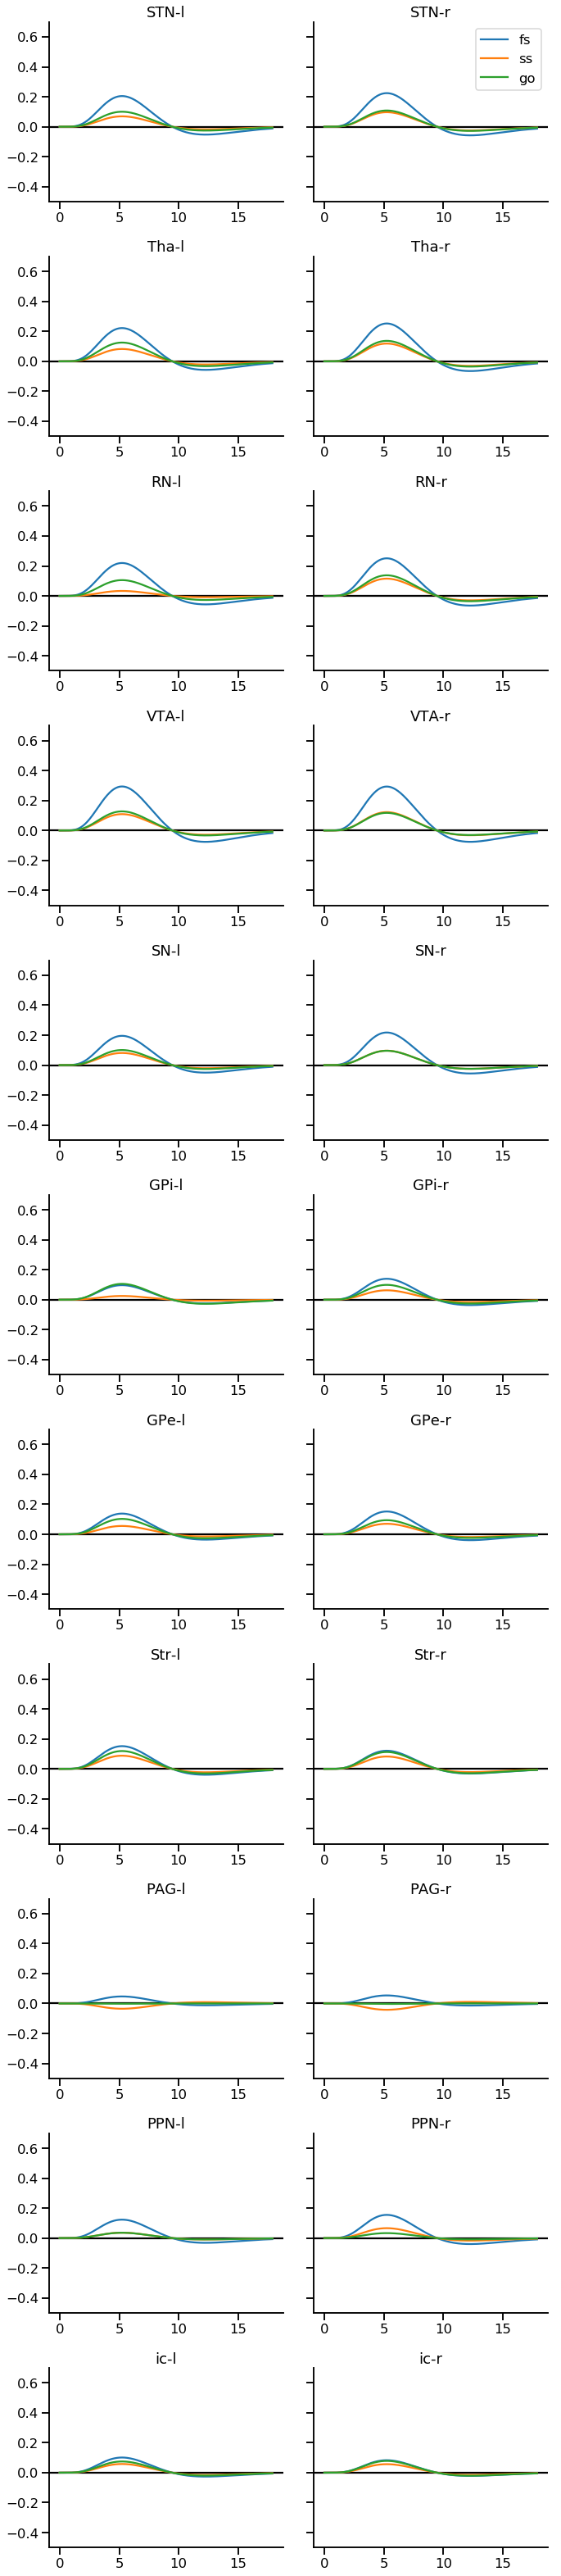

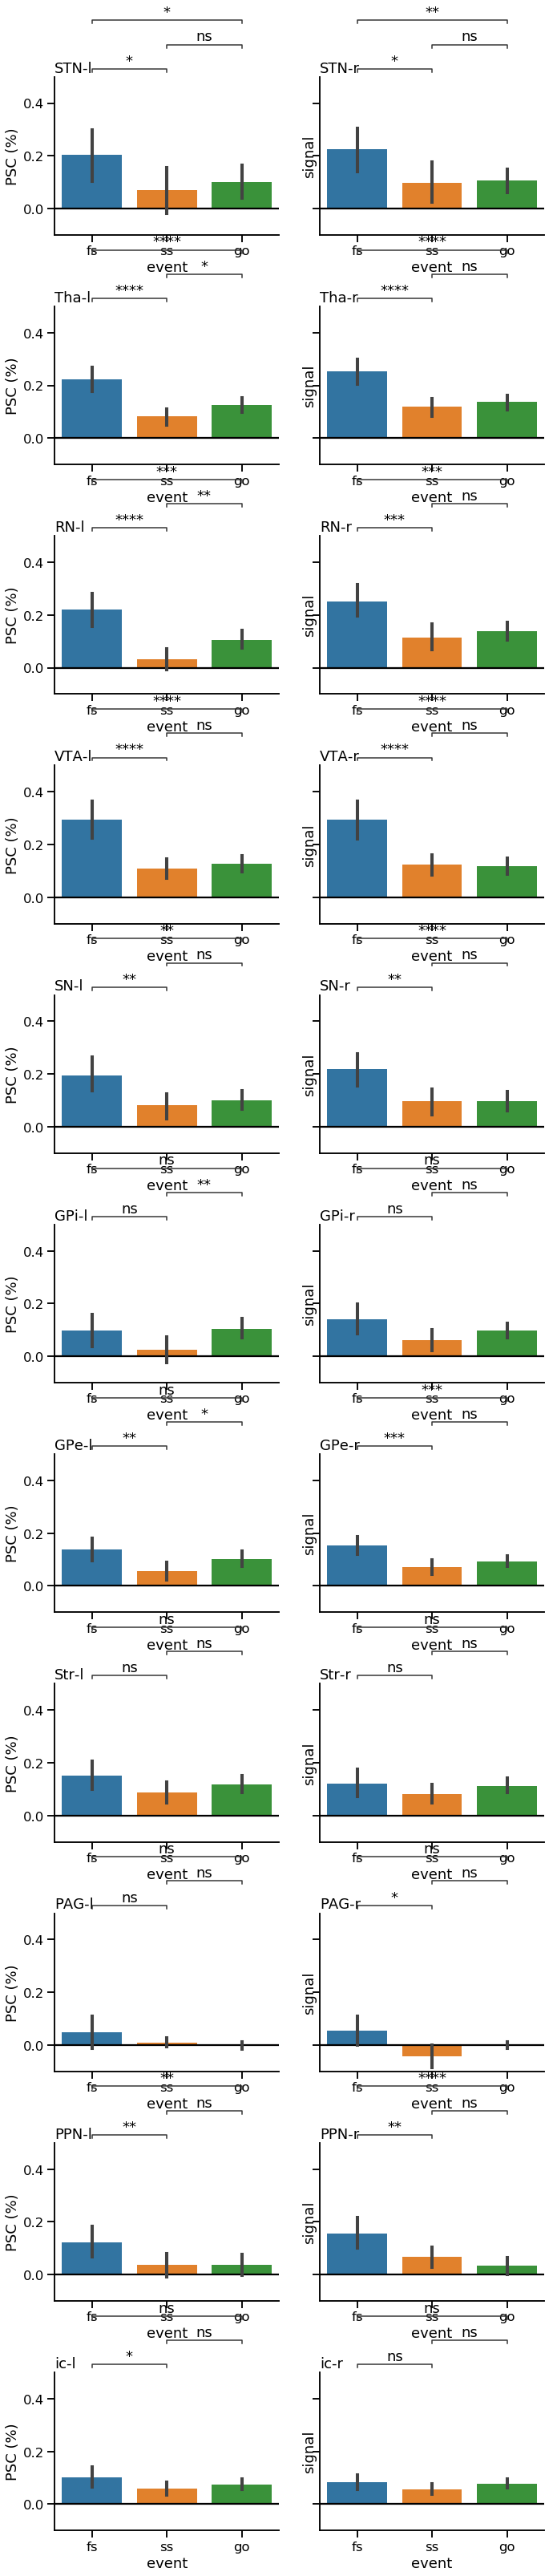

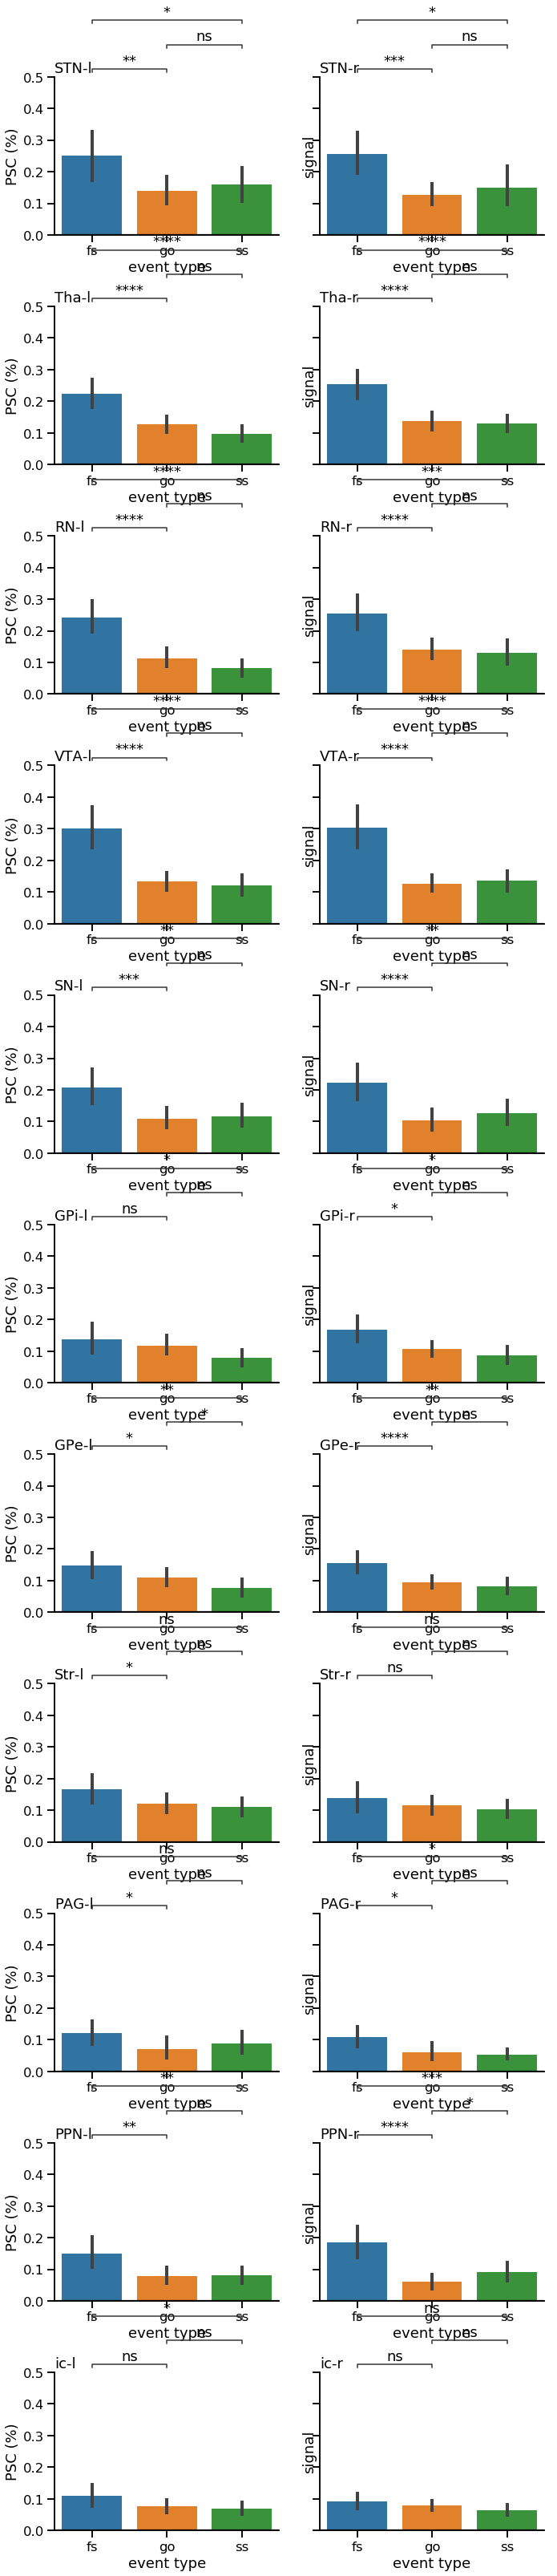

In [6]:
##### #DEFINE SESSION AND TASK HEREE
show_plots = True
ses = 'sstmsit'
tasks = ['sst','msit']
tasks = ['sst']
save_csvs = False
# basis_set = 'fourier' 
# basis_set = 'canonical_hrf_with_time_derivative'
basis_set = 'canonical_hrf'
# basis_set = 'fir'

for task in tasks:
    for p1, p2 in glms_to_fit:

        if task == 'msit':
            response_types = ['response_index', 'response_middle', 'response_ring']
            contrast_types = ['con', 'simon', 'flanker', 'inc', 'timing_feedback']
        elif task == 'sst':
            response_types = ['response_left','response_right']
            contrast_types = ['fs','ss','go']

        df = events = events_1 = df = confounds = glm1 = []
        if p2 == 'task':
            event_types = contrast_types
        elif p2 == 'motor':
            event_types = response_types

        print(f'atlas: {p1}, events: {p2}')
        # load confounds, events, timeseries and sort
        df = load_timeseries(atlas_type=p1, ses=ses, task=task)
    #     print(df)
    #     df = df[df['subject']!='025']
        events, df, confounds = sort_data(df,ses,task)
        df.dropna(inplace=True) # replace nas with 0s? Check why there are NaNs

        events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), event_types),:] 
        events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
        events_1.onset -= 1.38/2  # stc

        # na values in dataframe will cause 'SVD did not converge in Linear Least Squares' error
        glm1 = GroupResponseFitter(df,
                                   events_1, 
                                   confounds=confounds.copy().reset_index(),
                                   input_sample_rate=1/1.38, 
                                   oversample_design_matrix=20, 
                                   concatenate_runs=True)

        for event_type in event_types:
            if basis_set == 'fourier':
                glm1.add_event(event_type, basis_set=basis_set, n_regressors=9, interval=[0, 18])
            elif (basis_set == 'canonical_hrf_with_time_derivative') or (basis_set == 'canonical_hrf'):
                glm1.add_event(event_type, basis_set=basis_set, interval=[0, 18])
            elif basis_set == 'fir':
                glm1.add_event(event_type, basis_set=basis_set, n_regressors=20, interval=[0, 18])

        glm1.fit()
        #     glm1.plot_groupwise_timecourses()

#         tc = glm1.get_subjectwise_timecourses()
        tc = glm1.get_timecourses()
#         print(tc)
        tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
        tc['hemisphere'] = tc['roi'].str.split('-').apply(lambda x: x[-1])
        tc['roi_nohemi'] = tc['roi'].str.split('-').apply(lambda x: x[0])
        tc.loc[~tc.hemisphere.isin(['l', 'r']), 'hemisphere'] = 'lr'

        if save_csvs:
            if not os.path.exists(os.path.dirname(output_csv := f"../derivatives/extracted_signals_plots/groupwise_glms/ses-{ses}/tc_csvs/groupwisetimecourses_{basis_set}_ses-{ses}_task-{task}_atlas-{p1}_events-{p2}.csv")):
                os.mkdir(os.path.dirname(output_csv))
            tc.to_csv(output_csv)

        ## LOOK AT TIME TO PEAK ##
        ttp = glm1._get_response_fitters().apply(lambda x: x.get_time_to_peak())
        ttp_med = pd.concat(ttp.values.tolist()).groupby(level=0).median()
#         print(ttp_med)

        ### PLOT DAT SHIT ###
        sns.set_context('talk')

        if p1 == 'THAL':
            plot_rois = ['AV', 'CeM', 'CL', 'CM', 'LD', 'LGN', 'LP', 'LSg', 'MDl', 'MDm', 'MGN', 'MV',\
                         'Pc', 'Pf', 'Pt', 'PuA', 'PuI', 'PuL', 'PuM', 'R', 'VA', 'VAmc', 'VLa', 'VLp',\
                         'VM', 'VPL', 'PaV']
        elif p1 == 'MASSP':
            plot_rois = ['STN', 'Tha', 'RN', 'VTA', 'SN', 'GPi', 'GPe', 'Str', 'PAG', 'PPN', 'ic']
        elif p1 == 'ATAG':
            plot_rois = [ 'M1', 'PreSMA', 'IFG'] #'ACC',
        elif p1 == 'CORT':
            plot_rois = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']

        f, ax = plt.subplots(len(plot_rois),2, figsize=(10,4*len(plot_rois)), sharey='row')

        for i, roi in enumerate(plot_rois):
            for ii, hemi in enumerate(['l', 'r']):
                if p1 == 'ATAG':
                    this_roi = hemi + roi
                else:
                    this_roi = roi + '-' + hemi
                ax[i,ii].axhline(0, color='k')
                if this_roi not in tc.roi.unique() and not roi == 'ACC':
                    continue
                if this_roi == 'lIFG':
                    continue
#                 if roi == 'ACC':
#                     this_roi = 'ACC'
                for contrast in event_types:
#                     print(roi)
#                     print(this_roi)
                    tc_subs = tc.loc[(tc['event type'] == contrast)] # & (tc['covariate'] == 'covariate')]        
                    group_mean = tc_subs.loc[tc_subs['roi'] == this_roi].groupby(['time'])['signal'].mean()
        #             sns.lineplot(x='time', y='signal', data=tc_subs, ax=ax[i,ii], label=contrast)
                    ax[i,ii].plot(group_mean, label=contrast, )
                    ax[i,ii].set_title(this_roi)
                    ax[i,ii].set_ylim([-0.5, 0.7])

        ax[0,1].legend()
        plt.tight_layout()
        sns.despine()

        output_fn = f"../derivatives/extracted_signals_plots/groupwise_glms/ses-{ses}/lines/{basis_set}/groupwisetimecourses_ses-{ses}_task-{task}_atlas-{p1}_events-{p2}.pdf"
        if not os.path.exists(os.path.dirname(output_fn)):
            os.makedirs(os.path.dirname(output_fn))
#         f.savefig(output_fn)
        if not show_plots:
            plt.close()
        
        # make barcharts for easier comparison (median time to peak)
        make_barplots(tc, p1, task, p2, event_types, ttp_med, output_fn, plot_rois, show_plots)
        
        # Same but with max signal change
        make_barplots_max(tc, p1, task, p2, event_types, output_fn, plot_rois, show_plots)
        

# NEW GLM METHOD

## load timeseries

separate motor and event glms due to differenes in trial types that have responses

Regions of interest (SST):

rIFG
ACC
M1
SMA
PaCG
Ins
GPe
GPi
RN
SN
STN
STR
Tha
VTA



In [25]:
# collect together all regions of interest for each sub.
subs = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob('../derivatives/extracted_signals/sub-*/ses-sstmsit'))]

# remove subs that did not do task correctly
# ['004', '010', '008', '019', '013', '027']

to_remove = ['004', '010', '008', '019', '013', '027']
subs = [x for x in subs if x not in to_remove]
print(len(subs)) # should be 31

# subs = ['002']
runs = [1,2]
tasks = ['sst','msit']
for sub in subs:
#     print(sub)
    for run in runs:
#         print(run)
        for task in tasks:
            all_sigs = []#pd.DataFrame()
            signals = sorted(glob.glob(f'../derivatives/extracted_signals/sub-{sub}/ses-sstmsit/func/*task-{task}_run-{run}*_hp.tsv'))
#             print(signals)
            if signals == []:
                print(f'no data for sub {sub} run {run} task {task}')
                continue
            signals = [x for x in signals if 'ALL' not in x]
            for index, sig in enumerate(signals):
                if index == 0:
                    all_sigs = pd.read_csv(sig, sep='\t')
                else:
                    all_sigs = pd.concat([all_sigs, pd.read_csv(sig, sep='\t')],axis=1)
            
            all_sigs = all_sigs.loc[:,~all_sigs.columns.duplicated()]
            save_name = f'../derivatives/extracted_signals/sub-{sub}/ses-sstmsit/func/sub-{sub}_ses-sstmsit_task-{task}_run-{run}_desc-ALL-signals_hp.tsv'
            all_sigs.to_csv(save_name, '\t')
#             all_sigs.to_csv(sig.replace('THAL','ALL'),'\t')

31
no data for sub 040 run 2 task sst


In [6]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [8]:
## Load timeseries
atlas_type = 'ALL'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/sub-*/ses-sstmsit/func/*task-sst*{atlas_type}*s.tsv'))
signal_fns = [x for x in signal_fns if not any(s in x for s in to_remove)] # remove subs that didnt do task right
signal_fns

filter_out_confounds = True
filter_hp = False # already highpassed so no need

# excluded_runs = [('009', '2'), #] #,  # fell asleep
#                  ('010', '2'),  # physio failed   # TODO: find a better solution here!
#                  ('010', '3'),  # physio failed   # TODO: find a better solution here!
#                  ('018', '3')]  # physio failed   # TODO: find a better solution here!

excluded_runs=[('018','2'),
               ('025','2'),
               ('041','1')]

regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-sstmsit_task-sst_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
dfs = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t')
    gd = regex.match(signal_fn).groupdict()
    if tuple(gd.values()) in excluded_runs:
        # run was excluded
        continue
    
    if 'time' in signals.columns:
        # if there's a column named 'time', it's called 'time' but it's really volume number..
        signals = signals.rename(columns={'time': 'volume'})
    signals = signals.set_index('volume')
    
    # psc?
    signals = signals.apply(to_psc)  # to PSC

    # filter out confounds?
    if filter_out_confounds:
        _, confounds = load_events_confounds(sub=gd['sub'], ses='sstmsit', task='sst', run=gd['run'])
        confounds['intercept'] = 1   # add intercept!
        betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
        signals_hat = confounds@betas
        signals_hat.index = signals.index
        signals_hat.columns = signals.columns
        signals -= signals_hat   # residuals
        
    # high pass?
    if filter_hp:
        signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/1.38) + x.mean(), axis=0)
    
    # index to time
    signals.index *= 1.38
    signals.index.name = 'time'
    signals['subject'] = gd['sub']
    signals['run'] = int(gd['run'])
        
    signals = signals.reset_index().set_index(['subject', 'run', 'time'])
    dfs.append(signals)
df = pd.concat(dfs)
df = df.reindex(sorted(df.columns), axis=1)

if atlas_type == 'ALL':
    df.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r'}, inplace = True)
#     rois_ = sorted(['IFG-l','IFG-r','ACC-l','ACC-r','M1-l','M1-r','SMA-l','SMA-r','PaCG-l','PaCG-r','Ins-l','Ins-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r'])
    rois_ = ['ACC-l','ACC-r','IFG-l','IFG-r','Ins-l','Ins-r','M1-l','M1-r','pSG-l','pSG-r','SMA-l','SMA-r','SPL-l','SPL-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
             'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r']
    df = df[rois_]

df.head()

/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/2973594666.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

ACC-l     ACC-r     IFG-l     IFG-r     Ins-l     Ins-r  \
subject run time                                                               
002     1   0.00  0.374160  0.177822  0.262316 -0.058006  0.184830  0.568623   
            1.38  0.368671  0.248547  0.405352  0.102498  0.285135  0.214363   
            2.76  0.510332  0.417739 -0.110007 -0.183045  0.238301  0.172377   
            4.14  0.389120  0.303594 -0.308760 -0.358613  0.232946 -0.181857   
            5.52  0.361418  0.194356 -0.431446 -0.204146  0.346629 -0.088537   

                      M1-l      M1-r     pSG-l     pSG-r  ...      SN-l  \
subject run time                                          ...             
002     1   0.00  0.206835  0.149331  0.416789 -0.203505  ...  0.199977   
            1.38  0.008457  0.308299  0.234576 -0.228502  ...  0.772542   
            2.76 -0.091687  0.101022 -0.118246 -0.281262  ...  0.384238   
            4.14  0.144288  0.267617 -0.256040 -0.233484  ...  0.148792   
            5.52  0.091646  0.153756 -0.498228 -0.130709  ...  0.176411   

                      SN-r     STN-l     STN-r     Str-l     Str-r     Tha-l  \
subject run time                                                               
002     1   0.00  0.227746  1.714680  1.540075  0.204995  0.101008  0.647607   
            1.38  0.243136  1.468235 -0.390961  0.312742  0.186889  0.300038   
            2.76  0.164809  1.850881  0.542196  0.473773  0.338157  0.481000   
            4.14  0.818612  1.664914  0.154030  0.285369  0.072984  0.513155   
            5.52  0.283206  0.902682  1.111446  0.265716 -0.029815  0.181131   

                     Tha-r     VTA-l     VTA-r  
subject run time                                
002     1   0.00  0.569787  0.693748  0.705350  
            1.38  0.398782 -0.022411  0.571891  
            2.76  0.621768 -0.255762  0.149775  
            4.14  0.577290  0.048924  0.379827  
            5.52  0.436257  0.218501  0.328100  

[5 rows x 30 columns]

## load event, confounds

In [9]:
model_n = 'all_events'
all_events = []
all_confounds = []

for sub, run in df.reset_index().set_index(['subject', 'run']).index.unique():
    events, confounds = load_events_confounds(sub, 'sstmsit', 'sst', run, include_physio=True)
    events['subject'] = sub
    events['run'] = run
    confounds['subject'] = sub
    confounds['run'] = run
    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['subject', 'run'])
confounds = pd.concat(all_confounds).set_index(['subject', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})

events['duration'] = 0.001  # stick function

## glm function

In [10]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=1.38, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
#         if event_type in ['stimulus_value_difference', 'feedback_PE']:
#             glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
#         else:
        glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 19.32])

    glm1.fit(type=fit_type)
    return glm1

# fit event glm

In [11]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
    #     gm_nuclei = sorted(['IFG','ACC','M1','SMA','PaCG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'])
    gm_nuclei = ['ACC','IFG','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_events = ['fs','ss','go']
glm1 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/hom

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:228: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, rf in bar(self.response_fitters.iteritems()):


## fit motor glm

In [12]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
#     gm_nuclei = sorted(['IFG','ACC','M1','SMA','PaCG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'])
    gm_nuclei = ['ACC','IFG','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_events = ['response_left','response_right']
glm_m = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/hom

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/hom

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

## plotting

In [13]:
import copy

glm1_ar1 = copy.deepcopy(glm1)

tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

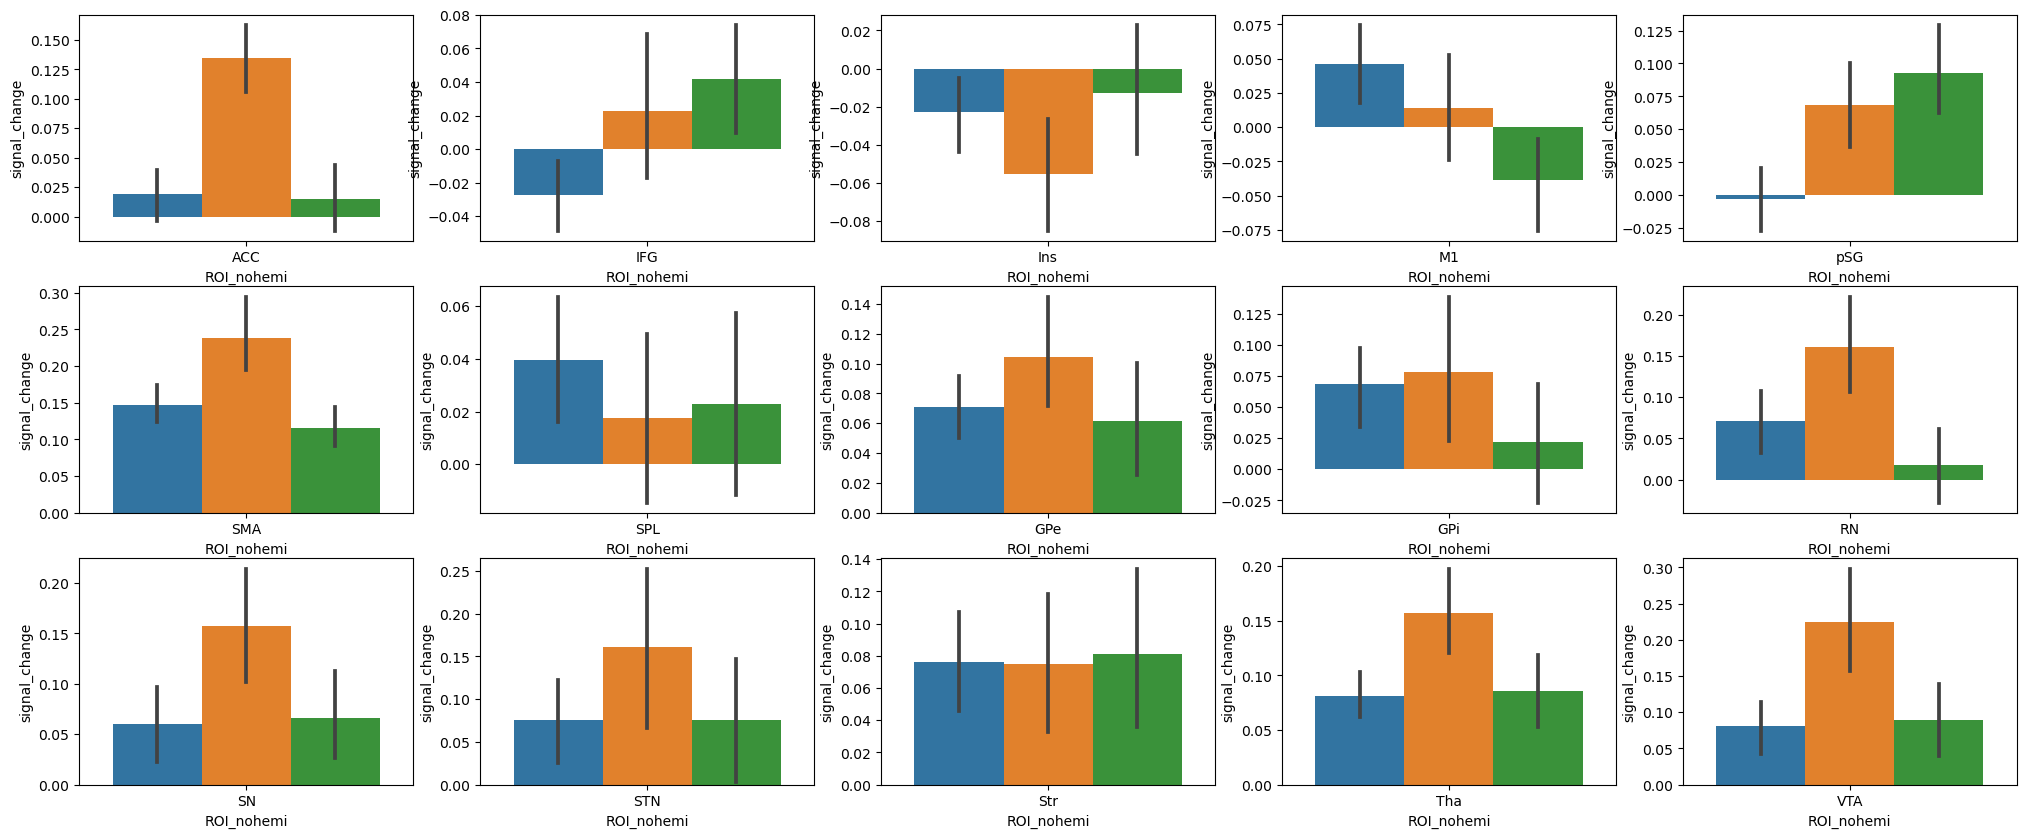

In [14]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, axes = plt.subplots(3,5,figsize=(25,10))

# for i, ax in zip(range(10), axes.flat):
#     sns.barplot(data[i,0,0,0], hist=False, ax=ax)
# plt.show()

ax = axes.ravel()


for i, r in enumerate(gm_nuclei):
    sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
                data=contrast_betas.loc[(contrast_betas.hemisphere=='l') & (contrast_betas.ROI_nohemi==r)], ax=ax[i])
    ax[i].legend_.remove()

# box_pairs = []
# for index in contrast_betas['ROI_nohemi'].unique():
#     box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'go', 'fs', 'ss'],2))[:3],2)))
    
# # box_pairs = box_pairs[:1]
# statannot.add_stat_annotation(
#     ax,
#     data=contrast_betas, 
#     x='ROI_nohemi',
#     y='signal_change',
#     hue='event type',
# #     hue_order=['go','fs','ss'],
#     box_pairs=box_pairs,
#     test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
#     text_format="star",
#     loc="inside",
# #     text_offset=-0.5,
# #     line_offset_to_box=-0.5,
# #     line_offset=-0.5,
# #     use_fixed_offset=True
# #     line_height=1
# )

# ax.set_ylabel('% change')
# ax.set_xlabel('ROI')



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IFG_fs v.s. IFG_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.884e-01
Ins_go v.s. Ins_fs: t-test paired samples with Bonferroni correction, P_val=1.152e-01 stat=-3.155e+00
Ins_fs v.s. Ins_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.379e+00
M1_go v.s. M1_fs: t-test paired samples with Bonferroni correction, P_val=9.978e-02 stat=3.204e+00
M1_fs v.s. M1_ss: t-test paired samples with Bonferroni correction, P_val=2.942e-04 stat=4.967e+00
pSG_go v.s. pSG_fs: t-test paired samples with Bonferroni correction, P_val=1.401e-07 stat=-7.006e+00
pSG_fs v.s. pSG_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.229e+00
SMA_go v.s. SMA_fs: t-test paired samples with Bonferroni correction, P_val=8.012e-07 stat=-6.550e+00
SMA_fs v.s. SMA_ss: t-test p

Text(0.5, 80.7222222222222, 'ROI')

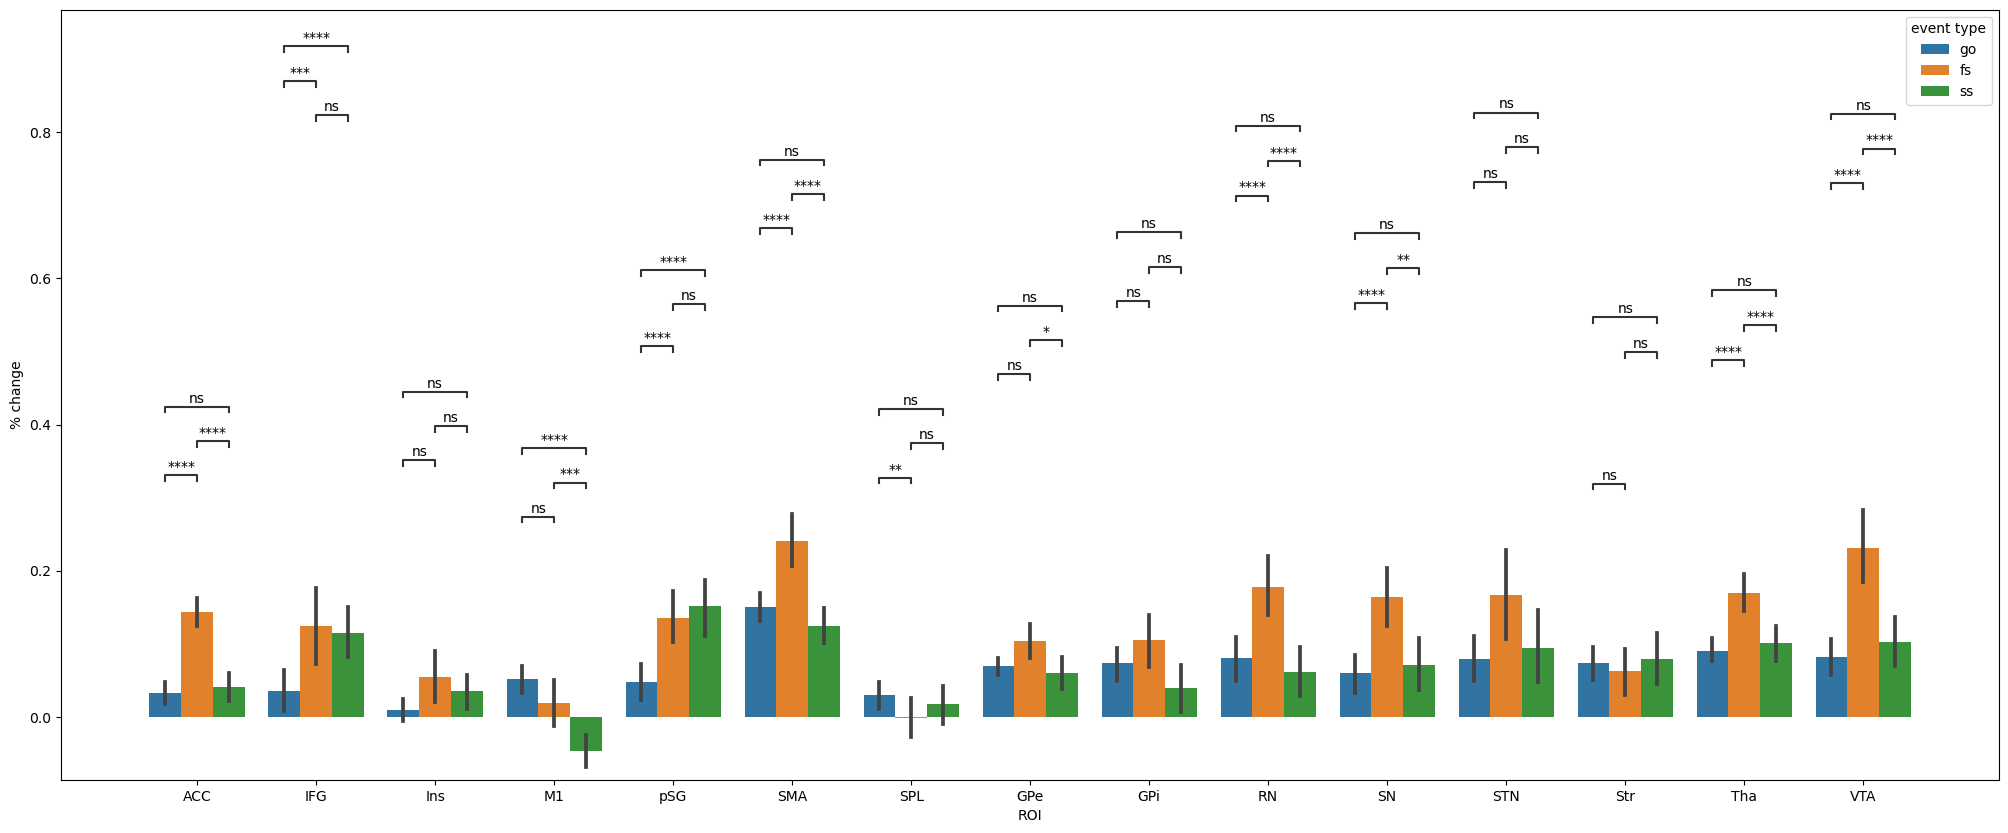

In [15]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(25,10))
sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)

box_pairs = []
for index in contrast_betas['ROI_nohemi'].unique():
    box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'go', 'fs', 'ss'],2))[:3],2)))
    
# box_pairs = box_pairs[:1]
statannot.add_stat_annotation(
    ax,
    data=contrast_betas, 
    x='ROI_nohemi',
    y='signal_change',
    hue='event type',
#     hue_order=['go','fs','ss'],
    box_pairs=box_pairs,
    test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
    text_format="star",
    loc="inside",
#     text_offset=-0.5,
#     line_offset_to_box=-0.5,
#     line_offset=-0.5,
#     use_fixed_offset=True
#     line_height=1
)

ax.set_ylabel('% change')
ax.set_xlabel('ROI')



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pSG-r_response_left v.s. pSG-r_response_right: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.970e-01
SMA-l_response_left v.s. SMA-l_response_right: t-test paired samples with Bonferroni correction, P_val=7.883e-02 stat=-3.302e+00
SMA-r_response_left v.s. SMA-r_response_right: t-test paired samples with Bonferroni correction, P_val=6.833e-03 stat=4.227e+00
SPL-l_response_left v.s. SPL-l_response_right: t-test paired samples with Bonferroni correction, P_val=5.734e-05 stat=-5.984e+00
SPL-r_response_left v.s. SPL-r_response_right: t-test paired samples with Bonferroni correction, P_val=8.448e-08 stat=8.534e+00
GPe-l_response_left v.s. GPe-l_response_right: t-test paired samples with Bonferroni correction, P_val=1.050e-01 stat=-3.189e+00
GPe-r_response_left v.s. GPe-r_response_right: t-test paired samp

Text(0.5, 80.7222222222222, 'ROI')

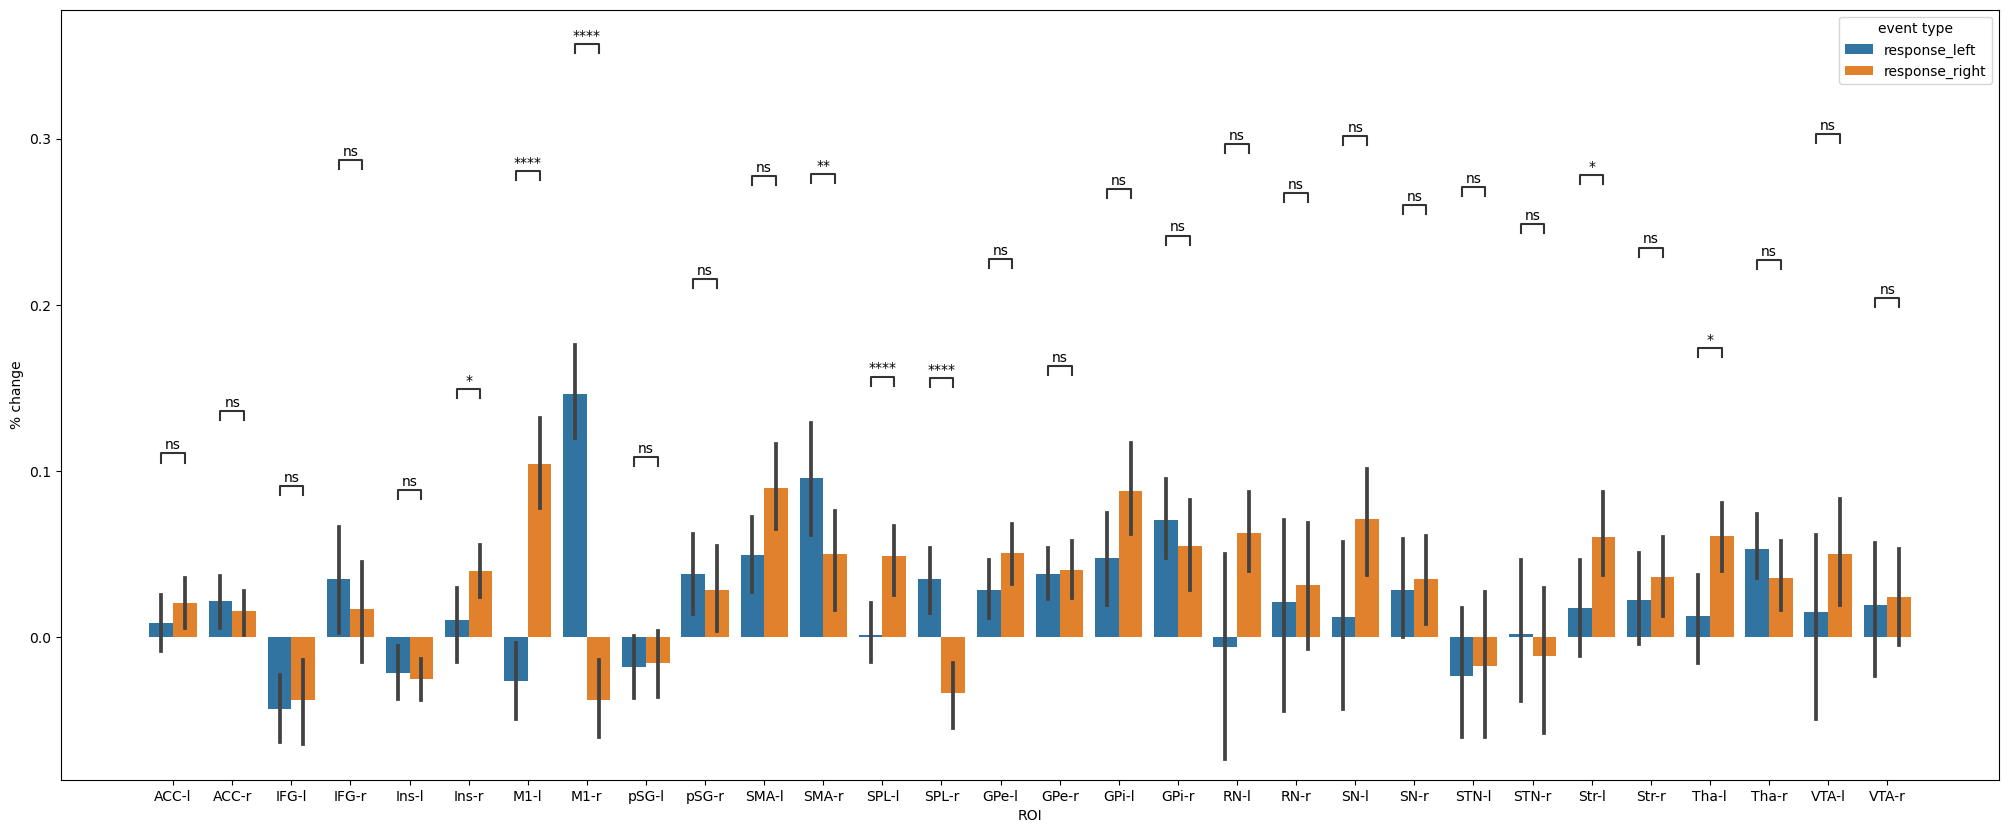

In [16]:
all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left','response_right'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(25,10))
sns.barplot(x='ROI', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)

box_pairs = []
for index in contrast_betas['ROI'].unique():
    box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'response_left','response_right'],2))[:2],2)))
    
# box_pairs = box_pairs[:1]
# print(box_pairs)
statannot.add_stat_annotation(
    ax,
    data=contrast_betas, 
    x='ROI',
    y='signal_change',
    hue='event type',
#     hue_order=['go','fs','ss'],
    box_pairs=box_pairs,
    test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
    text_format="star",
    loc="inside",
#     text_offset=-0.5,
#     line_offset_to_box=-0.5,
#     line_offset=-0.5,
#     use_fixed_offset=True
#     line_height=1
)

ax.set_ylabel('% change')
ax.set_xlabel('ROI')



In [17]:
# motor
all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left', ignore_index=False)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1
contrast_betas_motor = contrast_betas.copy()

## event glms
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe

# fs - go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - go
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsgo = contrast_betas.copy()

# ss - fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - ss
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsss = contrast_betas.copy()

# go - ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference ss - go
contrast_betas = contrast_betas.xs('ss',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_ssgo = contrast_betas.copy()

##########
###########
###########
# now look just at absolute activtions with trial types
############

# fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline fs
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_fs = contrast_betas.copy()

# ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline ss
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_ss = contrast_betas.copy()

# go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline go
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_go = contrast_betas.copy()

# look at significance

In [18]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# absolute activation

In [19]:
tmp = betas_fs.groupby('ROI')['beta_fs'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fs = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_ss.groupby('ROI')['beta_ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_go.groupby('ROI')['beta_go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_go = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fs, stat_ss, stat_go = stat_fs.reindex(rois_), stat_ss.reindex(rois_), stat_go.reindex(rois_)

In [20]:
display_side_by_side(stat_fs,stat_ss,stat_go, titles=['fs','ss','go'])

fs 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 9.328052 
 4.368143e-10 
 True 
 0.0 
 *** 
 
 
 ACC-r 
 10.157065 
 6.815427e-11 
 True 
 0.0 
 *** 
 
 
 IFG-l 
 0.967601 
 3.415278e-01 
 False 
 0.353305 
 
 
 
 IFG-r 
 6.096399 
 1.412534e-06 
 True 
 0.000003 
 *** 
 
 
 Ins-l 
 -3.583913 
 1.266513e-03 
 True 
 0.001809 
 ** 
 
 
 Ins-r 
 9.954333 
 1.064715e-10 
 True 
 0.0 
 *** 
 
 
 M1-l 
 0.693907 
 4.934578e-01 
 False 
 0.493458 
 
 
 
 M1-r 
 1.078258 
 2.901204e-01 
 False 
 0.334754 
 
 
 
 pSG-l 
 4.288102 
 1.932335e-04 
 True 
 0.00029 
 *** 
 
 
 pSG-r 
 7.405127 
 4.592955e-08 
 True 
 0.0 
 *** 
 
 
 SMA-l 
 9.645277 
 2.123241e-10 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 9.392672 
 3.767153e-10 
 True 
 0.0 
 *** 
 
 
 SPL-l 
 1.037057 
 3.085827e-01 
 False 
 0.34287 
 
 
 
 SPL-r 
 -1.006178 
 3.229465e-01 
 False 
 0.346014 
 
 
 
 GPe-l 
 5.661953 
 4.562126e-06 
 True 
 0.000009 
 *** 
 
 
 GPe-r 
 6.893942 
 1.712859e-07 
 True 
 0.000001 
 *** 
 
 
 GPi-l 
 2.561138 
 1.610948e-02 
 True 
 0.020137 
 * 
 
 
 GPi-r 
 6.069616 
 1.517799e-06 
 True 
 0.000003 
 *** 
 
 
 RN-l 
 5.406279 
 9.143965e-06 
 True 
 0.000016 
 *** 
 
 
 RN-r 
 6.649045 
 3.251862e-07 
 True 
 0.000001 
 *** 
 
 
 SN-l 
 5.312447 
 1.181034e-05 
 True 
 0.00002 
 *** 
 
 
 SN-r 
 5.858590 
 2.679176e-06 
 True 
 0.000005 
 *** 
 
 
 STN-l 
 3.221846 
 3.221795e-03 
 True 
 0.004202 
 ** 
 
 
 STN-r 
 4.647903 
 7.259612e-05 
 True 
 0.000115 
 *** 
 
 
 Str-l 
 3.348480 
 2.332085e-03 
 True 
 0.00318 
 ** 
 
 
 Str-r 
 2.164587 
 3.909721e-02 
 True 
 0.046917 
 * 
 
 
 Tha-l 
 7.845474 
 1.516102e-08 
 True 
 0.0 
 *** 
 
 
 Tha-r 
 10.019662 
 9.216230e-11 
 True 
 0.0 
 *** 
 
 
 VTA-l 
 6.136382 
 1.268960e-06 
 True 
 0.000003 
 *** 
 
 
 VTA-r 
 6.898929 
 1.690760e-07 
 True 
 0.000001 
 *** 
 
 
 ss 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 1.070460 
 2.935534e-01 
 False 
 0.338716 
 
 
 
 ACC-r 
 5.207020 
 1.574944e-05 
 True 
 0.000067 
 *** 
 
 
 IFG-l 
 2.463967 
 2.014531e-02 
 True 
 0.027471 
 * 
 
 
 IFG-r 
 8.741215 
 1.717946e-09 
 True 
 0.0 
 *** 
 
 
 Ins-l 
 -0.761119 
 4.529491e-01 
 False 
 0.468568 
 
 
 
 Ins-r 
 6.347390 
 7.223813e-07 
 True 
 0.000004 
 *** 
 
 
 M1-l 
 -2.275691 
 3.071402e-02 
 True 
 0.040062 
 * 
 
 
 M1-r 
 -3.244706 
 3.040107e-03 
 True 
 0.005868 
 ** 
 
 
 pSG-l 
 5.160352 
 1.789103e-05 
 True 
 0.000067 
 *** 
 
 
 pSG-r 
 7.028985 
 1.206222e-07 
 True 
 0.000001 
 *** 
 
 
 SMA-l 
 8.426238 
 3.650525e-09 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 6.563536 
 4.073722e-07 
 True 
 0.000002 
 *** 
 
 
 SPL-l 
 1.334750 
 1.927107e-01 
 False 
 0.231253 
 
 
 
 SPL-r 
 0.572200 
 5.717527e-01 
 False 
 0.571753 
 
 
 
 GPe-l 
 3.233256 
 3.129845e-03 
 True 
 0.005868 
 ** 
 
 
 GPe-r 
 3.839163 
 6.456902e-04 
 True 
 0.001614 
 ** 
 
 
 GPi-l 
 0.866732 
 3.934559e-01 
 False 
 0.437173 
 
 
 
 GPi-r 
 2.725616 
 1.094129e-02 
 True 
 0.016412 
 * 
 
 
 RN-l 
 0.774957 
 4.448609e-01 
 False 
 0.468568 
 
 
 
 RN-r 
 4.321455 
 1.765286e-04 
 True 
 0.000481 
 *** 
 
 
 SN-l 
 2.864983 
 7.822825e-03 
 True 
 0.012352 
 * 
 
 
 SN-r 
 2.658286 
 1.283461e-02 
 True 
 0.018335 
 * 
 
 
 STN-l 
 2.161758 
 3.933516e-02 
 True 
 0.049169 
 * 
 
 
 STN-r 
 3.026921 
 5.254889e-03 
 True 
 0.008758 
 ** 
 
 
 Str-l 
 3.193993 
 3.457269e-03 
 True 
 0.006101 
 ** 
 
 
 Str-r 
 3.406588 
 2.008103e-03 
 True 
 0.004303 
 ** 
 
 
 Tha-l 
 4.852081 
 4.155800e-05 
 True 
 0.000125 
 *** 
 
 
 Tha-r 
 6.658636 
 3.170853e-07 
 True 
 0.000002 
 *** 
 
 
 VTA-l 
 3.509098 
 1.539598e-03 
 True 
 0.003553 
 ** 
 
 
 VTA-r 
 5.085429 
 2.195666e-05 
 True 
 0.000073 
 *** 
 
 
 go 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 1.668391 
 1.063845e-01 
 False 
 0.113983 
 
 
 
 ACC-r 
 5.163582 
 1.773382e-05 
 True 
 0.000059 
 *** 
 
 
 IFG-l 
 -2.444201 
 2.107255e-02 
 True 
 0.024314 
 * 

# contrast significance

In [21]:
tmp = contrast_betas_fsgo.groupby('ROI')['beta_fs-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_fsss.groupby('ROI')['beta_fs-ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_ssgo.groupby('ROI')['beta_ss-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ssgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_motor.groupby('ROI')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_leftright = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fsgo, stat_fsss, stat_ssgo, stat_leftright = stat_fsgo.reindex(rois_), stat_fsss.reindex(rois_), stat_ssgo.reindex(rois_), stat_leftright.reindex(rois_)

In [22]:
display_side_by_side(stat_leftright,stat_fsss,stat_fsgo,stat_ssgo, titles=['contra-ipsilateral','fs > ss','fs > go','ss > go'])

contra-ipsilateral 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 2.782020 
 9.559880e-03 
 True 
 0.0239 
 * 
 
 
 ACC-r 
 1.254813 
 2.199198e-01 
 False 
 0.366533 
 
 
 
 IFG-l 
 0.545989 
 5.893973e-01 
 False 
 0.72311 
 
 
 
 IFG-r 
 1.467129 
 1.534843e-01 
 False 
 0.287783 
 
 
 
 Ins-l 
 -0.491799 
 6.266950e-01 
 False 
 0.72311 
 
 
 
 Ins-r 
 -3.989946 
 4.316851e-04 
 True 
 0.00185 
 ** 
 
 
 M1-l 
 8.609088 
 2.353059e-09 
 True 
 0.0 
 *** 
 
 
 M1-r 
 12.652815 
 4.226274e-13 
 True 
 0.0 
 *** 
 
 
 pSG-l 
 0.193181 
 8.482119e-01 
 False 
 0.848212 
 
 
 
 pSG-r 
 0.696969 
 4.915685e-01 
 False 
 0.702241 
 
 
 
 SMA-l 
 3.301917 
 2.627545e-03 
 True 
 0.007883 
 ** 
 
 
 SMA-r 
 4.227387 
 2.277543e-04 
 True 
 0.001367 
 ** 
 
 
 SPL-l 
 5.983854 
 1.911324e-06 
 True 
 0.000014 
 *** 
 
 
 SPL-r 
 8.534079 
 2.816046e-09 
 True 
 0.0 
 *** 
 
 
 GPe-l 
 3.189034 
 3.500887e-03 
 True 
 0.009548 
 ** 
 
 
 GPe-r 
 -0.257688 
 7.985319e-01 
 False 
 0.826067 
 
 
 
 GPi-l 
 3.425791 
 1.910941e-03 
 True 
 0.00637 
 ** 
 
 
 GPi-r 
 1.101370 
 2.801136e-01 
 False 
 0.42017 
 
 
 
 RN-l 
 2.083076 
 4.649410e-02 
 False 
 0.092988 
 
 
 
 RN-r 
 -0.515237 
 6.104316e-01 
 False 
 0.72311 
 
 
 
 SN-l 
 2.439705 
 2.128884e-02 
 True 
 0.049128 
 * 
 
 
 SN-r 
 -0.646820 
 5.230160e-01 
 False 
 0.713204 
 
 
 
 STN-l 
 0.286763 
 7.764049e-01 
 False 
 0.826067 
 
 
 
 STN-r 
 0.575351 
 5.696490e-01 
 False 
 0.72311 
 
 
 
 Str-l 
 3.701148 
 9.307147e-04 
 True 
 0.00349 
 ** 
 
 
 Str-r 
 -1.188390 
 2.446621e-01 
 False 
 0.386309 
 
 
 
 Tha-l 
 4.026430 
 3.914439e-04 
 True 
 0.00185 
 ** 
 
 
 Tha-r 
 2.202652 
 3.601824e-02 
 False 
 0.077182 
 
 
 
 VTA-l 
 1.335549 
 1.924527e-01 
 False 
 0.339622 
 
 
 
 VTA-r 
 -0.276892 
 7.838969e-01 
 False 
 0.826067 
 
 
 
 fs > ss 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 8.004622 
 1.021838e-08 
 True 
 0.0 
 *** 
 
 
 ACC-r 
 6.871767 
 1.814740e-07 
 True 
 0.000003 
 *** 
 
 
 IFG-l 
 -0.770695 
 4.473427e-01 
 False 
 0.497047 
 
 
 
 IFG-r 
 1.392152 
 1.748359e-01 
 False 
 0.209803 
 
 
 
 Ins-l 
 -2.791489 
 9.344670e-03 
 True 
 0.016491 
 * 
 
 
 Ins-r 
 4.498571 
 1.090792e-04 
 True 
 0.000467 
 *** 
 
 
 M1-l 
 3.675676 
 9.953513e-04 
 True 
 0.002715 
 ** 
 
 
 M1-r 
 3.540491 
 1.418676e-03 
 True 
 0.003547 
 ** 
 
 
 pSG-l 
 -1.652323 
 1.096406e-01 
 False 
 0.14951 
 
 
 
 pSG-r 
 -0.379791 
 7.069657e-01 
 False 
 0.735166 
 
 
 
 SMA-l 
 5.737560 
 3.716719e-06 
 True 
 0.000037 
 *** 
 
 
 SMA-r 
 5.499564 
 7.092558e-06 
 True 
 0.000053 
 *** 
 
 
 SPL-l 
 -0.374763 
 7.106602e-01 
 False 
 0.735166 
 
 
 
 SPL-r 
 -2.156716 
 3.976249e-02 
 False 
 0.062783 
 
 
 
 GPe-l 
 2.018213 
 5.324165e-02 
 False 
 0.079862 
 
 
 
 GPe-r 
 3.071394 
 4.704318e-03 
 True 
 0.009409 
 ** 
 
 
 GPi-l 
 1.466764 
 1.535828e-01 
 False 
 0.191979 
 
 
 
 GPi-r 
 2.971232 
 6.030999e-03 
 True 
 0.011308 
 * 
 
 
 RN-l 
 4.886999 
 3.777407e-05 
 True 
 0.000227 
 *** 
 
 
 RN-r 
 3.160804 
 3.759423e-03 
 True 
 0.008056 
 ** 
 
 
 SN-l 
 3.171333 
 3.660924e-03 
 True 
 0.008056 
 ** 
 
 
 SN-r 
 2.607960 
 1.444476e-02 
 True 
 0.024075 
 * 
 
 
 STN-l 
 1.782044 
 8.559118e-02 
 False 
 0.122273 
 
 
 
 STN-r 
 1.517719 
 1.402961e-01 
 False 
 0.182995 
 
 
 
 Str-l 
 -0.261055 
 7.959608e-01 
 False 
 0.795961 
 
 
 
 Str-r 
 -1.070594 
 2.934944e-01 
 False 
 0.338647 
 
 
 
 Tha-l 
 3.991834 
 4.295073e-04 
 True 
 0.001289 
 ** 
 
 
 Tha-r 
 4.164088 
 2.702343e-04 
 True 
 0.000901 
 *** 
 
 
 VTA-l 
 4.360221 
 1.589020e-04 
 True 
 0.000596 
 *** 
 
 
 VTA-r 
 4.569160 
 8.999251e-05 
 True 
 0.00045 
 *** 
 
 
 fs > go 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 8.626359 
 2.257964e-09 
 True 
 0.0 
 *** 
 
 
 ACC-r 
 8.810095 
 1.459427e-09 
 True 
 0.0 
 *** 
 
 
 IFG-l 
 2.151897 
 4.017484e-02 
 False 
 0.052402 
 
 
 

## plot all 4 contrasts

In [23]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need highest 

def add_asteriks(ax_n, data, col_name, significance=0):
    l_count, r_count = 0, 0
    
    
#     new = contrast_betas_inccon.groupby(['ROI_nohemi','hemisphere'])['beta_inc-con'].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     new = new.loc[sorted(new.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     roi_data = roi_data.loc[sorted(roi_data.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi')
#     roi_data_lower = roi_data_lower.loc[sorted(roi_data_lower.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
#     print(roi_data_lower)
#     for index, (y_val, region) in enumerate(zip(data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval), data.ROI.unique())):
    for index, (y_val, region, y_val_lower) in enumerate(zip(roi_data[col_name], data.ROI.unique(), roi_data_lower[col_name])):
#         print(significance)
#         print(region)
        if index%2 == 0:
            x_val = -0.26 + l_count
            l_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        else:
            x_val = 0.14 + r_count
            r_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        if y_val >= 0:
            ax[ax_n].text(x_val, y_val+0.005, significance[index])
        else:
            ax[ax_n].text(x_val, y_val_lower-0.017, significance[index])

/tmp/ipykernel_2928166/1298797033.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_2928166/1298797033.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


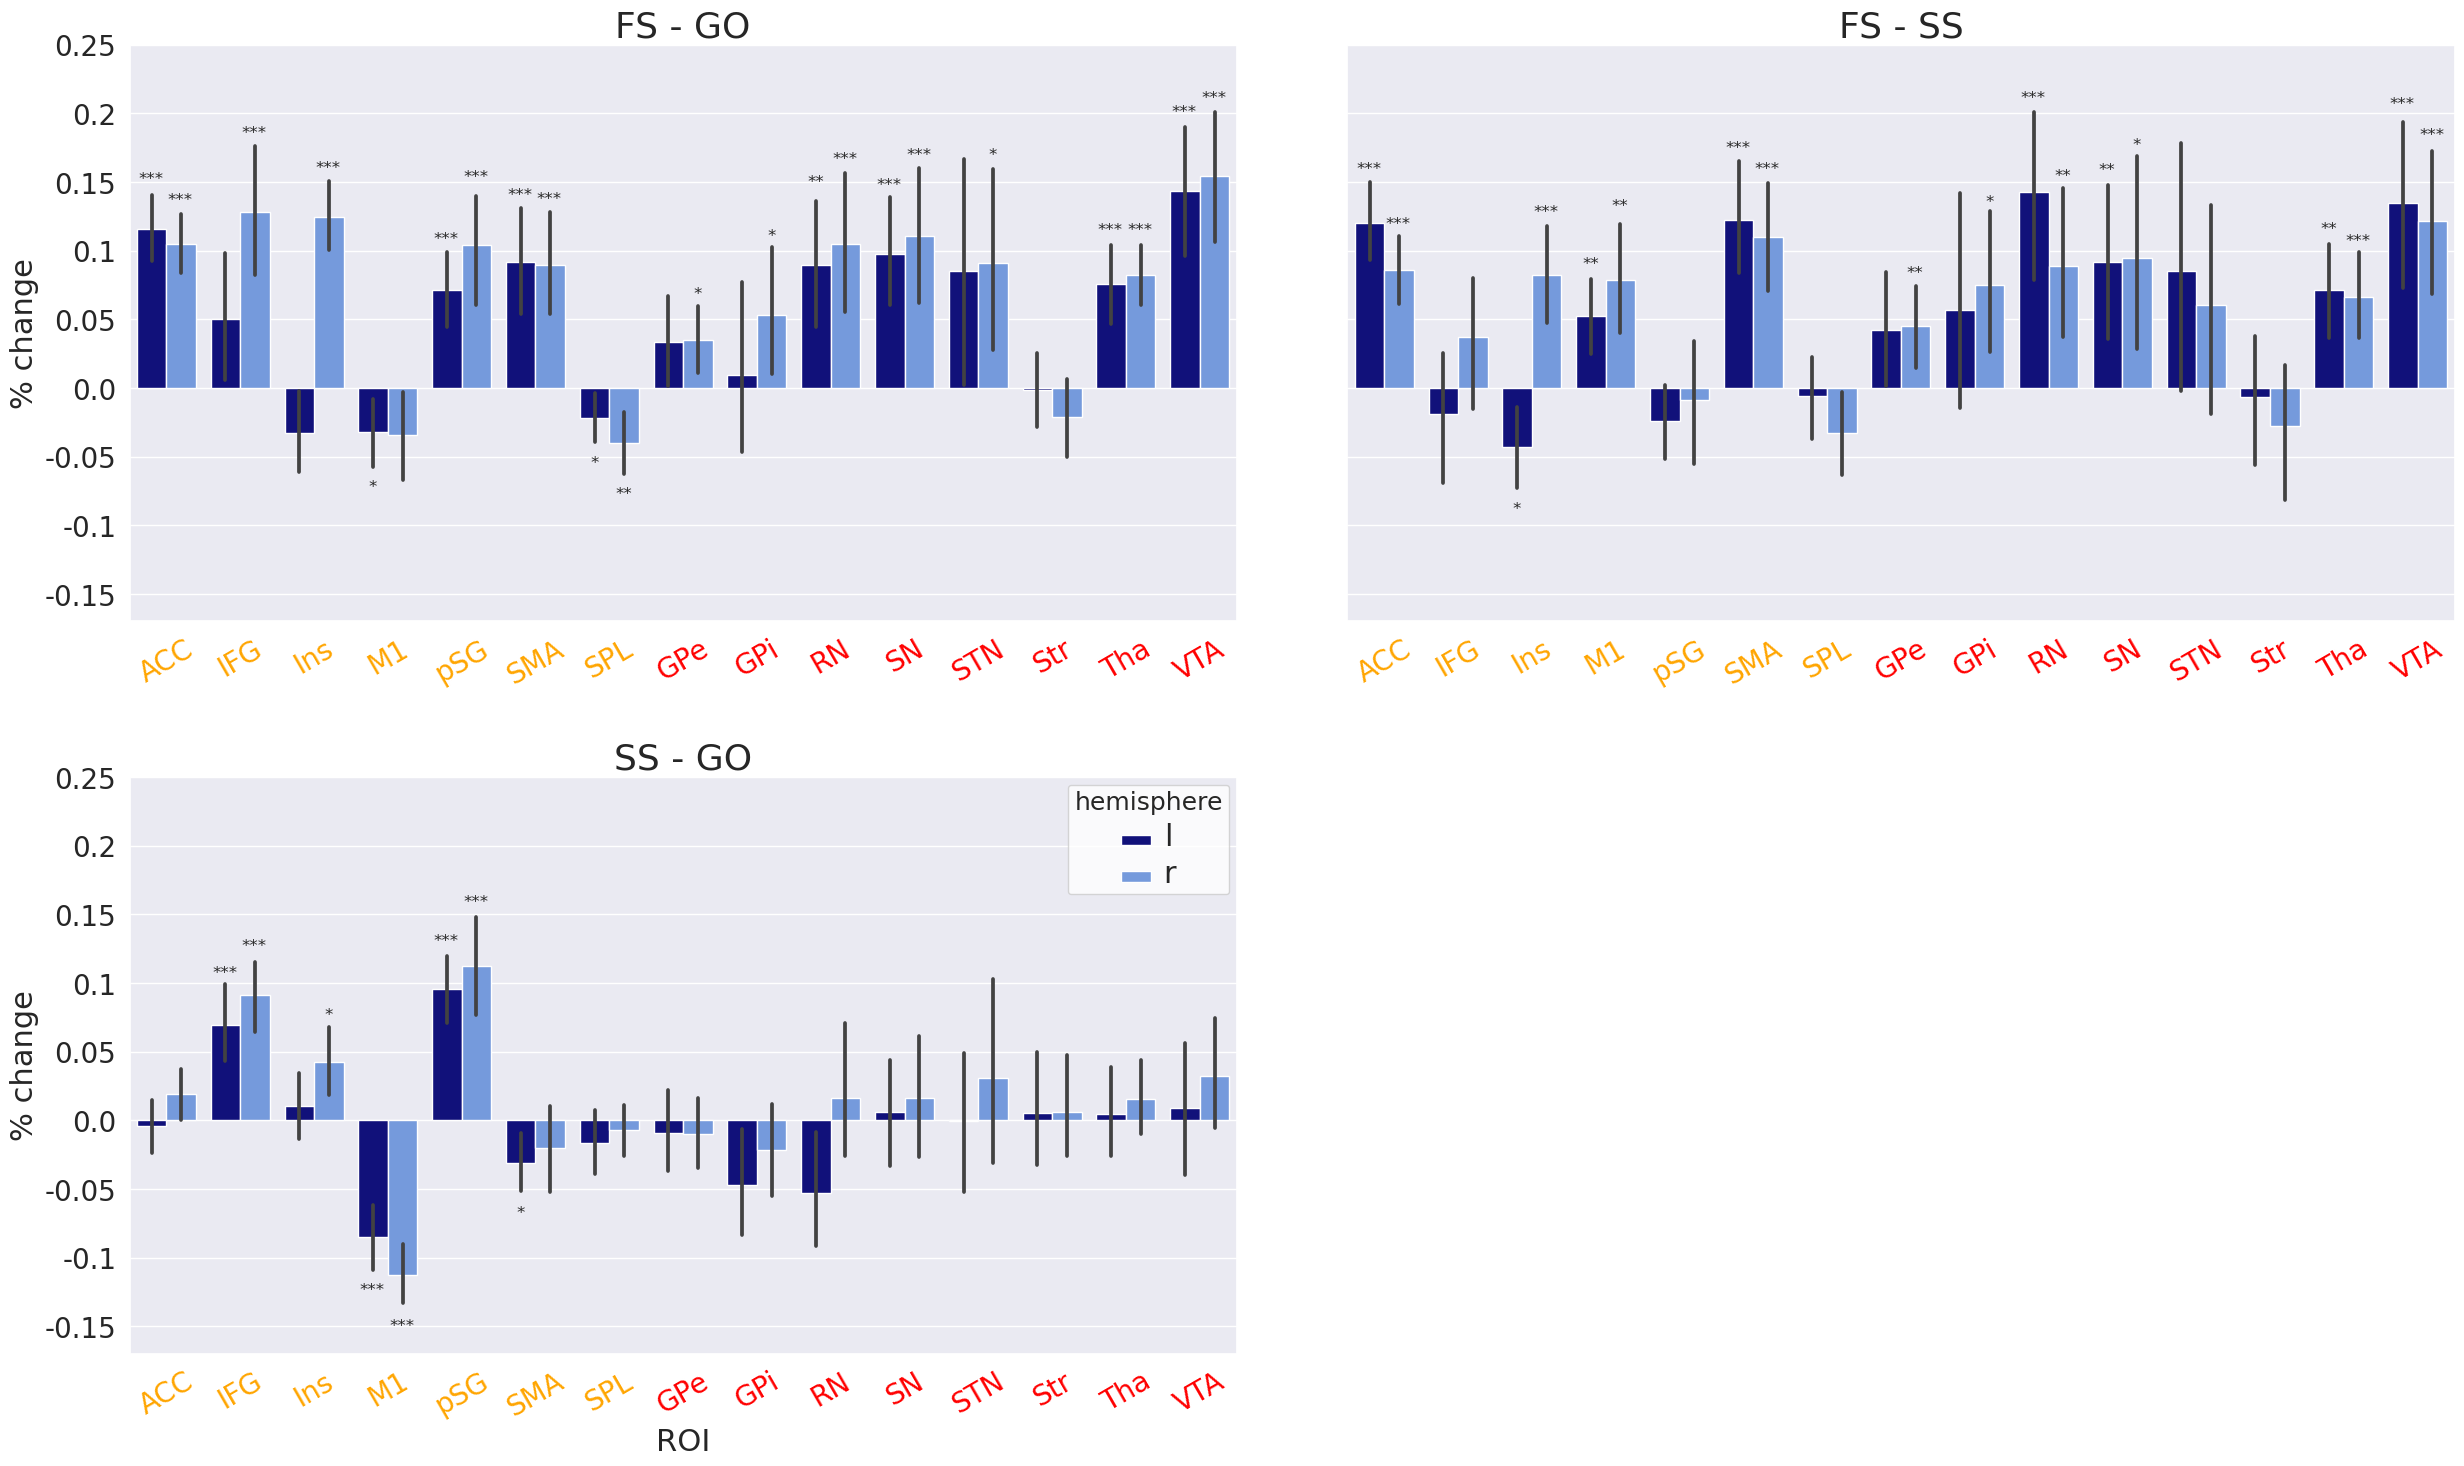

In [60]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

#     # 1 ## MOTOR RESPONSE
#     sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
#                 data=contrast_betas_motor, ax=ax[0],palette=("darkblue","cornflowerblue"))
#     ax[0].set_ylabel('% change', fontsize=22)
#     ax[0].set_xlabel('')
#     ax[0].legend_.remove()
#     ax[0].set_title('Contralateral - ipsilateral', fontsize=26)
#     ax[0].set(ylim=(-0.17,0.25))
#     add_asteriks(0, contrast_betas_motor, 'beta_contra-ipsi', stat_leftright['significance'])
#     # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
#     ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_fs-go', hue='hemisphere', 
                data=contrast_betas_fsgo, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS - GO', fontsize=26)
    ax[0].set(ylim=(-0.17,0.25))
    add_asteriks(0, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)

    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_fs-ss', hue='hemisphere', 
                data=contrast_betas_fsss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('FS - SS', fontsize=26)
    ax[1].set(ylim=(-0.17,0.25))
    add_asteriks(1, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)

    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_ss-go', hue='hemisphere', 
                data=contrast_betas_ssgo, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[3].legend_.remove()
    ax[2].set_title('SS - GO', fontsize=26)
    ax[2].set(ylim=(-0.17,0.25))
    add_asteriks(2, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    plt.setp(ax[2].get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax[2].get_legend().get_title(), fontsize='18') # for legend title

    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].axis('off')


    f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

/tmp/ipykernel_2928166/1157392251.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_2928166/1157392251.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


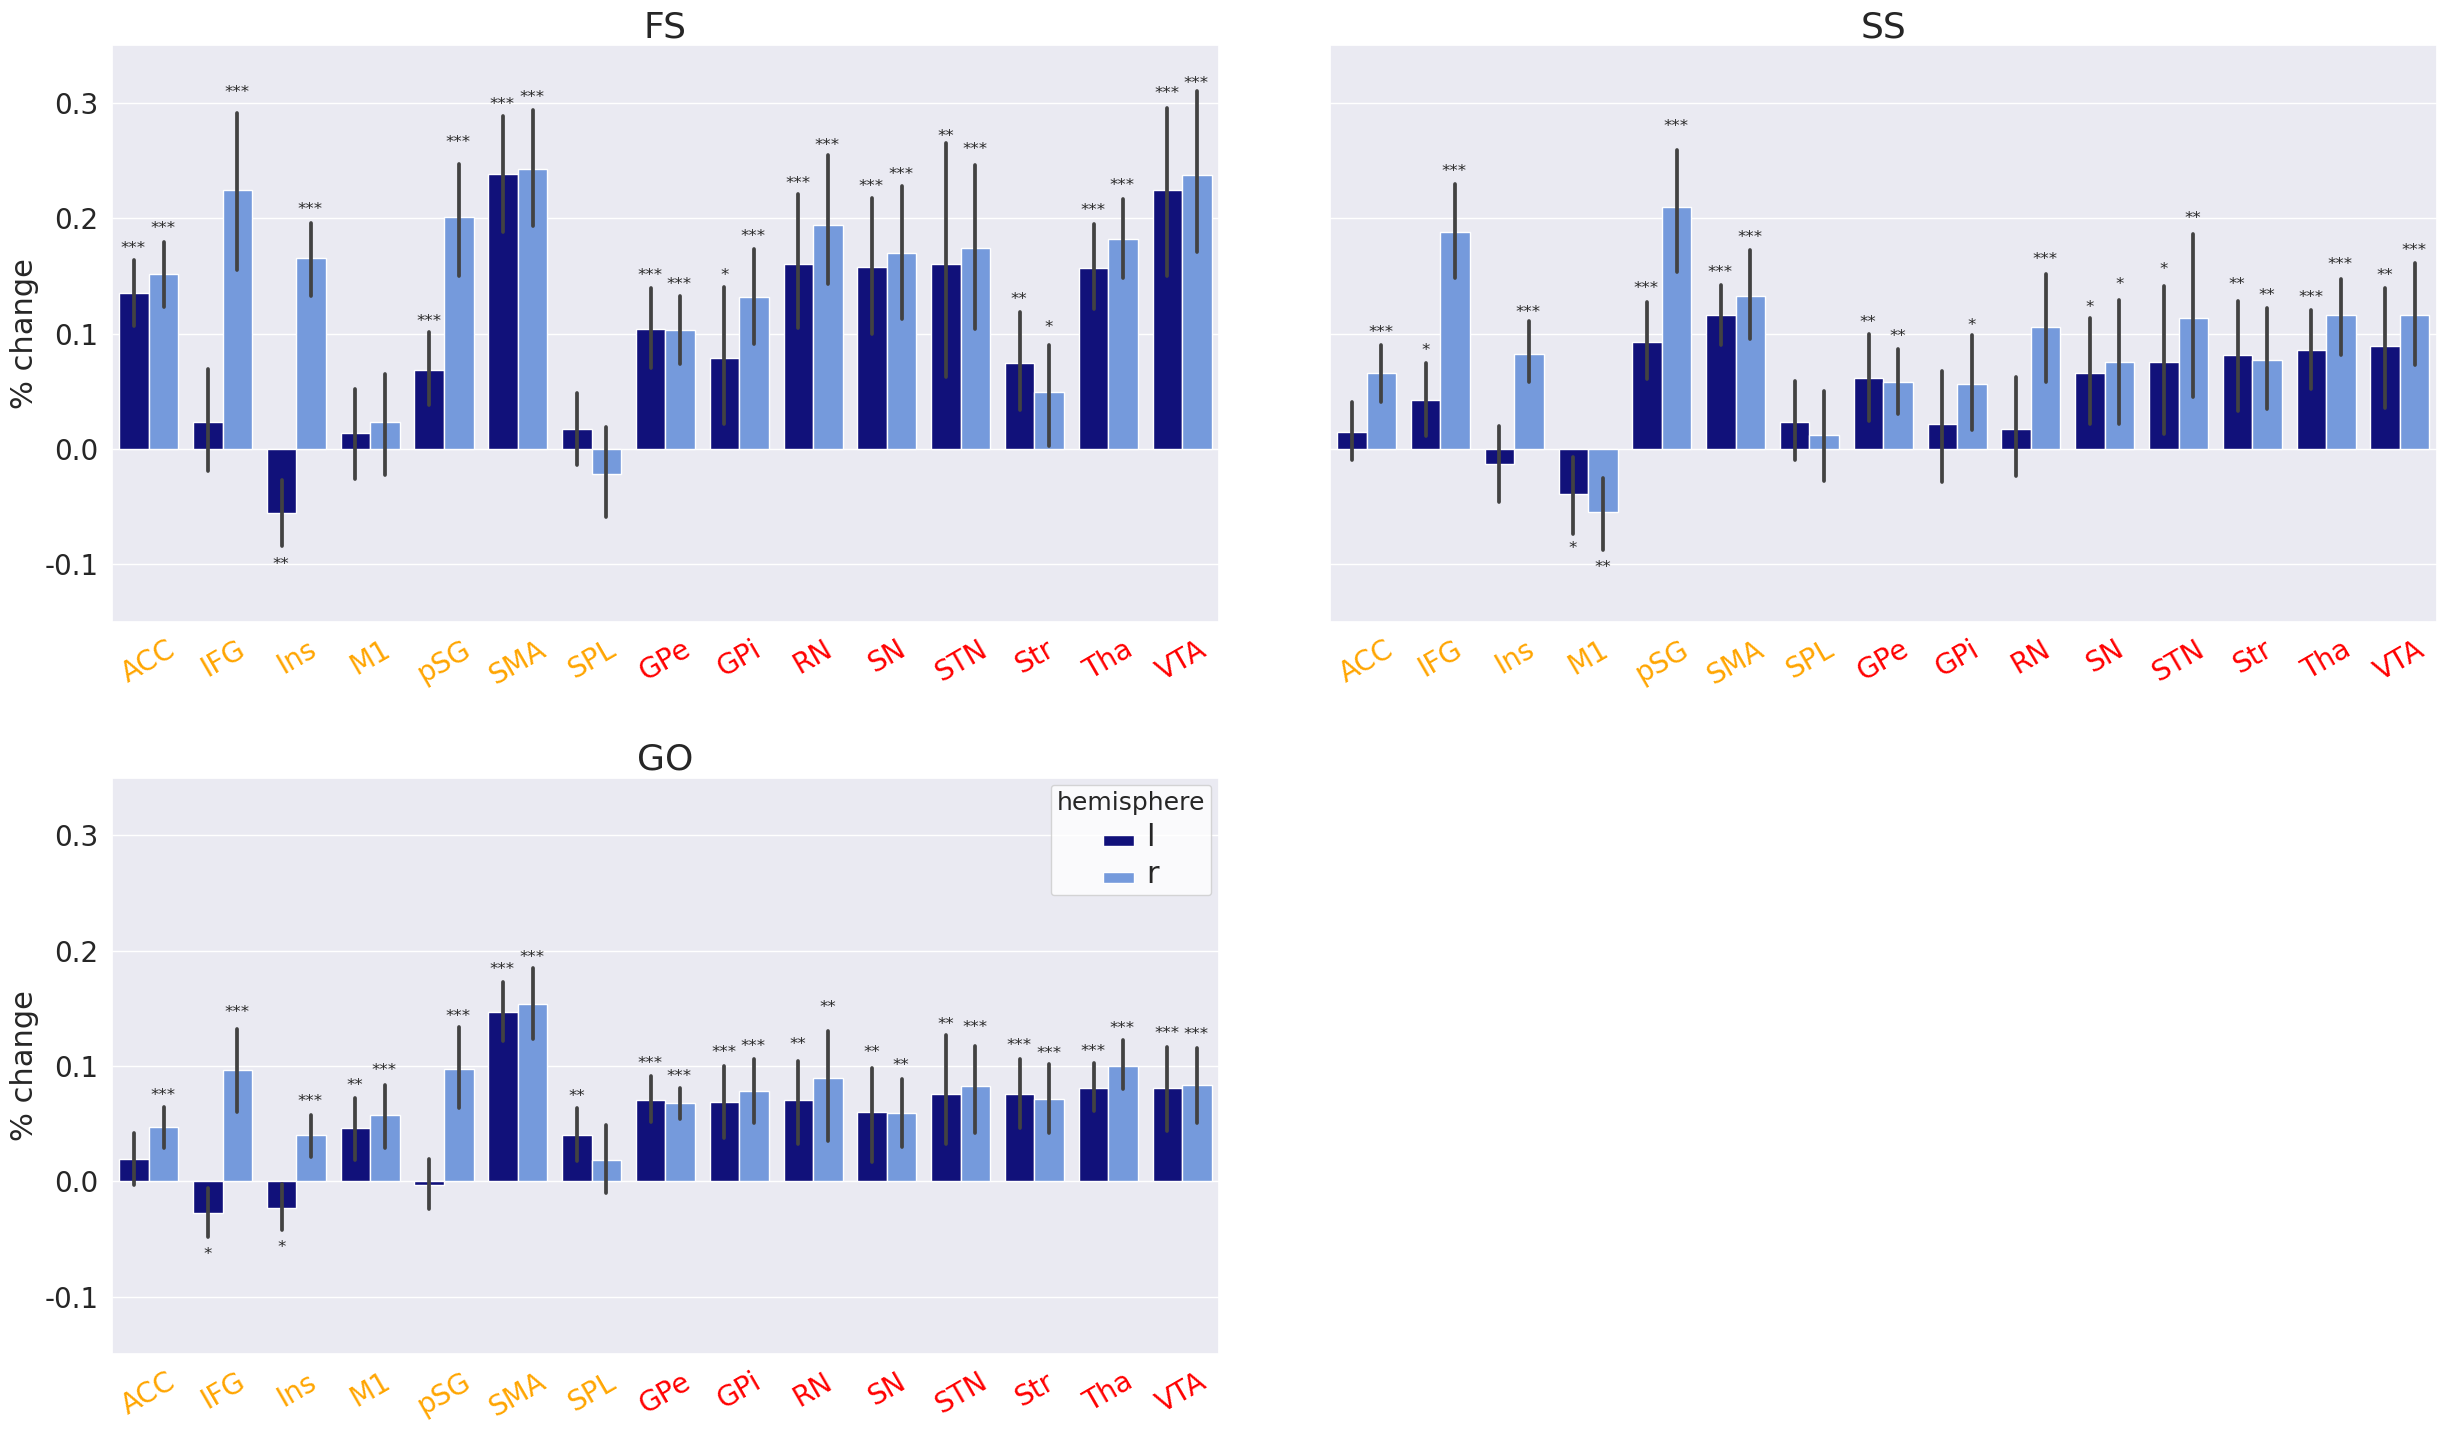

In [62]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    ## 1 ## FS
    sns.barplot(x='ROI_nohemi', y='beta_fs', hue='hemisphere', 
                data=betas_fs, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS', fontsize=26)
    ax[0].set(ylim=(-0.15,0.35))
    add_asteriks(0, betas_fs, 'beta_fs', stat_fs['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2 SS
    sns.barplot(x='ROI_nohemi', y='beta_ss', hue='hemisphere', 
                data=betas_ss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('SS', fontsize=26)
    ax[1].set(ylim=(-0.15,0.35))
    add_asteriks(1, betas_ss, 'beta_ss', stat_ss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)

    ## 3 GO
    sns.barplot(x='ROI_nohemi', y='beta_go', hue='hemisphere', 
                data=betas_go, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('GO', fontsize=26)
    ax[2].set(ylim=(-0.15,0.35))
    add_asteriks(2, betas_go, 'beta_go', stat_go['significance'])
    # ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    plt.setp(ax[2].get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax[2].get_legend().get_title(), fontsize='18') # for legend title
    
    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].set_visible(False)
    
    f.savefig('figure_download_scott/GLM_ROI_SST_supplementary.pdf', bbox_inches='tight')

In [26]:
# load and save glm info for model based analysis
# absolute values for FS, SS and GO trials for each region
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
fs_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest
ss_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest
go_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

fs_betas.to_csv('scott/fs_betas_tsv.tsv',sep='\t')
ss_betas.to_csv('scott/ss_betas_tsv.tsv',sep='\t')
go_betas.to_csv('scott/go_betas_tsv.tsv',sep='\t')
# fs_reg = 



# # fs - go
# subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
# subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
# contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
# if atlas_type == 'ATAG':
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
# else:
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
# contrast_betas_fsgo = contrast_betas.copy()

# MSIT

Regions of interest (MSIT):
    
IFG
ACC
SMA
SPL
pSG
Ins
GPe
GPi
RN
SN
STN
STR
Tha
VTA

In [33]:
## Load timeseries
atlas_type = 'ALL'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/sub-*/ses-sstmsit/func/*task-msit*{atlas_type}*s.tsv'))
signal_fns

filter_out_confounds = True
filter_hp = False

excluded_runs=[('007','1'),
               ('025','2'),
               ('025','2')]

regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-sstmsit_task-msit_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
dfs = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t')
    gd = regex.match(signal_fn).groupdict()
    if tuple(gd.values()) in excluded_runs:
        # run was excluded
        continue
    
    if 'time' in signals.columns:
        # if there's a column named 'time', it's called 'time' but it's really volume number..
        signals = signals.rename(columns={'time': 'volume'})
    signals = signals.set_index('volume')
    
    # psc?
    signals = signals.apply(to_psc)  # to PSC

    # filter out confounds?
    if filter_out_confounds:
        _, confounds = load_events_confounds(sub=gd['sub'], ses='sstmsit', task='msit', run=gd['run'])
        confounds['intercept'] = 1   # add intercept!
        betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
        signals_hat = confounds@betas
        signals_hat.index = signals.index
        signals_hat.columns = signals.columns
        signals -= signals_hat   # residuals
        
    # high pass?
    if filter_hp:
        signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/1.38) + x.mean(), axis=0)
    
    
    # index to time
    signals.index *= 1.38
    signals.index.name = 'time'
    signals['subject'] = gd['sub']
    signals['run'] = int(gd['run'])
        
    signals = signals.reset_index().set_index(['subject', 'run', 'time'])
    dfs.append(signals)
df = pd.concat(dfs)

if atlas_type == 'ALL':
    df.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r'}, inplace = True)
#     rois_ = sorted(['IFG-l','IFG-r','ACC-l','ACC-r','SPL-l','SPL-r','SMA-l','SMA-r','pSG-l','pSG-r','Ins-l','Ins-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r'])
    rois_ = ['ACC-l','ACC-r','IFG-l','IFG-r','Ins-l','Ins-r','M1-l','M1-r','pSG-l','pSG-r','SMA-l','SMA-r','SPL-l','SPL-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
             'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r']
    df = df[rois_]

df.head()

/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_2928166/3661814483.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

ACC-l     ACC-r     IFG-l     IFG-r     Ins-l     Ins-r  \
subject run time                                                               
002     1   0.00  0.430860  0.277018  0.175731  0.184864 -0.244789  0.369688   
            1.38  0.628941  0.449759 -0.185261  0.293168  0.170768  0.061376   
            2.76  0.075695  0.114713 -0.425001 -0.081050  0.295056 -0.114047   
            4.14  0.157071  0.137836 -0.218409 -0.043152  0.233796 -0.064533   
            5.52  0.043367  0.036001 -0.454363 -0.447470 -0.026695 -0.110305   

                      M1-l      M1-r     pSG-l     pSG-r  ...      SN-l  \
subject run time                                          ...             
002     1   0.00  0.492181  0.646085  0.398283  0.035924  ... -0.023016   
            1.38  0.114439  0.445443  0.189886  0.108741  ...  0.374051   
            2.76  0.065493  0.447289 -0.080375 -0.045606  ...  0.376516   
            4.14 -0.036828  0.324874 -0.117285 -0.149213  ...  0.286913   
            5.52  0.175844  0.563659 -0.402224 -0.297852  ...  0.395107   

                      SN-r     STN-l     STN-r     Str-l     Str-r     Tha-l  \
subject run time                                                               
002     1   0.00  0.081500 -0.597746 -1.473532  0.366467  0.188631  0.125829   
            1.38  0.162760  0.414008  0.166591  0.479220  0.358781  0.497830   
            2.76  1.043505  1.030441 -0.118265  0.379379  0.381561  0.661366   
            4.14  0.175451  0.633586 -0.528424  0.431832  0.352878  0.362343   
            5.52 -0.029481  0.380898 -1.448474  0.166489  0.199381  0.410849   

                     Tha-r     VTA-l     VTA-r  
subject run time                                
002     1   0.00  0.445567  0.625676  0.208860  
            1.38  0.411068  0.643357  0.853299  
            2.76  0.635618  1.281650  1.499400  
            4.14  0.424321  0.920735  0.461058  
            5.52  0.305668  0.780969  0.337835  

[5 rows x 30 columns]

## load event, confounds

In [34]:
model_n = 'all_events'
all_events = []
all_confounds = []

for sub, run in df.reset_index().set_index(['subject', 'run']).index.unique():
    events, confounds = load_events_confounds(sub, 'sstmsit', 'msit', run, include_physio=True)
    events['subject'] = sub
    events['run'] = run
    confounds['subject'] = sub
    confounds['run'] = run
    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['subject', 'run'])
confounds = pd.concat(all_confounds).set_index(['subject', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})

events['duration'] = 0.001  # stick function

## glm function

In [35]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=1.38, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
#         if event_type in ['stimulus_value_difference', 'feedback_PE']:
#             glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
#         else:
        glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 19.32])

    glm1.fit(type=fit_type)
    return glm1

## fit events

In [36]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = sorted(['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL'], key=str.casefold)
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
#     gm_nuclei = sorted(['IFG','ACC','SPL','SMA','pSG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'], key=str.casefold)
    gm_nuclei = ['ACC','IFG','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
# include_events = ['fs','ss','go']
include_events = ['con','simon','flanker','inc']
glm1 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/hom

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

## fit motor glm

In [37]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = sorted(['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL'], key=str.casefold)
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
#     gm_nuclei = sorted(['IFG','ACC','SPL','SMA','pSG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'], key=str.casefold)
    gm_nuclei = ['ACC','IFG','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_events = ['response_index','response_middle','response_ring']
glm_m = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/hom

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

## plotting

In [38]:
import copy

glm1_ar1 = copy.deepcopy(glm1)

tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

SMA_simon v.s. SMA_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.740e+00
SPL_simon v.s. SPL_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.134e+00
GPe_simon v.s. GPe_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.817e+00
GPi_simon v.s. GPi_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=6.318e-01
RN_simon v.s. RN_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=7.231e-01
SN_simon v.s. SN_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-6.471e-01
STN_simon v.s. STN_flanker: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=2.391e+00
Str_simon v.s. Str_flanker: t-test paired samples with Bonferroni correctio

GPe_con v.s. GPe_inc: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-6.039e-01
Ins_con v.s. Ins_inc: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-1.352e-01
ACC_con v.s. ACC_inc: t-test paired samples with Bonferroni correction, P_val=5.676e-02 stat=-3.582e+00
IFG_con v.s. IFG_inc: t-test paired samples with Bonferroni correction, P_val=7.489e-05 stat=-5.417e+00
GPi_con v.s. GPi_inc: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.414e+00
RN_con v.s. RN_inc: t-test paired samples with Bonferroni correction, P_val=1.944e-01 stat=-3.187e+00
SN_con v.s. SN_inc: t-test paired samples with Bonferroni correction, P_val=1.043e-01 stat=-3.390e+00
STN_con v.s. STN_inc: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-2.543e+00
Str_con v.s. Str_inc: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.176e+00
Tha_con v.s. Tha_inc: t-test paired samples with Bonferroni correction

Text(0.5, 80.7222222222222, 'ROI')

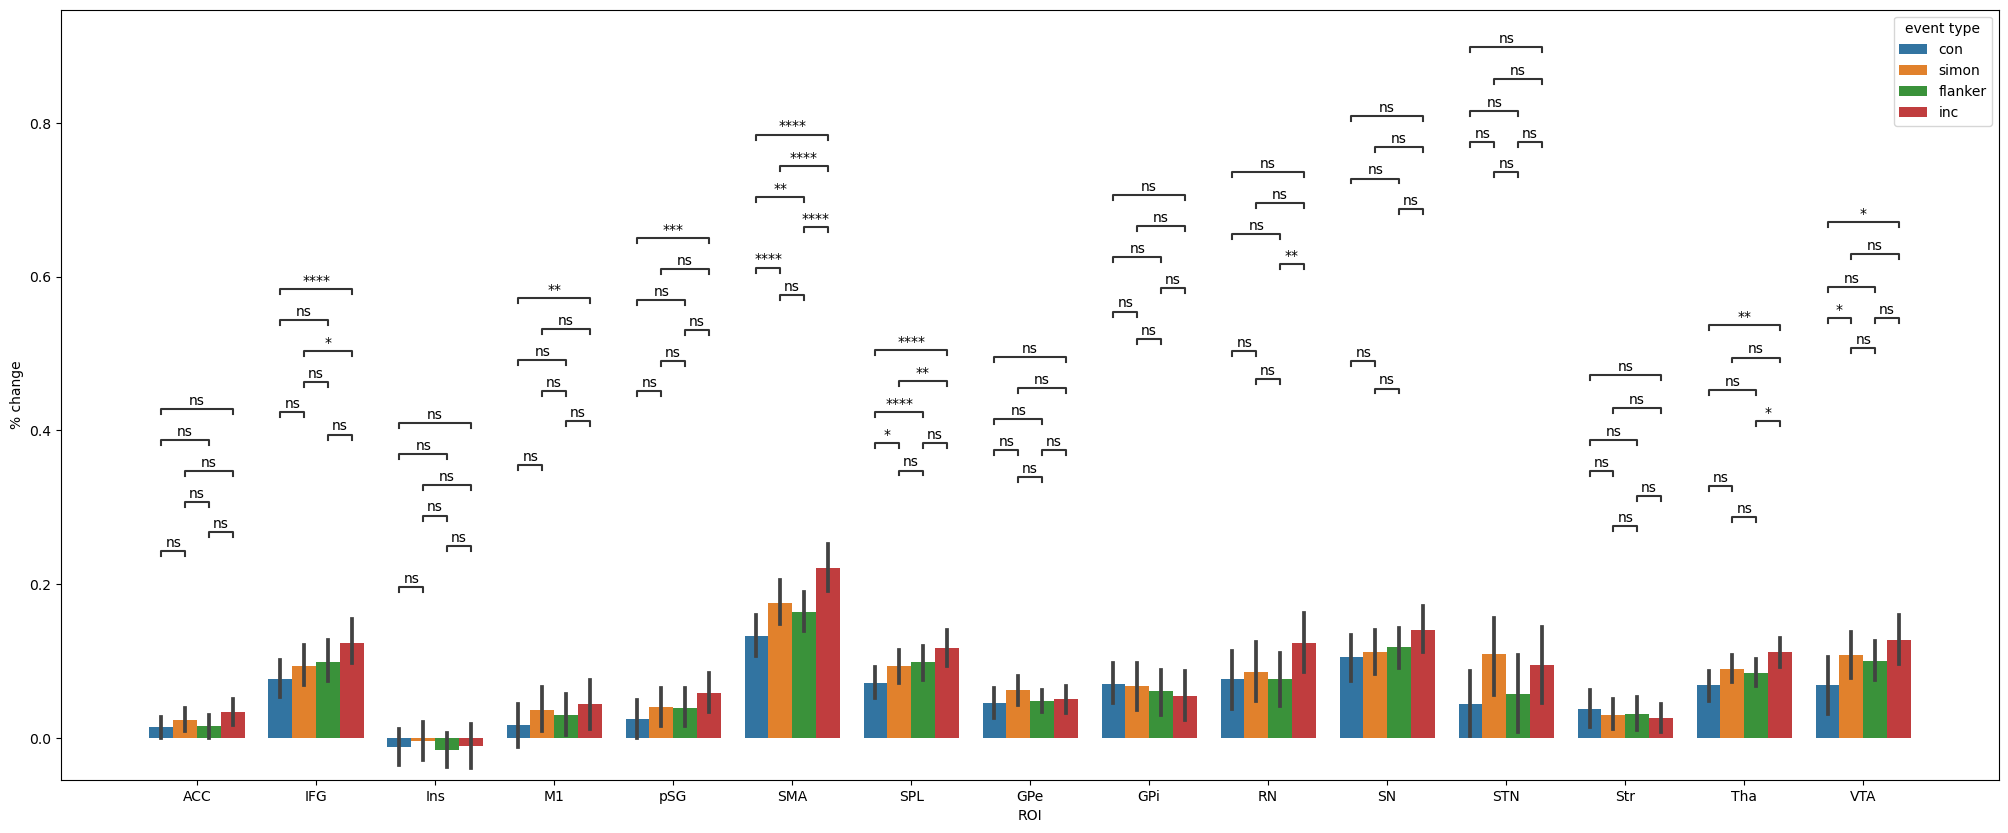

In [39]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['con','simon','flanker','inc'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(25,10))
sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)

box_pairs = []
for index in contrast_betas['ROI_nohemi'].unique():
    box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'con','simon','flanker','inc'],2))[:4],2)))
    
# box_pairs = box_pairs[:1]
statannot.add_stat_annotation(
    ax,
    data=contrast_betas, 
    x='ROI_nohemi',
    y='signal_change',
    hue='event type',
#     hue_order=['go','fs','ss'],
    box_pairs=box_pairs,
    test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
    text_format="star",
    loc="inside",
#     text_offset=-0.5,
#     line_offset_to_box=-0.5,
#     line_offset=-0.5,
#     use_fixed_offset=True
#     line_height=1
)

ax.set_ylabel('% change')
ax.set_xlabel('ROI')



Text(0.5, 0, 'ROI')

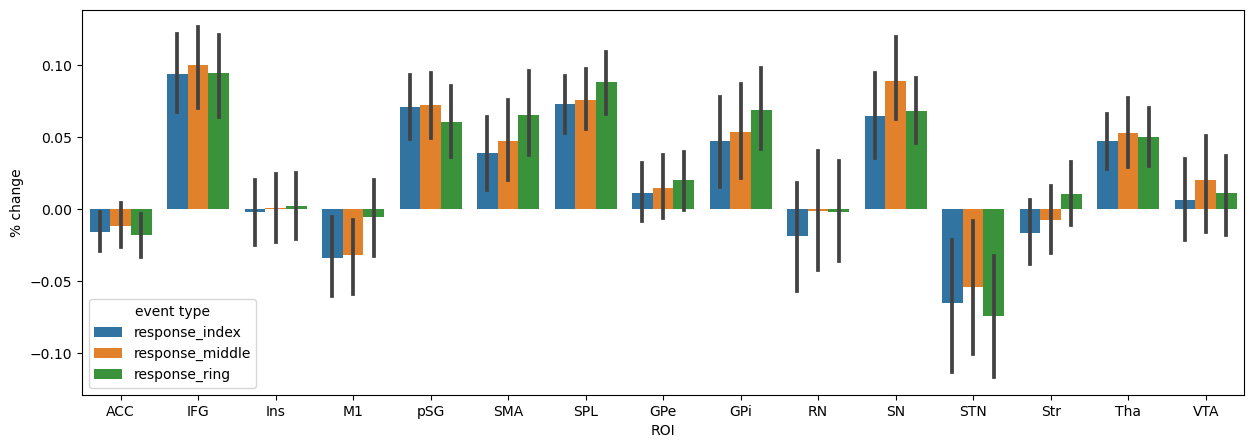

In [40]:
all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_index','response_middle','response_ring'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)
ax.set_ylabel('% change')
ax.set_xlabel('ROI')

# compare contrasts

In [41]:
# load the betas
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe

# inc con
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['con', 'inc'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('inc',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_inc-con', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_inccon = contrast_betas.copy()

# inc simon
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['simon', 'inc'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('inc',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_inc-simon', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_incsimon = contrast_betas.copy()

# inc flanker
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['flanker', 'inc'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('inc',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_inc-flanker', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_incflanker = contrast_betas.copy()

# simon flanker
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['flanker', 'simon'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('simon',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_simon-flanker', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_simonflanker = contrast_betas.copy()

# simon con
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['con', 'simon'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('simon',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_simon-con', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_simoncon = contrast_betas.copy()

# flanker con
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['con', 'flanker'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
contrast_betas = contrast_betas.xs('flanker',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_flanker-con', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_flankercon = contrast_betas.copy()

##########
###########
###########
# now look just at absolute activtions with trial types
############

# Inc
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['inc'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_inc', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_inc = contrast_betas.copy()

# sim
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['simon'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_simon', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_simon = contrast_betas.copy()

# flanker
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['flanker'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_flanker', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_flanker = contrast_betas.copy()

# con
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['con'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_con', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_con = contrast_betas.copy()



# look at significance

In [42]:
tmp = betas_inc.groupby('ROI')['beta_inc'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'

stat_inc = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_flanker.groupby('ROI')['beta_flanker'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'

stat_flanker = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_simon.groupby('ROI')['beta_simon'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'

stat_simon = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_con.groupby('ROI')['beta_con'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'

stat_con = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_inc, stat_flanker, stat_simon, stat_con = stat_inc.reindex(rois_), stat_flanker.reindex(rois_), stat_simon.reindex(rois_), stat_con.reindex(rois_)


In [43]:
display_side_by_side(stat_inc,stat_simon,stat_flanker,stat_con, titles=['inc','simon','flanker','con'])



inc 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 1.651037 
 1.079395e-01 
 False 
 0.119933 
 
 
 
 ACC-r 
 4.226242 
 1.685301e-04 
 True 
 0.000281 
 *** 
 
 
 IFG-l 
 4.197681 
 1.830999e-04 
 True 
 0.000289 
 *** 
 
 
 IFG-r 
 7.663596 
 6.573400e-09 
 True 
 0.0 
 *** 
 
 
 Ins-l 
 -9.352705 
 6.290927e-11 
 True 
 0.0 
 *** 
 
 
 Ins-r 
 9.682158 
 2.650157e-11 
 True 
 0.0 
 *** 
 
 
 M1-l 
 9.641783 
 2.944093e-11 
 True 
 0.0 
 *** 
 
 
 M1-r 
 -4.024832 
 3.015563e-04 
 True 
 0.000452 
 *** 
 
 
 pSG-l 
 1.424114 
 1.635272e-01 
 False 
 0.175208 
 
 
 
 pSG-r 
 5.344057 
 6.139293e-06 
 True 
 0.000014 
 *** 
 
 
 SMA-l 
 10.465434 
 3.592522e-12 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 9.415196 
 5.333687e-11 
 True 
 0.0 
 *** 
 
 
 SPL-l 
 12.468538 
 3.094032e-14 
 True 
 0.0 
 *** 
 
 
 SPL-r 
 4.440535 
 9.012338e-05 
 True 
 0.000169 
 *** 
 
 
 GPe-l 
 4.388270 
 1.050482e-04 
 True 
 0.000185 
 *** 
 
 
 GPe-r 
 3.207543 
 2.914912e-03 
 True 
 0.003644 
 ** 
 
 
 GPi-l 
 3.306604 
 2.236016e-03 
 True 
 0.003049 
 ** 
 
 
 GPi-r 
 1.369695 
 1.797610e-01 
 False 
 0.18596 
 
 
 
 RN-l 
 3.693808 
 7.713572e-04 
 True 
 0.001102 
 ** 
 
 
 RN-r 
 5.095267 
 1.292489e-05 
 True 
 0.000026 
 *** 
 
 
 SN-l 
 6.720873 
 1.013419e-07 
 True 
 0.0 
 *** 
 
 
 SN-r 
 6.042008 
 7.596784e-07 
 True 
 0.000002 
 *** 
 
 
 STN-l 
 2.166930 
 3.733844e-02 
 True 
 0.043083 
 * 
 
 
 STN-r 
 3.223867 
 2.790910e-03 
 True 
 0.00364 
 ** 
 
 
 Str-l 
 2.584555 
 1.421661e-02 
 True 
 0.01706 
 * 
 
 
 Str-r 
 1.341502 
 1.886497e-01 
 False 
 0.18865 
 
 
 
 Tha-l 
 8.645268 
 4.222497e-10 
 True 
 0.0 
 *** 
 
 
 Tha-r 
 8.002861 
 2.512642e-09 
 True 
 0.0 
 *** 
 
 
 VTA-l 
 5.575803 
 3.065785e-06 
 True 
 0.000008 
 *** 
 
 
 VTA-r 
 5.293585 
 7.141083e-06 
 True 
 0.000015 
 *** 
 
 
 simon 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 1.241416 
 2.229489e-01 
 False 
 0.230637 
 
 
 
 ACC-r 
 3.497022 
 1.331775e-03 
 True 
 0.001903 
 ** 
 
 
 IFG-l 
 2.943547 
 5.811989e-03 
 True 
 0.007265 
 ** 
 
 
 IFG-r 
 7.357509 
 1.582517e-08 
 True 
 0.0 
 *** 
 
 
 Ins-l 
 -7.162270 
 2.785618e-08 
 True 
 0.0 
 *** 
 
 
 Ins-r 
 7.785077 
 4.651403e-09 
 True 
 0.0 
 *** 
 
 
 M1-l 
 8.533917 
 5.731190e-10 
 True 
 0.0 
 *** 
 
 
 M1-r 
 -3.835834 
 5.170195e-04 
 True 
 0.000816 
 *** 
 
 
 pSG-l 
 0.374027 
 7.107068e-01 
 False 
 0.710707 
 
 
 
 pSG-r 
 5.027873 
 1.580675e-05 
 True 
 0.00004 
 *** 
 
 
 SMA-l 
 9.193849 
 9.592761e-11 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 8.089801 
 1.968040e-09 
 True 
 0.0 
 *** 
 
 
 SPL-l 
 10.016720 
 1.117682e-11 
 True 
 0.0 
 *** 
 
 
 SPL-r 
 3.871755 
 4.669303e-04 
 True 
 0.000778 
 *** 
 
 
 GPe-l 
 4.392996 
 1.036042e-04 
 True 
 0.000207 
 *** 
 
 
 GPe-r 
 4.143402 
 2.142747e-04 
 True 
 0.000378 
 *** 
 
 
 GPi-l 
 3.531736 
 1.210360e-03 
 True 
 0.001816 
 ** 
 
 
 GPi-r 
 2.438461 
 2.012650e-02 
 True 
 0.024152 
 * 
 
 
 RN-l 
 2.119065 
 4.146878e-02 
 True 
 0.046076 
 * 
 
 
 RN-r 
 4.262756 
 1.515505e-04 
 True 
 0.000284 
 *** 
 
 
 SN-l 
 6.064084 
 7.112275e-07 
 True 
 0.000002 
 *** 
 
 
 SN-r 
 4.758219 
 3.527618e-05 
 True 
 0.000081 
 *** 
 
 
 STN-l 
 3.200889 
 2.966945e-03 
 True 
 0.004046 
 ** 
 
 
 STN-r 
 3.046580 
 4.453081e-03 
 True 
 0.005808 
 ** 
 
 
 Str-l 
 2.319182 
 2.652715e-02 
 True 
 0.030608 
 * 
 
 
 Str-r 
 1.836671 
 7.501404e-02 
 False 
 0.080372 
 
 
 
 Tha-l 
 7.537771 
 9.421370e-09 
 True 
 0.0 
 *** 
 
 
 Tha-r 
 6.806772 
 7.871727e-08 
 True 
 0.0 
 *** 
 
 
 VTA-l 
 4.556566 
 6.405920e-05 
 True 
 0.000137 
 *** 
 
 
 VTA-r 
 5.067954 
 1.402376e-05 
 True 
 0.000038 
 *** 
 
 
 flanker 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 0.286908 
 7.759238e-01 
 False 
 0.775924 
 
 
 
 ACC-r 
 2.830360 
 7.750524e-03 
 True 
 0.010569 
 * 
 
 
 IFG-l 
 3.638724 
 8.996694e-04 
 True 
 0.001421 
 ** 
 
 
 IFG-r 
 6.9604

In [44]:
tmp = contrast_betas_inccon.groupby('ROI')['beta_inc-con'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'

stat_inccon = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_incsimon.groupby('ROI')['beta_inc-simon'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'

stat_incsimon = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_incflanker.groupby('ROI')['beta_inc-flanker'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'

stat_incflanker = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_simonflanker.groupby('ROI')['beta_simon-flanker'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'

stat_simonflanker = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_simoncon.groupby('ROI')['beta_simon-con'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'

stat_simoncon = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_flankercon.groupby('ROI')['beta_flanker-con'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p'])
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'

stat_flankercon = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_inccon, stat_incsimon, stat_incflanker, stat_simonflanker, stat_simoncon, stat_flankercon = stat_inccon.reindex(rois_), stat_incsimon.reindex(rois_), stat_incflanker.reindex(rois_), stat_simonflanker.reindex(rois_), stat_simoncon.reindex(rois_), stat_flankercon.reindex(rois_)


In [45]:
display_side_by_side(stat_inccon,stat_incsimon,stat_incflanker,stat_simoncon,stat_simonflanker,stat_flankercon, titles=['inc > con','inc > simon','inc > flanker','simon > con', 'simon > flanker', 'flanker > con'])

inc > con 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 2.346578 
 2.491269e-02 
 True 
 0.039336 
 * 
 
 
 ACC-r 
 2.687371 
 1.106581e-02 
 True 
 0.020748 
 * 
 
 
 IFG-l 
 4.109540 
 2.362981e-04 
 True 
 0.001181 
 ** 
 
 
 IFG-r 
 3.512690 
 1.275590e-03 
 True 
 0.004783 
 ** 
 
 
 Ins-l 
 -3.456883 
 1.486800e-03 
 True 
 0.004956 
 ** 
 
 
 Ins-r 
 3.137053 
 3.513196e-03 
 True 
 0.009369 
 ** 
 
 
 M1-l 
 4.963589 
 1.914845e-05 
 True 
 0.000144 
 *** 
 
 
 M1-r 
 1.142583 
 2.611940e-01 
 False 
 0.326492 
 
 
 
 pSG-l 
 3.044272 
 4.479919e-03 
 True 
 0.010338 
 * 
 
 
 pSG-r 
 4.184906 
 1.900109e-04 
 True 
 0.00114 
 ** 
 
 
 SMA-l 
 7.659733 
 6.646271e-09 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 6.974901 
 4.809416e-08 
 True 
 0.000001 
 *** 
 
 
 SPL-l 
 5.989409 
 8.889121e-07 
 True 
 0.000009 
 *** 
 
 
 SPL-r 
 3.885351 
 4.492318e-04 
 True 
 0.001925 
 ** 
 
 
 GPe-l 
 0.817583 
 4.192882e-01 
 False 
 0.483794 
 
 
 
 GPe-r 
 -0.075231 
 9.404721e-01 
 False 
 0.940472 
 
 
 
 GPi-l 
 -0.446736 
 6.578984e-01 
 False 
 0.680585 
 
 
 
 GPi-r 
 -1.573079 
 1.249612e-01 
 False 
 0.162993 
 
 
 
 RN-l 
 2.291430 
 2.825818e-02 
 True 
 0.042387 
 * 
 
 
 RN-r 
 2.227854 
 3.261249e-02 
 True 
 0.046589 
 * 
 
 
 SN-l 
 2.627182 
 1.282132e-02 
 True 
 0.022626 
 * 
 
 
 SN-r 
 2.130984 
 4.040413e-02 
 False 
 0.055097 
 
 
 
 STN-l 
 0.770168 
 4.465191e-01 
 False 
 0.496132 
 
 
 
 STN-r 
 2.866143 
 7.080310e-03 
 True 
 0.015172 
 * 
 
 
 Str-l 
 -0.693159 
 4.929178e-01 
 False 
 0.528126 
 
 
 
 Str-r 
 -0.950285 
 3.486738e-01 
 False 
 0.418409 
 
 
 
 Tha-l 
 3.290021 
 2.338012e-03 
 True 
 0.007014 
 ** 
 
 
 Tha-r 
 3.112494 
 3.747794e-03 
 True 
 0.009369 
 ** 
 
 
 VTA-l 
 2.774560 
 8.915156e-03 
 True 
 0.01783 
 * 
 
 
 VTA-r 
 2.540460 
 1.580607e-02 
 True 
 0.026343 
 * 
 
 
 inc > simon 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 0.920503 
 0.363795 
 False 
 0.454744 
 
 
 
 ACC-r 
 1.733886 
 0.091999 
 False 
 0.172498 
 
 
 
 IFG-l 
 3.418550 
 0.001651 
 True 
 0.009906 
 ** 
 
 
 IFG-r 
 1.978079 
 0.056069 
 False 
 0.129391 
 
 
 
 Ins-l 
 -4.085491 
 0.000253 
 True 
 0.002533 
 ** 
 
 
 Ins-r 
 1.664299 
 0.105244 
 False 
 0.175406 
 
 
 
 M1-l 
 2.830231 
 0.007753 
 True 
 0.038765 
 * 
 
 
 M1-r 
 -0.060197 
 0.952351 
 False 
 0.952351 
 
 
 
 pSG-l 
 2.238048 
 0.031876 
 False 
 0.103672 
 
 
 
 pSG-r 
 1.779774 
 0.084053 
 False 
 0.168106 
 
 
 
 SMA-l 
 4.754323 
 0.000036 
 True 
 0.000621 
 *** 
 
 
 SMA-r 
 3.929205 
 0.000396 
 True 
 0.002974 
 ** 
 
 
 SPL-l 
 4.704096 
 0.000041 
 True 
 0.000621 
 *** 
 
 
 SPL-r 
 1.508968 
 0.140545 
 False 
 0.210817 
 
 
 
 GPe-l 
 -0.531466 
 0.598552 
 False 
 0.665057 
 
 
 
 GPe-r 
 -2.085968 
 0.044556 
 False 
 0.121517 
 
 
 
 GPi-l 
 -0.340342 
 0.735693 
 False 
 0.788242 
 
 
 
 GPi-r 
 -1.448682 
 0.156587 
 False 
 0.223696 
 
 
 
 RN-l 
 2.292383 
 0.028197 
 False 
 0.103672 
 
 
 
 RN-r 
 1.565790 
 0.126659 
 False 
 0.199988 
 
 
 
 SN-l 
 2.008677 
 0.052566 
 False 
 0.129391 
 
 
 
 SN-r 
 1.688619 
 0.100445 
 False 
 0.175406 
 
 
 
 STN-l 
 -1.859695 
 0.071599 
 False 
 0.153427 
 
 
 
 STN-r 
 0.658044 
 0.514941 
 False 
 0.617929 
 
 
 
 Str-l 
 -0.146916 
 0.884066 
 False 
 0.914551 
 
 
 
 Str-r 
 -0.590781 
 0.558574 
 False 
 0.644509 
 
 
 
 Tha-l 
 2.231773 
 0.032328 
 False 
 0.103672 
 
 
 
 Tha-r 
 2.201885 
 0.034557 
 False 
 0.103672 
 
 
 
 VTA-l 
 1.057396 
 0.297786 
 False 
 0.399137 
 
 
 
 VTA-r 
 1.039289 
 0.306005 
 False 
 0.399137 
 
 
 
 inc > flanker 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 1.953482 
 0.059031 
 False 
 0.110683 
 
 
 
 ACC-r 
 2.572042 
 0.014652 
 True 
 0.038406 
 * 
 
 
 IFG-l 
 2.614074 
 0.013236 
 True 
 0.038406 
 * 
 
 
 IFG-r 
 2.103825 
 0.042866 
 False 
 0.091856 
 
 
 
 Ins-l 
 -4.428604 
 0.000093 
 True 
 0.000983 
 *** 
 
 
 Ins-

## plot all 6 contrasts

/tmp/ipykernel_2928166/1906401336.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_2928166/1906401336.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_2928166/1906401336.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_yticklabels(ax[4].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_2928166/1906401336.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[5].set_yticklabels(ax[5].get_yticks().round(2),fontsize=20)


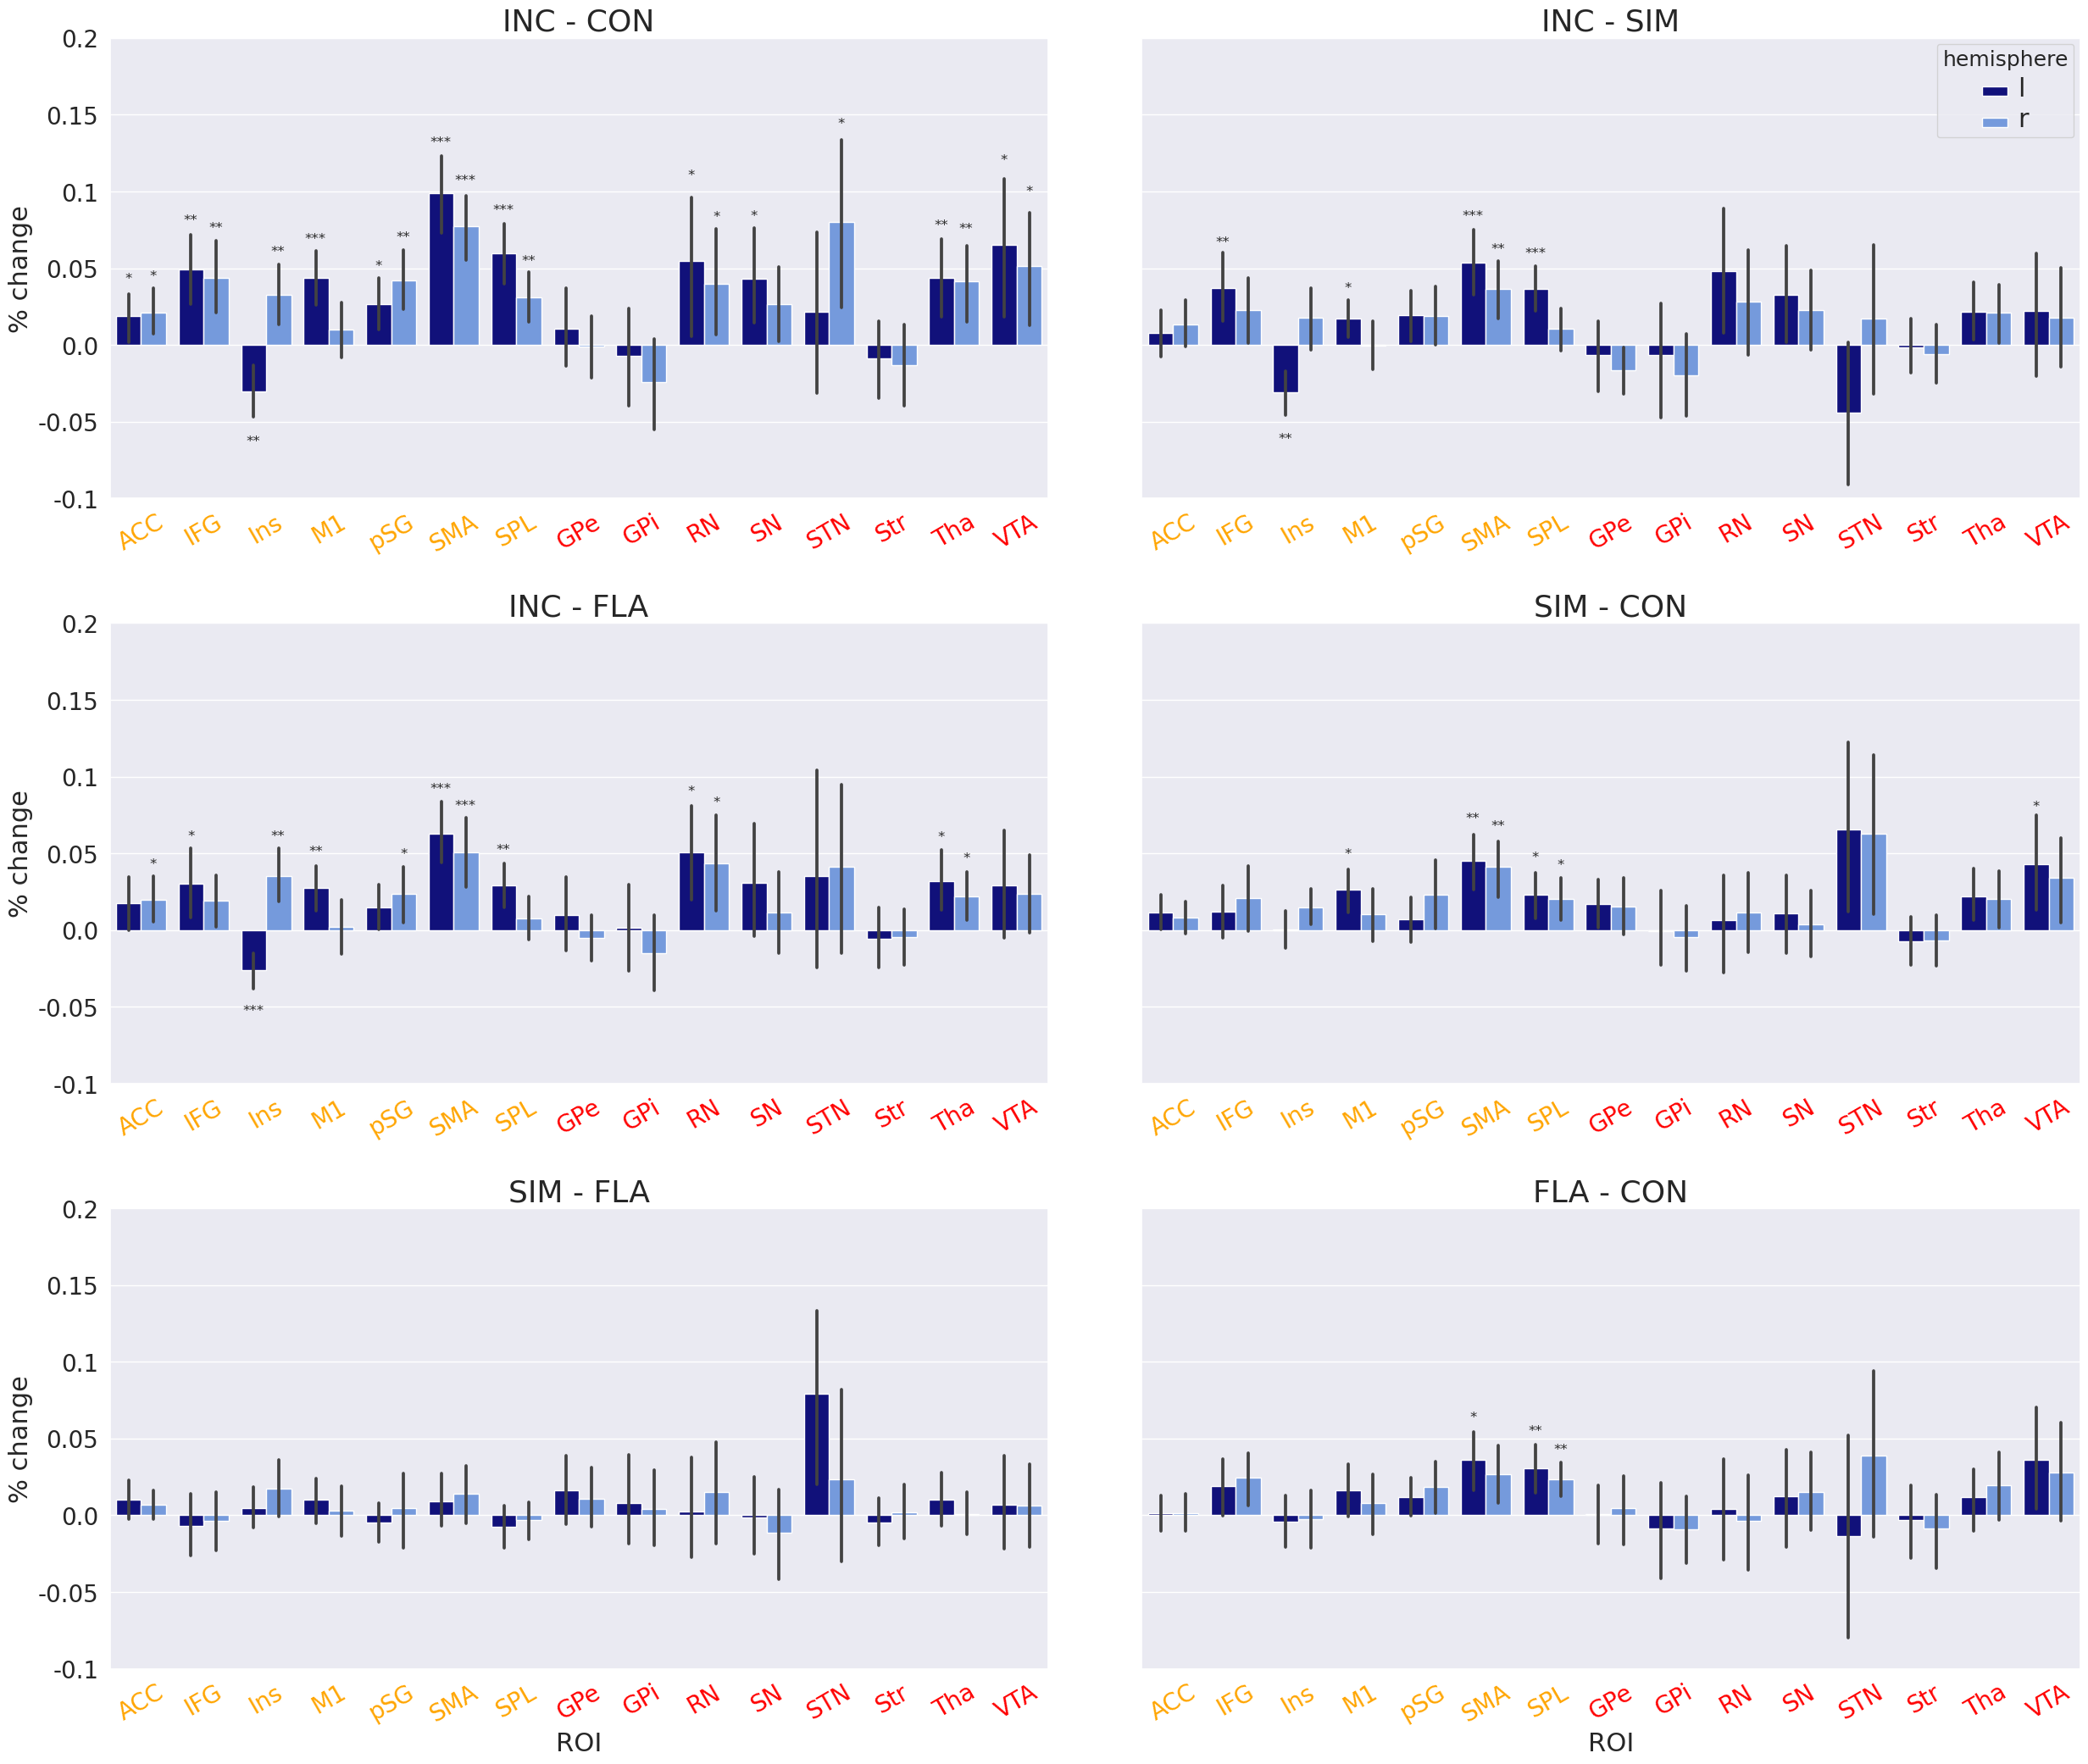

In [49]:
f, axes = plt.subplots(3,2, figsize=(30,25), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)

sns.set_theme() # to make style changable from defaults use this line of code befor using set_style
with sns.axes_style("whitegrid"):
    ## 1
    sns.barplot(x='ROI_nohemi', y='beta_inc-con', hue='hemisphere', 
                data=contrast_betas_inccon, ax=ax[0],palette=("darkblue","cornflowerblue"))
    sns.set(font_scale=1)
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('INC - CON', fontsize=26)
    # ax[0].set(ylim=(-0.095,0.175))
    ax[4].set(ylim=(-0.1,0.2))
    add_asteriks(0, contrast_betas_inccon, 'beta_inc-con', stat_inccon['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # plt.legend(loc='upper left')
    # plt.setp(ax[4].get_legend().get_texts(), fontsize='17') # for legend text
    # plt.setp(ax[4].get_legend().get_title(), fontsize='20') # for legend title

    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_inc-simon', hue='hemisphere', 
                data=contrast_betas_incsimon, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
#     ax[1].legend_.remove()
    ax[1].set_title('INC - SIM',fontsize=26)
    ax[1].set(ylim=(-0.1,0.2))
    add_asteriks(1, contrast_betas_incsimon, 'beta_inc-simon', stat_incsimon['significance'])
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    plt.setp(ax[1].get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax[1].get_legend().get_title(), fontsize='18') # for legend title


    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_inc-flanker', hue='hemisphere', 
                data=contrast_betas_incflanker, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change',fontsize=22)
    ax[2].set_xlabel('')
    ax[2].set_title('INC - FLA',fontsize=26)
    ax[2].legend_.remove()
    ax[2].set(ylim=(-0.1,0.2))
    add_asteriks(2, contrast_betas_incflanker, 'beta_inc-flanker', stat_incflanker['significance'])
    # ax[0].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)


    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_simon-con', hue='hemisphere', 
                data=contrast_betas_simoncon, ax=ax[3],palette=("darkblue","cornflowerblue"))
    ax[3].set_ylabel('')
    ax[3].set_xlabel('')
    ax[3].legend_.remove()
    ax[3].set_title('SIM - CON', fontsize=26)
    ax[3].set(ylim=(-0.1,0.2))
    add_asteriks(3, contrast_betas_simoncon, 'beta_simon-con', stat_simoncon['significance'])
    ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation = 30,fontsize=20)


    ## 5
    sns.barplot(x='ROI_nohemi', y='beta_simon-flanker', hue='hemisphere', 
                data=contrast_betas_simonflanker, ax=ax[4],palette=("darkblue","cornflowerblue"))
    ax[4].set_ylabel('% change', fontsize=22)
    ax[4].set_xlabel('ROI', fontsize=22)
    ax[4].legend_.remove()
    ax[4].set_title('SIM - FLA', fontsize=26)
    ax[4].set(ylim=(-0.1,0.2))
    add_asteriks(4, contrast_betas_simonflanker, 'beta_simon-flanker', stat_simonflanker['significance'])
    ax[4].set_xticklabels(ax[4].get_xticklabels(),rotation = 30,fontsize=20)
    ax[4].set_yticklabels(ax[4].get_yticks().round(2),fontsize=20)

    ## 6
    sns.barplot(x='ROI_nohemi', y='beta_flanker-con', hue='hemisphere', 
                data=contrast_betas_flankercon, ax=ax[5],palette=("darkblue","cornflowerblue"))
    ax[5].set_ylabel('')
    ax[5].set_xlabel('ROI', fontsize=22)
    ax[5].legend_.remove()
    ax[5].set_title('FLA - CON', fontsize=26)
    ax[5].set(ylim=(-0.1,0.2))
    add_asteriks(5, contrast_betas_flankercon, 'beta_flanker-con', stat_flankercon['significance'])
    ax[5].set_xticklabels(ax[5].get_xticklabels(),rotation = 30,fontsize=20)
    ax[5].set_yticklabels(ax[5].get_yticks().round(2),fontsize=20)

    for x in range(6) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

    f.savefig('figure_download_scott/GLM_ROI_MSIT_contrasts.pdf', bbox_inches='tight')

/tmp/ipykernel_2928166/3733729102.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_2928166/3733729102.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


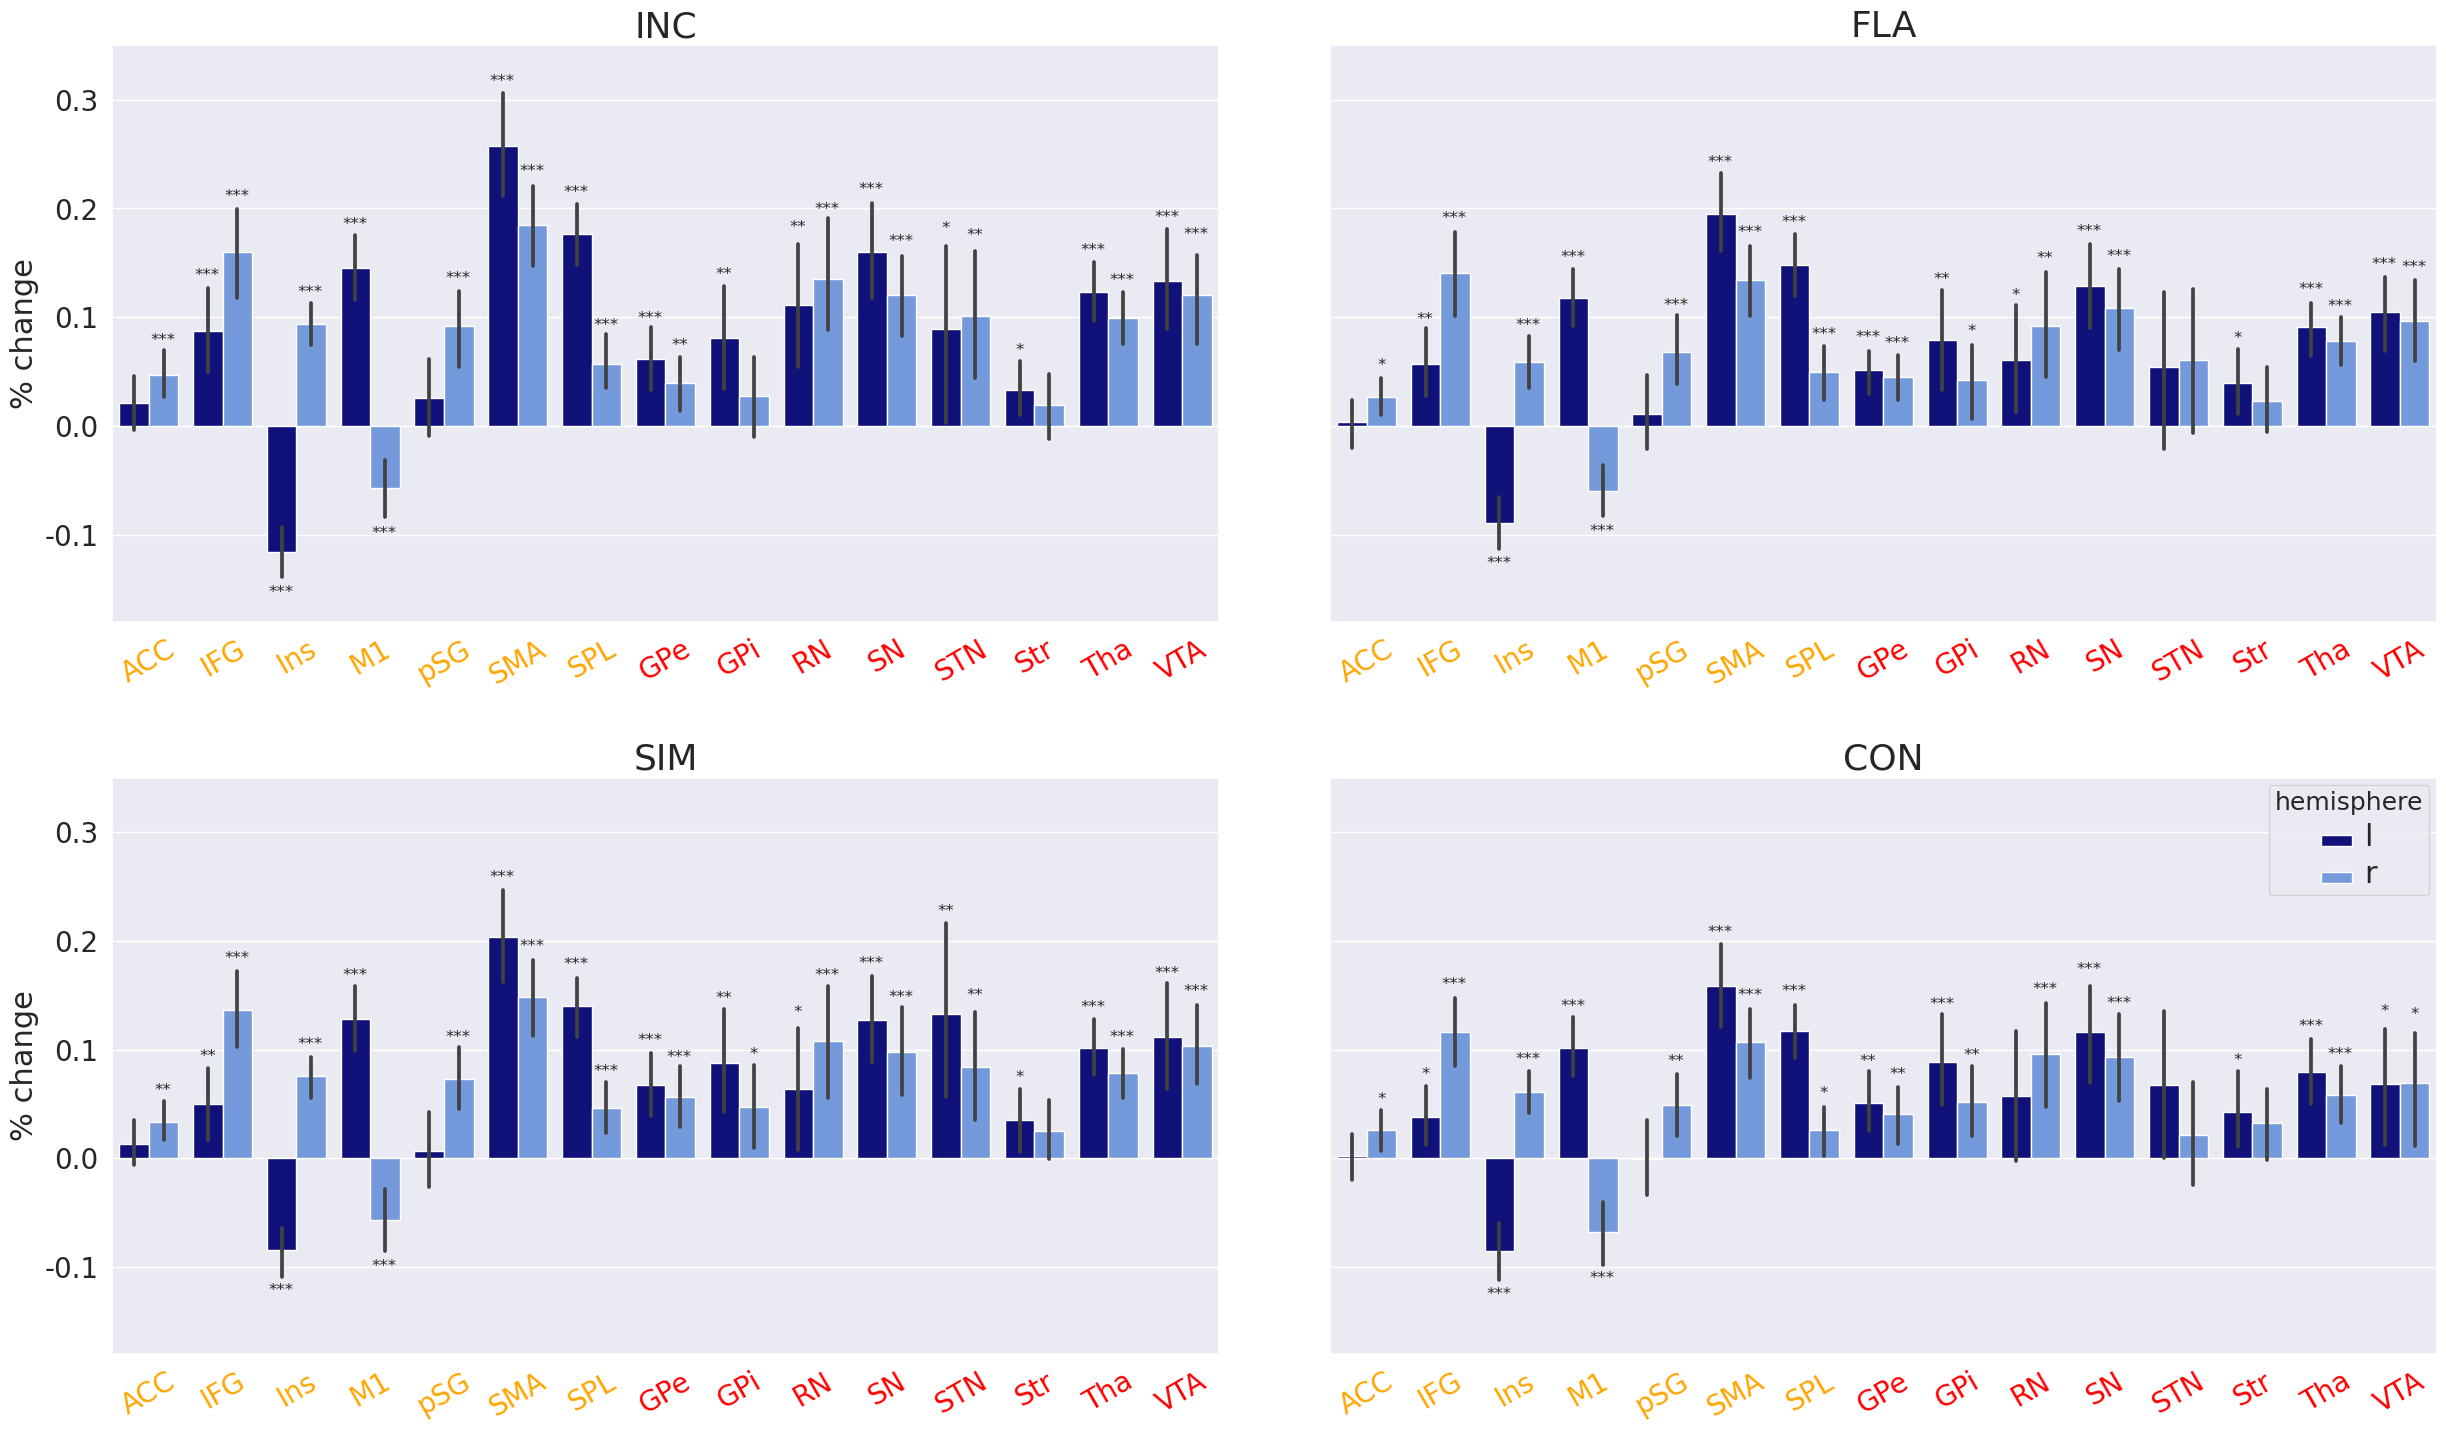

In [63]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)

sns.set_theme() # to make style changable from defaults use this line of code befor using set_style
with sns.axes_style("whitegrid"):
    ## 1
    sns.barplot(x='ROI_nohemi', y='beta_inc', hue='hemisphere', 
                data=betas_inc, ax=ax[0],palette=("darkblue","cornflowerblue"))
    sns.set(font_scale=1)
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('INC', fontsize=26)
    # ax[0].set(ylim=(-0.095,0.175))
    ax[0].set(ylim=(-0.18,0.35))
    add_asteriks(0, betas_inc, 'beta_inc', stat_inc['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    # plt.legend(loc='upper left')
    # plt.setp(ax[0].get_legend().get_texts(), fontsize='17') # for legend text
    # plt.setp(ax[0].get_legend().get_title(), fontsize='20') # for legend title
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_flanker', hue='hemisphere', 
                data=betas_flanker, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('FLA',fontsize=26)
    ax[1].set(ylim=(-0.18,0.35))
    add_asteriks(1, betas_flanker, 'beta_flanker', stat_flanker['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)

    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_simon', hue='hemisphere', 
                data=betas_simon, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change',fontsize=22)
    ax[2].set_xlabel('')
    ax[2].set_title('SIM',fontsize=26)
    ax[2].legend_.remove()
    ax[2].set(ylim=(-0.18,0.35))
    add_asteriks(2, betas_simon, 'beta_simon', stat_simon['significance'])
    # ax[0].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)

    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_con', hue='hemisphere', 
                data=betas_con, ax=ax[3],palette=("darkblue","cornflowerblue"))
    ax[3].set_ylabel('')
    ax[3].set_xlabel('')
#     ax[3].legend_.remove()
    ax[3].set_title('CON', fontsize=26)
    ax[3].set(ylim=(-0.18,0.35))
    add_asteriks(3, betas_con, 'beta_con', stat_con['significance'])
    ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation = 30,fontsize=20)
    plt.setp(ax[3].get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax[3].get_legend().get_title(), fontsize='18') # for legend title

    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

    f.savefig('figure_download_scott/GLM_ROI_MSIT_supplementary.pdf', bbox_inches='tight')

In [42]:
# load and save glm info for model based analysis
# absolute values for INC, SIMON and Flanker and INCONGRUENT trials for each region
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
inc_betas = subjectwise_betas.loc[(slice(None),['inc'], 'intercept', 'HRF')]              # Select only betas of interest
con_betas = subjectwise_betas.loc[(slice(None),['con'], 'intercept', 'HRF')]              # Select only betas of interest

inc_betas.to_csv('scott/inc_betas_tsv.tsv', sep='\t')
con_betas.to_csv('scott/con_betas_tsv.tsv', sep='\t')


In [37]:
inc_betas

ACC-l     ACC-r     GPe-l  \
subject event type covariate regressor                                 
002     inc        intercept HRF       -0.087310 -0.062181  0.079770   
003     inc        intercept HRF        0.061670  0.070442  0.147527   
004     inc        intercept HRF        0.032240  0.048413  0.105225   
005     inc        intercept HRF        0.058795  0.080811  0.065013   
006     inc        intercept HRF        0.027418  0.091983  0.044185   
007     inc        intercept HRF       -0.129032  0.013571  0.055421   
008     inc        intercept HRF        0.125549  0.241896 -0.007520   
009     inc        intercept HRF        0.045956  0.058695  0.027486   
010     inc        intercept HRF       -0.044652  0.005859 -0.126206   
011     inc        intercept HRF        0.189603  0.157714  0.096307   
012     inc        intercept HRF        0.075077  0.091577  0.047358   
013     inc        intercept HRF       -0.023153 -0.005195 -0.023173   
014     inc        intercept HRF        0.129580  0.123147  0.082930   
015     inc        intercept HRF       -0.121558 -0.035552 -0.049050   
016     inc        intercept HRF        0.055278  0.072196  0.025966   
017     inc        intercept HRF        0.054271  0.047749  0.049388   
018     inc        intercept HRF        0.025762  0.012924  0.156404   
019     inc        intercept HRF        0.041219  0.008308  0.262862   
020     inc        intercept HRF       -0.037944  0.044113  0.039406   
021     inc        intercept HRF       -0.037453  0.015702  0.044510   
023     inc        intercept HRF       -0.095820 -0.085229  0.260840   
024     inc        intercept HRF        0.008099  0.014874  0.201677   
025     inc        intercept HRF        0.033570  0.036365  0.005546   
026     inc        intercept HRF        0.082816  0.048428  0.018915   
027     inc        intercept HRF        0.104237  0.094657  0.088272   
029     inc        intercept HRF        0.028945  0.054801  0.070259   
031     inc        intercept HRF       -0.135910 -0.027363  0.034020   
032     inc        intercept HRF        0.104479  0.064881  0.032089   
033     inc        intercept HRF       -0.013817  0.020332  0.003594   
034     inc        intercept HRF        0.086224  0.117996  0.000596   
037     inc        intercept HRF        0.067680  0.126061 -0.091184   
038     inc        intercept HRF       -0.005836 -0.038027  0.071961   
039     inc        intercept HRF        0.031538  0.066119  0.062591   
040     inc        intercept HRF       -0.032996 -0.037811  0.167745   
042     inc        intercept HRF        0.052813  0.099729  0.047391   

                                           GPe-r     GPi-l     GPi-r  \
subject event type covariate regressor                                 
002     inc        intercept HRF        0.088368  0.113488  0.070838   
003     inc        intercept HRF        0.125974  0.256140  0.191174   
004     inc        intercept HRF       -0.020178  0.190999 -0.036178   
005     inc        intercept HRF        0.138107 -0.065724  0.150521   
006     inc        intercept HRF        0.053591  0.095394  0.086841   
007     inc        intercept HRF        0.130653  0.056847 -0.020122   
008     inc        intercept HRF        0.134980 -0.134620 -0.255965   
009     inc        intercept HRF        0.045094 -0.010850  0.126626   
010     inc        intercept HRF       -0.123398 -0.057566 -0.029146   
011     inc        intercept HRF        0.071005  0.559628  0.161360   
012     inc        intercept HRF        0.087116  0.032283  0.045481   
013     inc        intercept HRF        0.032944  0.082106 -0.100641   
014     inc        intercept HRF        0.052457  0.109600  0.056275   
015     inc        intercept HRF       -0.017794  0.057397 -0.046577   
016     inc        intercept HRF        0.045999  0.139283  0.094698   
017     inc        intercept HRF       -0.042096  0.081917 -0.001602   
018     inc        intercept HRF        0.143164  0.003670  0.106090   
019     in

# check IFG activation using HCP_MMP1 atlas instead of HarvardOxford (reviewers wants this for resubmission)

In [28]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [33]:
## Load timeseries
atlas_type = 'ALL'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/sub-*/ses-sstmsit/func/*task-sst*{atlas_type}*hp.tsv'))
signal_fns = [x for x in signal_fns if not any(s in x for s in to_remove)] # remove subs that didnt do task right
signal_fns

filter_out_confounds = True
filter_hp = False # already highpassed so no need

# excluded_runs = [('009', '2'), #] #,  # fell asleep
#                  ('010', '2'),  # physio failed   # TODO: find a better solution here!
#                  ('010', '3'),  # physio failed   # TODO: find a better solution here!
#                  ('018', '3')]  # physio failed   # TODO: find a better solution here!

excluded_runs=[('018','2'),
               ('025','2'),
               ('041','1')]

regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-sstmsit_task-sst_run-(?P<run>\d)_desc-{atlas_type}-signals_hp.tsv')
dfs = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t')
    gd = regex.match(signal_fn).groupdict()
    if tuple(gd.values()) in excluded_runs:
        # run was excluded
        continue
    
    if 'time' in signals.columns:
        # if there's a column named 'time', it's called 'time' but it's really volume number..
        signals = signals.rename(columns={'time': 'volume'})
    signals = signals.set_index('volume')
    
    # psc?
    signals = signals.apply(to_psc)  # to PSC

    # filter out confounds?
    if filter_out_confounds:
        _, confounds = load_events_confounds(sub=gd['sub'], ses='sstmsit', task='sst', run=gd['run'])
        confounds['intercept'] = 1   # add intercept!
        betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
        signals_hat = confounds@betas
        signals_hat.index = signals.index
        signals_hat.columns = signals.columns
        signals -= signals_hat   # residuals
        
    # high pass?
    if filter_hp:
        signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/1.38) + x.mean(), axis=0)
    
    # index to time
    signals.index *= 1.38
    signals.index.name = 'time'
    signals['subject'] = gd['sub']
    signals['run'] = int(gd['run'])
        
    signals = signals.reset_index().set_index(['subject', 'run', 'time'])
    dfs.append(signals)
df = pd.concat(dfs)
df = df.reindex(sorted(df.columns), axis=1)

if atlas_type == 'ALL':
    df.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r'}, inplace = True)
#     rois_ = sorted(['IFG-l','IFG-r','ACC-l','ACC-r','M1-l','M1-r','SMA-l','SMA-r','PaCG-l','PaCG-r','Ins-l','Ins-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r'])
    rois_ = ['ACC-l','ACC-r','IFGhcp-l','IFGhcp-r','Ins-l','Ins-r','M1-l','M1-r','pSG-l','pSG-r','SMA-l','SMA-r','SPL-l','SPL-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
             'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r']
    df = df[rois_]

df.head()

/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_1217929/1499602008.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

ACC-l     ACC-r  IFGhcp-l  IFGhcp-r     Ins-l     Ins-r  \
subject run time                                                               
002     1   0.00 -0.009046 -0.101348 -0.174902 -0.193623 -0.136296  0.198183   
            1.38 -0.020859 -0.044647  0.084273 -0.186487 -0.031983 -0.143250   
            2.76  0.200312  0.196895  0.069965  0.148055 -0.007479 -0.131002   
            4.14  0.032857  0.029978 -0.103398  0.131051 -0.068916 -0.512882   
            5.52  0.067664 -0.031241 -0.054624  0.385442  0.097771 -0.372230   

                      M1-l      M1-r     pSG-l     pSG-r  ...      SN-l  \
subject run time                                          ...             
002     1   0.00 -0.007650 -0.125184  0.264197 -0.062141  ... -0.262955   
            1.38 -0.215185  0.030254  0.066716 -0.125974  ...  0.344901   
            2.76 -0.271866 -0.131838 -0.228835 -0.138018  ...  0.003812   
            4.14 -0.070808  0.009410 -0.430733 -0.178713  ... -0.251174   
            5.52 -0.101638 -0.068051 -0.640710 -0.072168  ... -0.173772   

                      SN-r     STN-l     STN-r     Str-l     Str-r     Tha-l  \
subject run time                                                               
002     1   0.00 -0.074130 -0.119406  0.441403 -0.094972 -0.062583  0.158466   
            1.38 -0.048920 -0.258293 -1.430044  0.007171  0.001628 -0.166567   
            2.76 -0.099282  0.327440 -0.369066  0.227083  0.206010  0.071298   
            4.14  0.575009  0.119732 -0.777184  0.009512 -0.093968  0.094155   
            5.52  0.078624 -0.423674  0.314056  0.049936 -0.154472 -0.172399   

                     Tha-r     VTA-l     VTA-r  
subject run time                                
002     1   0.00  0.095141  0.077202  0.007022  
            1.38 -0.059774 -0.578531 -0.084204  
            2.76  0.228775 -0.773722 -0.430498  
            4.14  0.160933 -0.458024 -0.217064  
            5.52  0.084546 -0.225469 -0.186600  

[5 rows x 30 columns]

## load event, confounds

In [34]:
model_n = 'all_events'
all_events = []
all_confounds = []

for sub, run in df.reset_index().set_index(['subject', 'run']).index.unique():
    events, confounds = load_events_confounds(sub, 'sstmsit', 'sst', run, include_physio=True)
    events['subject'] = sub
    events['run'] = run
    confounds['subject'] = sub
    confounds['run'] = run
    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['subject', 'run'])
confounds = pd.concat(all_confounds).set_index(['subject', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})

events['duration'] = 0.001  # stick function

## glm function

In [35]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=1.38, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
#         if event_type in ['stimulus_value_difference', 'feedback_PE']:
#             glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
#         else:
        glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 19.32])

    glm1.fit(type=fit_type)
    return glm1

# fit event glm

In [36]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
    #     gm_nuclei = sorted(['IFG','ACC','M1','SMA','PaCG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'])
    gm_nuclei = ['ACC','IFGhcp','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_events = ['fs','ss','go']
glm1 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

## fit motor glm

In [37]:
if atlas_type == 'ATAG':
    gm_nuclei = ['M1', 'PreSMA', 'IFG'] #'ACC',
    include_rois = [hemi + roi for roi in gm_nuclei for hemi in ['l','r']]
    include_rois.remove('lIFG')
elif atlas_type=='MASSP':
    gm_nuclei = ['Amg', 'Cl', 'GPe', 'GPi', 'PAG', 'PPN', 'RN', 'SN', 'STN', 'Str', 'Tha', 'VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'CORT':
    gm_nuclei = ['ACC','aSG','IFG','Ins','PaCG','pCC','postcG','precC','precGy','pSG','SMA','SPL']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]
elif atlas_type == 'ALL':
#     gm_nuclei = sorted(['IFG','ACC','M1','SMA','PaCG','Ins','GPe','GPi','RN','SN','STN','Str','Tha','VTA'])
    gm_nuclei = ['ACC','IFGhcp','Ins','M1','pSG','SMA','SPL','GPe','GPi','RN','SN','STN','Str','Tha','VTA']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_events = ['response_left','response_right']
glm_m = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/hom

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past 

/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/.local/lib/python3.8/site-packages/nideconv/group_analysis.py:158: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/.local/lib/python3.8/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version

## plotting

In [38]:
import copy

glm1_ar1 = copy.deepcopy(glm1)

tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

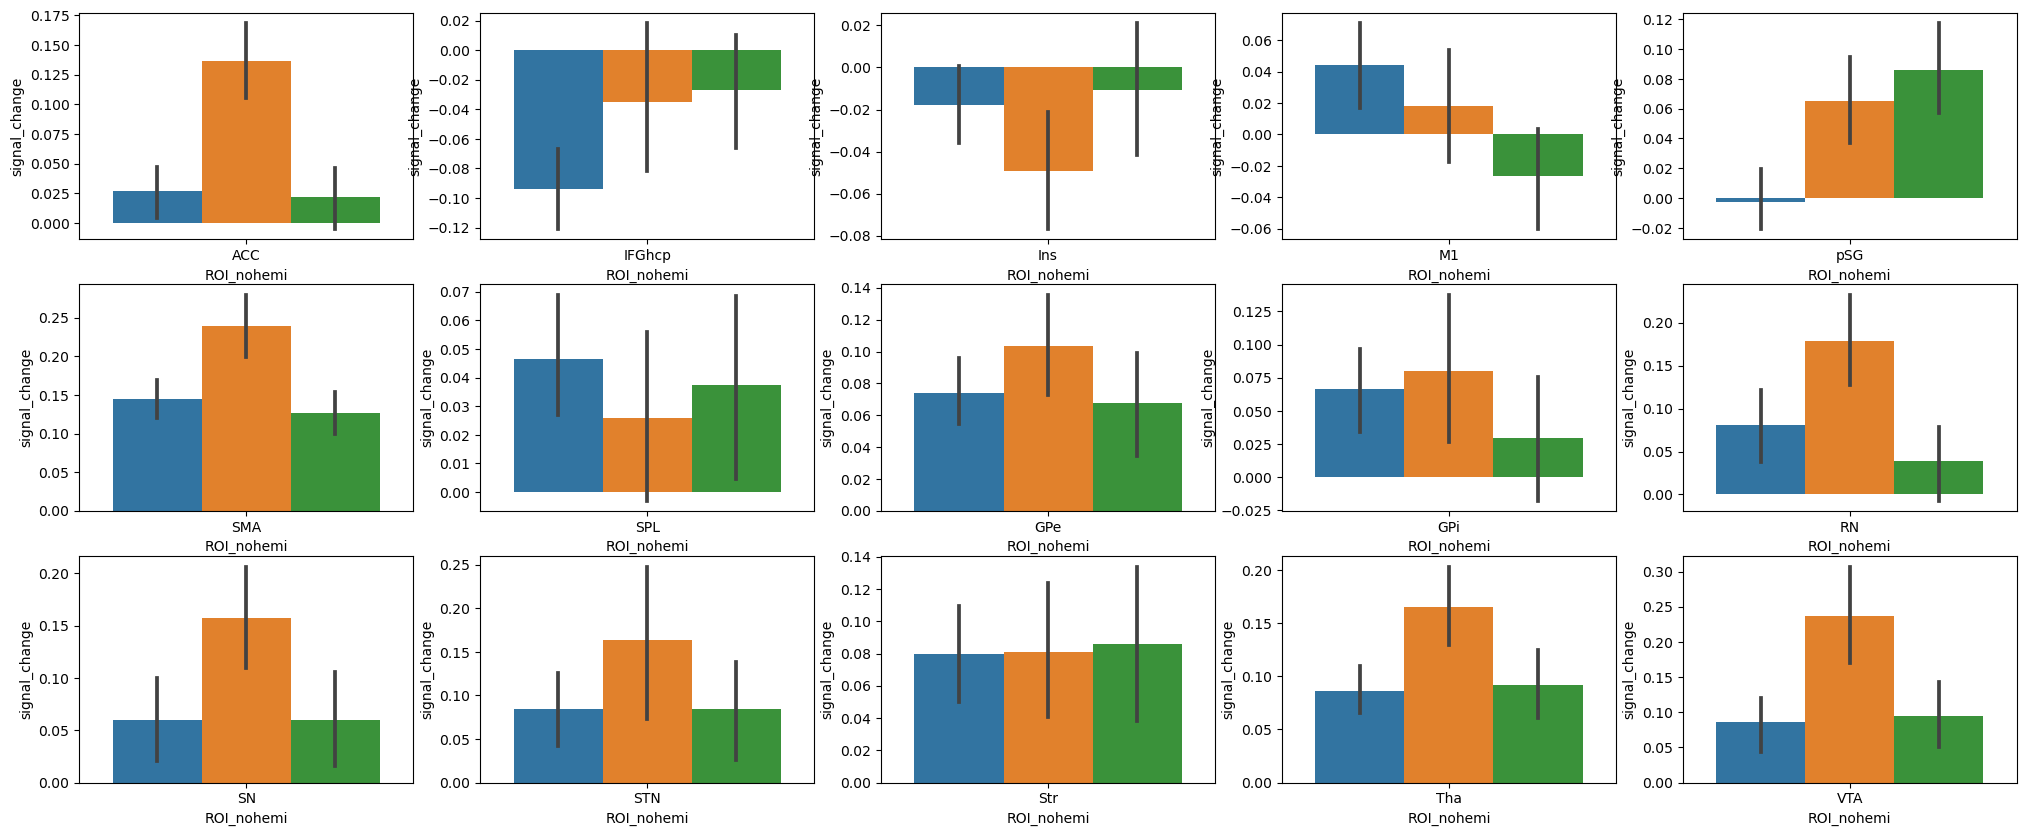

In [39]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, axes = plt.subplots(3,5,figsize=(25,10))

# for i, ax in zip(range(10), axes.flat):
#     sns.barplot(data[i,0,0,0], hist=False, ax=ax)
# plt.show()

ax = axes.ravel()


for i, r in enumerate(gm_nuclei):
    sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
                data=contrast_betas.loc[(contrast_betas.hemisphere=='l') & (contrast_betas.ROI_nohemi==r)], ax=ax[i])
    ax[i].legend_.remove()

# box_pairs = []
# for index in contrast_betas['ROI_nohemi'].unique():
#     box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'go', 'fs', 'ss'],2))[:3],2)))
    
# # box_pairs = box_pairs[:1]
# statannot.add_stat_annotation(
#     ax,
#     data=contrast_betas, 
#     x='ROI_nohemi',
#     y='signal_change',
#     hue='event type',
# #     hue_order=['go','fs','ss'],
#     box_pairs=box_pairs,
#     test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
#     text_format="star",
#     loc="inside",
# #     text_offset=-0.5,
# #     line_offset_to_box=-0.5,
# #     line_offset=-0.5,
# #     use_fixed_offset=True
# #     line_height=1
# )

# ax.set_ylabel('% change')
# ax.set_xlabel('ROI')



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

IFGhcp_fs v.s. IFGhcp_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.431e-01
Ins_go v.s. Ins_fs: t-test paired samples with Bonferroni correction, P_val=5.837e-02 stat=-3.373e+00
Ins_fs v.s. Ins_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=1.444e+00
M1_go v.s. M1_fs: t-test paired samples with Bonferroni correction, P_val=2.077e-01 stat=2.941e+00
M1_fs v.s. M1_ss: t-test paired samples with Bonferroni correction, P_val=1.051e-02 stat=3.911e+00
pSG_go v.s. pSG_fs: t-test paired samples with Bonferroni correction, P_val=5.917e-09 stat=-7.724e+00
pSG_fs v.s. pSG_ss: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=-9.667e-01
SMA_go v.s. SMA_fs: t-test paired samples with Bonferroni correction, P_val=4.183e-08 stat=-7.231e+00
SMA_fs v.s. SMA_ss: t-

Text(0.5, 80.7222222222222, 'ROI')

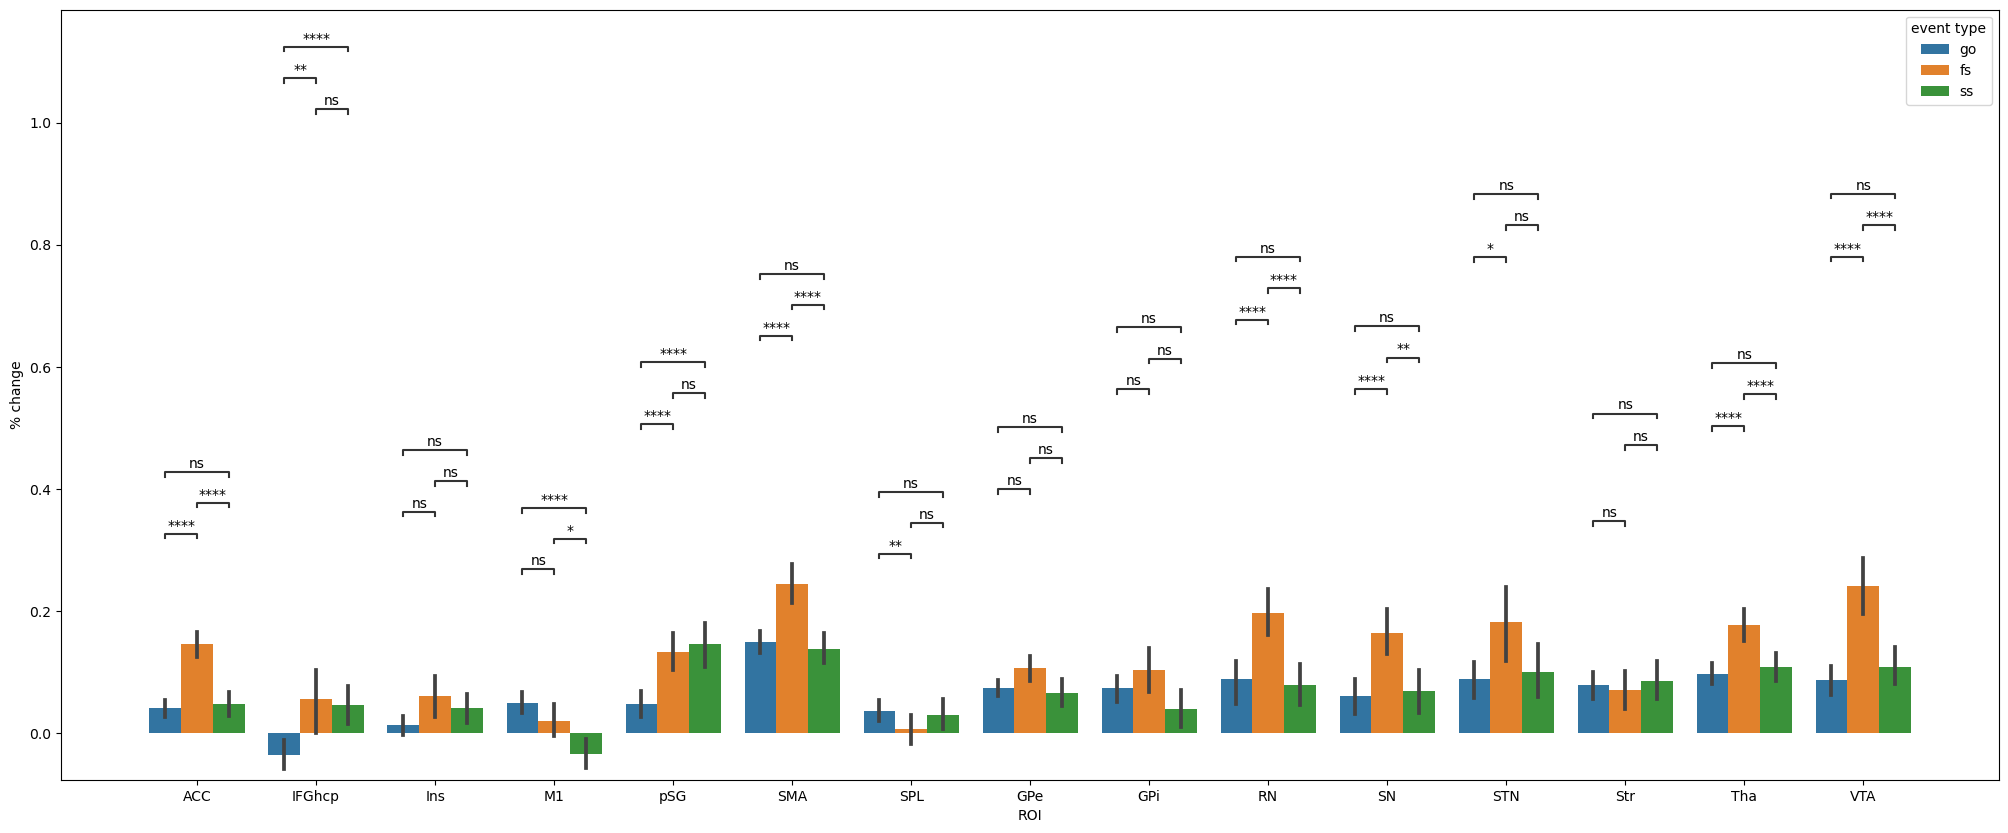

In [40]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(25,10))
sns.barplot(x='ROI_nohemi', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)

box_pairs = []
for index in contrast_betas['ROI_nohemi'].unique():
    box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'go', 'fs', 'ss'],2))[:3],2)))
    
# box_pairs = box_pairs[:1]
statannot.add_stat_annotation(
    ax,
    data=contrast_betas, 
    x='ROI_nohemi',
    y='signal_change',
    hue='event type',
#     hue_order=['go','fs','ss'],
    box_pairs=box_pairs,
    test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
    text_format="star",
    loc="inside",
#     text_offset=-0.5,
#     line_offset_to_box=-0.5,
#     line_offset=-0.5,
#     use_fixed_offset=True
#     line_height=1
)

ax.set_ylabel('% change')
ax.set_xlabel('ROI')



p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pSG-r_response_left v.s. pSG-r_response_right: t-test paired samples with Bonferroni correction, P_val=1.000e+00 stat=3.278e-01
SMA-l_response_left v.s. SMA-l_response_right: t-test paired samples with Bonferroni correction, P_val=6.298e-02 stat=-3.367e+00
SMA-r_response_left v.s. SMA-r_response_right: t-test paired samples with Bonferroni correction, P_val=1.895e-02 stat=3.816e+00
SPL-l_response_left v.s. SPL-l_response_right: t-test paired samples with Bonferroni correction, P_val=1.508e-04 stat=-5.543e+00
SPL-r_response_left v.s. SPL-r_response_right: t-test paired samples with Bonferroni correction, P_val=2.522e-08 stat=8.791e+00
GPe-l_response_left v.s. GPe-l_response_right: t-test paired samples with Bonferroni correction, P_val=2.171e-01 stat=-2.882e+00
GPe-r_response_left v.s. GPe-r_response_right: t-test paired samp

Text(0.5, 80.7222222222222, 'ROI')

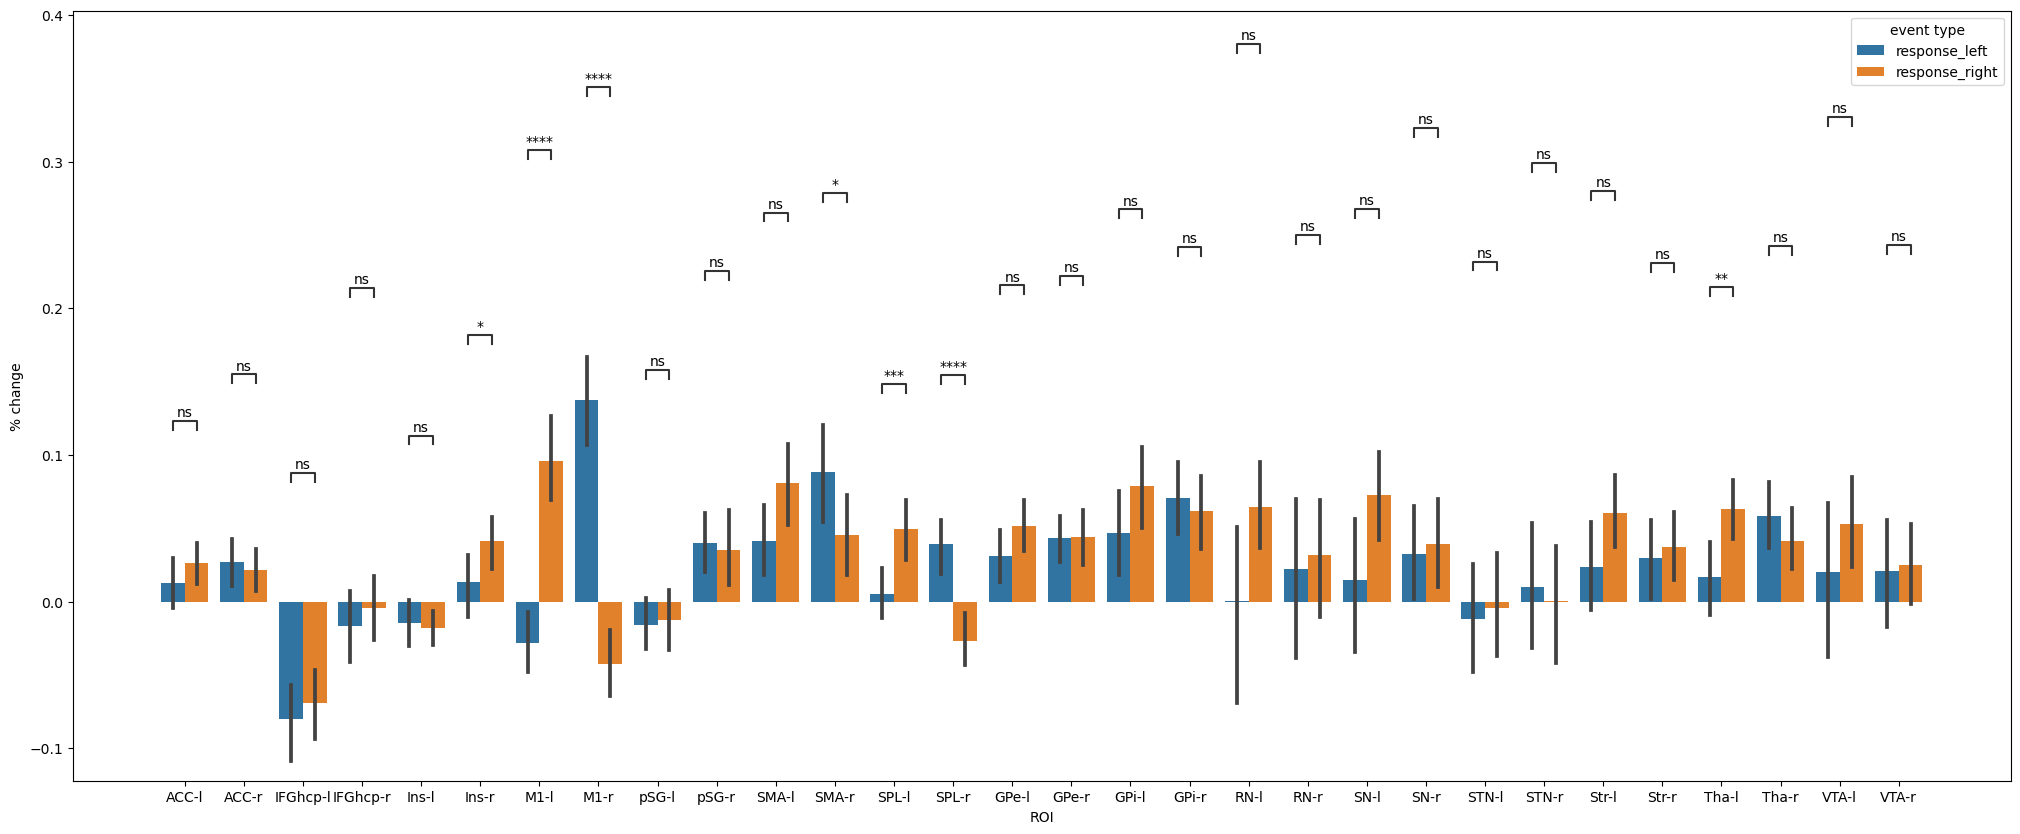

In [41]:
all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left','response_right'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas
contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='signal_change', ignore_index=False)
contrast_betas = contrast_betas.reset_index(level=1)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
    
f, ax = plt.subplots(1,1,figsize=(25,10))
sns.barplot(x='ROI', y='signal_change', hue='event type', 
            data=contrast_betas, ax=ax)

box_pairs = []
for index in contrast_betas['ROI'].unique():
    box_pairs = box_pairs + (list(itertools.combinations(list(itertools.combinations([index,'response_left','response_right'],2))[:2],2)))
    
# box_pairs = box_pairs[:1]
# print(box_pairs)
statannot.add_stat_annotation(
    ax,
    data=contrast_betas, 
    x='ROI',
    y='signal_change',
    hue='event type',
#     hue_order=['go','fs','ss'],
    box_pairs=box_pairs,
    test="t-test_paired", #options=['t-test_ind', 't-test_welch', 't-test_paired','Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls','Levene', 'Wilcoxon', 'Kruskal']
    text_format="star",
    loc="inside",
#     text_offset=-0.5,
#     line_offset_to_box=-0.5,
#     line_offset=-0.5,
#     use_fixed_offset=True
#     line_height=1
)

ax.set_ylabel('% change')
ax.set_xlabel('ROI')



In [42]:
# motor
all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
contrast_betas = contrast_betas.xs('response_right',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left', ignore_index=False)

if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

## recode to contralateral vs ipsilateral
contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1
contrast_betas_motor = contrast_betas.copy()

## event glms
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe

# fs - go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - go
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsgo = contrast_betas.copy()

# ss - fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - ss
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsss = contrast_betas.copy()

# go - ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference ss - go
contrast_betas = contrast_betas.xs('ss',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_ssgo = contrast_betas.copy()

##########
###########
###########
# now look just at absolute activtions with trial types
############

# fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline fs
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_fs = contrast_betas.copy()

# ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline ss
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_ss = contrast_betas.copy()

# go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline go
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_go = contrast_betas.copy()

# look at significance

In [43]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# absolute activation

In [44]:
tmp = betas_fs.groupby('ROI')['beta_fs'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fs = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_ss.groupby('ROI')['beta_ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_go.groupby('ROI')['beta_go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_go = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fs, stat_ss, stat_go = stat_fs.reindex(rois_), stat_ss.reindex(rois_), stat_go.reindex(rois_)

In [45]:
display_side_by_side(stat_fs,stat_ss,stat_go, titles=['fs','ss','go'])

fs 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 8.526662 
 1.630592e-09 
 True 
 0.0 
 *** 
 
 
 ACC-r 
 9.704810 
 9.150565e-11 
 True 
 0.0 
 *** 
 
 
 IFGhcp-l 
 -1.354476 
 1.856989e-01 
 False 
 0.206332 
 
 
 
 IFGhcp-r 
 3.530572 
 1.361528e-03 
 True 
 0.001857 
 ** 
 
 
 Ins-l 
 -3.256916 
 2.795461e-03 
 True 
 0.003646 
 ** 
 
 
 Ins-r 
 9.921369 
 5.496938e-11 
 True 
 0.0 
 *** 
 
 
 M1-l 
 0.989307 
 3.304253e-01 
 False 
 0.341819 
 
 
 
 M1-r 
 1.074134 
 2.913266e-01 
 False 
 0.312136 
 
 
 
 pSG-l 
 4.446152 
 1.106852e-04 
 True 
 0.000175 
 *** 
 
 
 pSG-r 
 8.359185 
 2.492159e-09 
 True 
 0.0 
 *** 
 
 
 SMA-l 
 10.808705 
 7.255222e-12 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 10.479962 
 1.518438e-11 
 True 
 0.0 
 *** 
 
 
 SPL-l 
 1.743491 
 9.148942e-02 
 False 
 0.105565 
 
 
 
 SPL-r 
 -0.764539 
 4.505181e-01 
 False 
 0.450518 
 
 
 
 GPe-l 
 6.159315 
 8.939575e-07 
 True 
 0.000002 
 *** 
 
 
 GPe-r 
 7.366893 
 3.309267e-08 
 True 
 0.0 
 *** 
 
 
 GPi-l 
 2.759877 
 9.762871e-03 
 True 
 0.012204 
 * 
 
 
 GPi-r 
 5.730639 
 2.966652e-06 
 True 
 0.000006 
 *** 
 
 
 RN-l 
 6.388309 
 4.734646e-07 
 True 
 0.000001 
 *** 
 
 
 RN-r 
 7.984091 
 6.529458e-09 
 True 
 0.0 
 *** 
 
 
 SN-l 
 6.126709 
 9.789503e-07 
 True 
 0.000002 
 *** 
 
 
 SN-r 
 5.682757 
 3.394137e-06 
 True 
 0.000006 
 *** 
 
 
 STN-l 
 3.632802 
 1.035962e-03 
 True 
 0.00148 
 ** 
 
 
 STN-r 
 4.975677 
 2.495267e-05 
 True 
 0.000042 
 *** 
 
 
 Str-l 
 3.657269 
 9.700575e-04 
 True 
 0.001455 
 ** 
 
 
 Str-r 
 2.537296 
 1.660616e-02 
 True 
 0.019927 
 * 
 
 
 Tha-l 
 8.528597 
 1.622652e-09 
 True 
 0.0 
 *** 
 
 
 Tha-r 
 10.625124 
 1.094047e-11 
 True 
 0.0 
 *** 
 
 
 VTA-l 
 6.606596 
 2.593838e-07 
 True 
 0.000001 
 *** 
 
 
 VTA-r 
 7.649856 
 1.563474e-08 
 True 
 0.0 
 *** 
 
 
 ss 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 1.711430 
 9.732380e-02 
 False 
 0.116789 
 
 
 
 ACC-r 
 5.930588 
 1.693083e-06 
 True 
 0.000007 
 *** 
 
 
 IFGhcp-l 
 -1.348528 
 1.875818e-01 
 False 
 0.208424 
 
 
 
 IFGhcp-r 
 6.087465 
 1.092141e-06 
 True 
 0.000005 
 *** 
 
 
 Ins-l 
 -0.652404 
 5.191085e-01 
 False 
 0.519109 
 
 
 
 Ins-r 
 6.519093 
 3.299773e-07 
 True 
 0.000002 
 *** 
 
 
 M1-l 
 -1.636216 
 1.122444e-01 
 False 
 0.129513 
 
 
 
 M1-r 
 -2.281128 
 2.980942e-02 
 True 
 0.038882 
 * 
 
 
 pSG-l 
 5.467689 
 6.220227e-06 
 True 
 0.000019 
 *** 
 
 
 pSG-r 
 7.075675 
 7.228926e-08 
 True 
 0.000001 
 *** 
 
 
 SMA-l 
 9.395391 
 1.915580e-10 
 True 
 0.0 
 *** 
 
 
 SMA-r 
 7.036004 
 8.046695e-08 
 True 
 0.000001 
 *** 
 
 
 SPL-l 
 2.299019 
 2.864407e-02 
 True 
 0.038882 
 * 
 
 
 SPL-r 
 1.162079 
 2.543653e-01 
 False 
 0.263137 
 
 
 
 GPe-l 
 3.974567 
 4.094709e-04 
 True 
 0.000819 
 *** 
 
 
 GPe-r 
 4.156152 
 2.481901e-04 
 True 
 0.00062 
 *** 
 
 
 GPi-l 
 1.171456 
 2.506360e-01 
 False 
 0.263137 
 
 
 
 GPi-r 
 2.543353 
 1.637225e-02 
 True 
 0.023389 
 * 
 
 
 RN-l 
 1.739440 
 9.220988e-02 
 False 
 0.115262 
 
 
 
 RN-r 
 4.581548 
 7.573010e-05 
 True 
 0.000207 
 *** 
 
 
 SN-l 
 2.555522 
 1.591146e-02 
 True 
 0.023389 
 * 
 
 
 SN-r 
 2.729835 
 1.050059e-02 
 True 
 0.01658 
 * 
 
 
 STN-l 
 2.862171 
 7.599055e-03 
 True 
 0.012665 
 * 
 
 
 STN-r 
 2.944356 
 6.196554e-03 
 True 
 0.010935 
 * 
 
 
 Str-l 
 3.687197 
 8.949662e-04 
 True 
 0.001678 
 ** 
 
 
 Str-r 
 3.996324 
 3.857229e-04 
 True 
 0.000819 
 *** 
 
 
 Tha-l 
 5.522006 
 5.337020e-06 
 True 
 0.000018 
 *** 
 
 
 Tha-r 
 7.651648 
 1.556112e-08 
 True 
 0.0 
 *** 
 
 
 VTA-l 
 4.024754 
 3.567161e-04 
 True 
 0.000819 
 *** 
 
 
 VTA-r 
 5.891357 
 1.889714e-06 
 True 
 0.000007 
 *** 
 
 
 go 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 2.416651 
 2.195535e-02 
 True 
 0.025333 
 * 
 
 
 ACC-r 
 5.807492 
 2.390737e-06 
 True 
 0.000008 
 *** 
 
 
 IFGhcp-l 
 -6.851895 
 1.326077e-07 
 True 
 0.000001

# contrast significance

In [46]:
tmp = contrast_betas_fsgo.groupby('ROI')['beta_fs-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_fsss.groupby('ROI')['beta_fs-ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_ssgo.groupby('ROI')['beta_ss-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ssgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_motor.groupby('ROI')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_leftright = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fsgo, stat_fsss, stat_ssgo, stat_leftright = stat_fsgo.reindex(rois_), stat_fsss.reindex(rois_), stat_ssgo.reindex(rois_), stat_leftright.reindex(rois_)

In [47]:
display_side_by_side(stat_leftright,stat_fsss,stat_fsgo,stat_ssgo, titles=['contra-ipsilateral','fs > ss','fs > go','ss > go'])

contra-ipsilateral 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 3.042800 
 4.838375e-03 
 True 
 0.014515 
 * 
 
 
 ACC-r 
 0.939770 
 3.548414e-01 
 False 
 0.560276 
 
 
 
 IFGhcp-l 
 1.082040 
 2.878557e-01 
 False 
 0.47976 
 
 
 
 IFGhcp-r 
 -1.134777 
 2.654544e-01 
 False 
 0.468449 
 
 
 
 Ins-l 
 -0.477748 
 6.362921e-01 
 False 
 0.75214 
 
 
 
 Ins-r 
 -3.896311 
 5.073384e-04 
 True 
 0.002537 
 ** 
 
 
 M1-l 
 8.397694 
 2.259826e-09 
 True 
 0.0 
 *** 
 
 
 M1-r 
 12.752959 
 1.201547e-13 
 True 
 0.0 
 *** 
 
 
 pSG-l 
 0.317495 
 7.530673e-01 
 False 
 0.806858 
 
 
 
 pSG-r 
 0.327754 
 7.453738e-01 
 False 
 0.806858 
 
 
 
 SMA-l 
 3.366747 
 2.099179e-03 
 True 
 0.006997 
 ** 
 
 
 SMA-r 
 3.815822 
 6.318010e-04 
 True 
 0.002708 
 ** 
 
 
 SPL-l 
 5.543322 
 5.025859e-06 
 True 
 0.000038 
 *** 
 
 
 SPL-r 
 8.791173 
 8.406340e-10 
 True 
 0.0 
 *** 
 
 
 GPe-l 
 2.881944 
 7.236596e-03 
 True 
 0.018339 
 * 
 
 
 GPe-r 
 -0.095110 
 9.248600e-01 
 False 
 0.92486 
 
 
 
 GPi-l 
 2.876456 
 7.335532e-03 
 True 
 0.018339 
 * 
 
 
 GPi-r 
 0.727088 
 4.728084e-01 
 False 
 0.675441 
 
 
 
 RN-l 
 2.272439 
 3.039068e-02 
 False 
 0.065123 
 
 
 
 RN-r 
 -0.504932 
 6.172962e-01 
 False 
 0.75214 
 
 
 
 SN-l 
 2.682392 
 1.177237e-02 
 True 
 0.027167 
 * 
 
 
 SN-r 
 -0.738376 
 4.660233e-01 
 False 
 0.675441 
 
 
 
 STN-l 
 0.455746 
 6.518544e-01 
 False 
 0.75214 
 
 
 
 STN-r 
 0.462233 
 6.472492e-01 
 False 
 0.75214 
 
 
 
 Str-l 
 3.408426 
 1.881407e-03 
 True 
 0.006997 
 ** 
 
 
 Str-r 
 -0.669999 
 5.079835e-01 
 False 
 0.692705 
 
 
 
 Tha-l 
 4.426936 
 1.167976e-04 
 True 
 0.000701 
 *** 
 
 
 Tha-r 
 2.143429 
 4.030644e-02 
 False 
 0.080613 
 
 
 
 VTA-l 
 1.463081 
 1.538443e-01 
 False 
 0.288458 
 
 
 
 VTA-r 
 -0.273650 
 7.862289e-01 
 False 
 0.81334 
 
 
 
 fs > ss 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 7.335465 
 3.598761e-08 
 True 
 0.000001 
 *** 
 
 
 ACC-r 
 6.129390 
 9.716653e-07 
 True 
 0.000015 
 *** 
 
 
 IFGhcp-l 
 -0.364526 
 7.180221e-01 
 False 
 0.769309 
 
 
 
 IFGhcp-r 
 0.761532 
 4.522848e-01 
 False 
 0.502539 
 
 
 
 Ins-l 
 -2.458063 
 1.996306e-02 
 True 
 0.033272 
 * 
 
 
 Ins-r 
 4.286869 
 1.726489e-04 
 True 
 0.000647 
 *** 
 
 
 M1-l 
 3.097197 
 4.214466e-03 
 True 
 0.009031 
 ** 
 
 
 M1-r 
 2.692892 
 1.147912e-02 
 True 
 0.021523 
 * 
 
 
 pSG-l 
 -1.558989 
 1.294873e-01 
 False 
 0.168896 
 
 
 
 pSG-r 
 -0.176105 
 8.613946e-01 
 False 
 0.861395 
 
 
 
 SMA-l 
 5.610310 
 4.161655e-06 
 True 
 0.000042 
 *** 
 
 
 SMA-r 
 5.127941 
 1.623199e-05 
 True 
 0.000106 
 *** 
 
 
 SPL-l 
 -0.828058 
 4.141768e-01 
 False 
 0.477896 
 
 
 
 SPL-r 
 -2.349062 
 2.560018e-02 
 True 
 0.040421 
 * 
 
 
 GPe-l 
 1.831623 
 7.695431e-02 
 False 
 0.104938 
 
 
 
 GPe-r 
 3.193037 
 3.297222e-03 
 True 
 0.007609 
 ** 
 
 
 GPi-l 
 1.409458 
 1.689824e-01 
 False 
 0.211228 
 
 
 
 GPi-r 
 2.914007 
 6.683286e-03 
 True 
 0.013367 
 * 
 
 
 RN-l 
 5.098762 
 1.762647e-05 
 True 
 0.000106 
 *** 
 
 
 RN-r 
 3.392736 
 1.960700e-03 
 True 
 0.004902 
 ** 
 
 
 SN-l 
 3.789825 
 6.780345e-04 
 True 
 0.001849 
 ** 
 
 
 SN-r 
 2.551259 
 1.607148e-02 
 True 
 0.028361 
 * 
 
 
 STN-l 
 1.863776 
 7.216707e-02 
 False 
 0.103096 
 
 
 
 STN-r 
 1.962936 
 5.898438e-02 
 False 
 0.088477 
 
 
 
 Str-l 
 -0.221926 
 8.258756e-01 
 False 
 0.854354 
 
 
 
 Str-r 
 -1.090363 
 2.842341e-01 
 False 
 0.341081 
 
 
 
 Tha-l 
 4.046809 
 3.356986e-04 
 True 
 0.001119 
 ** 
 
 
 Tha-r 
 3.820758 
 6.233774e-04 
 True 
 0.001849 
 ** 
 
 
 VTA-l 
 4.859640 
 3.461957e-05 
 True 
 0.000148 
 *** 
 
 
 VTA-r 
 4.902230 
 3.070036e-05 
 True 
 0.000148 
 *** 
 
 
 fs > go 
 
 
 
 t 
 p 
 fdr_significant 
 p_corrected 
 significance 
 
 
 
 
 ACC-l 
 8.399235 
 2.251001e-09 
 True 
 0.0 
 *** 
 
 
 ACC-r 
 8.255680 
 3.245059e-09 
 True 
 0.0 
 *** 
 
 
 IFGhcp-l 
 2.458205 
 1.995654e-02 

## plot all 4 contrasts

In [48]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need highest 

def add_asteriks(ax_n, data, col_name, significance=0):
    l_count, r_count = 0, 0
    
    
#     new = contrast_betas_inccon.groupby(['ROI_nohemi','hemisphere'])['beta_inc-con'].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     new = new.loc[sorted(new.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     roi_data = roi_data.loc[sorted(roi_data.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi')
#     roi_data_lower = roi_data_lower.loc[sorted(roi_data_lower.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
#     print(roi_data_lower)
#     for index, (y_val, region) in enumerate(zip(data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval), data.ROI.unique())):
    for index, (y_val, region, y_val_lower) in enumerate(zip(roi_data[col_name], data.ROI.unique(), roi_data_lower[col_name])):
#         print(significance)
#         print(region)
        if index%2 == 0:
            x_val = -0.26 + l_count
            l_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        else:
            x_val = 0.14 + r_count
            r_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        if y_val >= 0:
            ax[ax_n].text(x_val, y_val+0.005, significance[index])
        else:
            ax[ax_n].text(x_val, y_val_lower-0.017, significance[index])

/tmp/ipykernel_1217929/3602243325.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1217929/3602243325.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


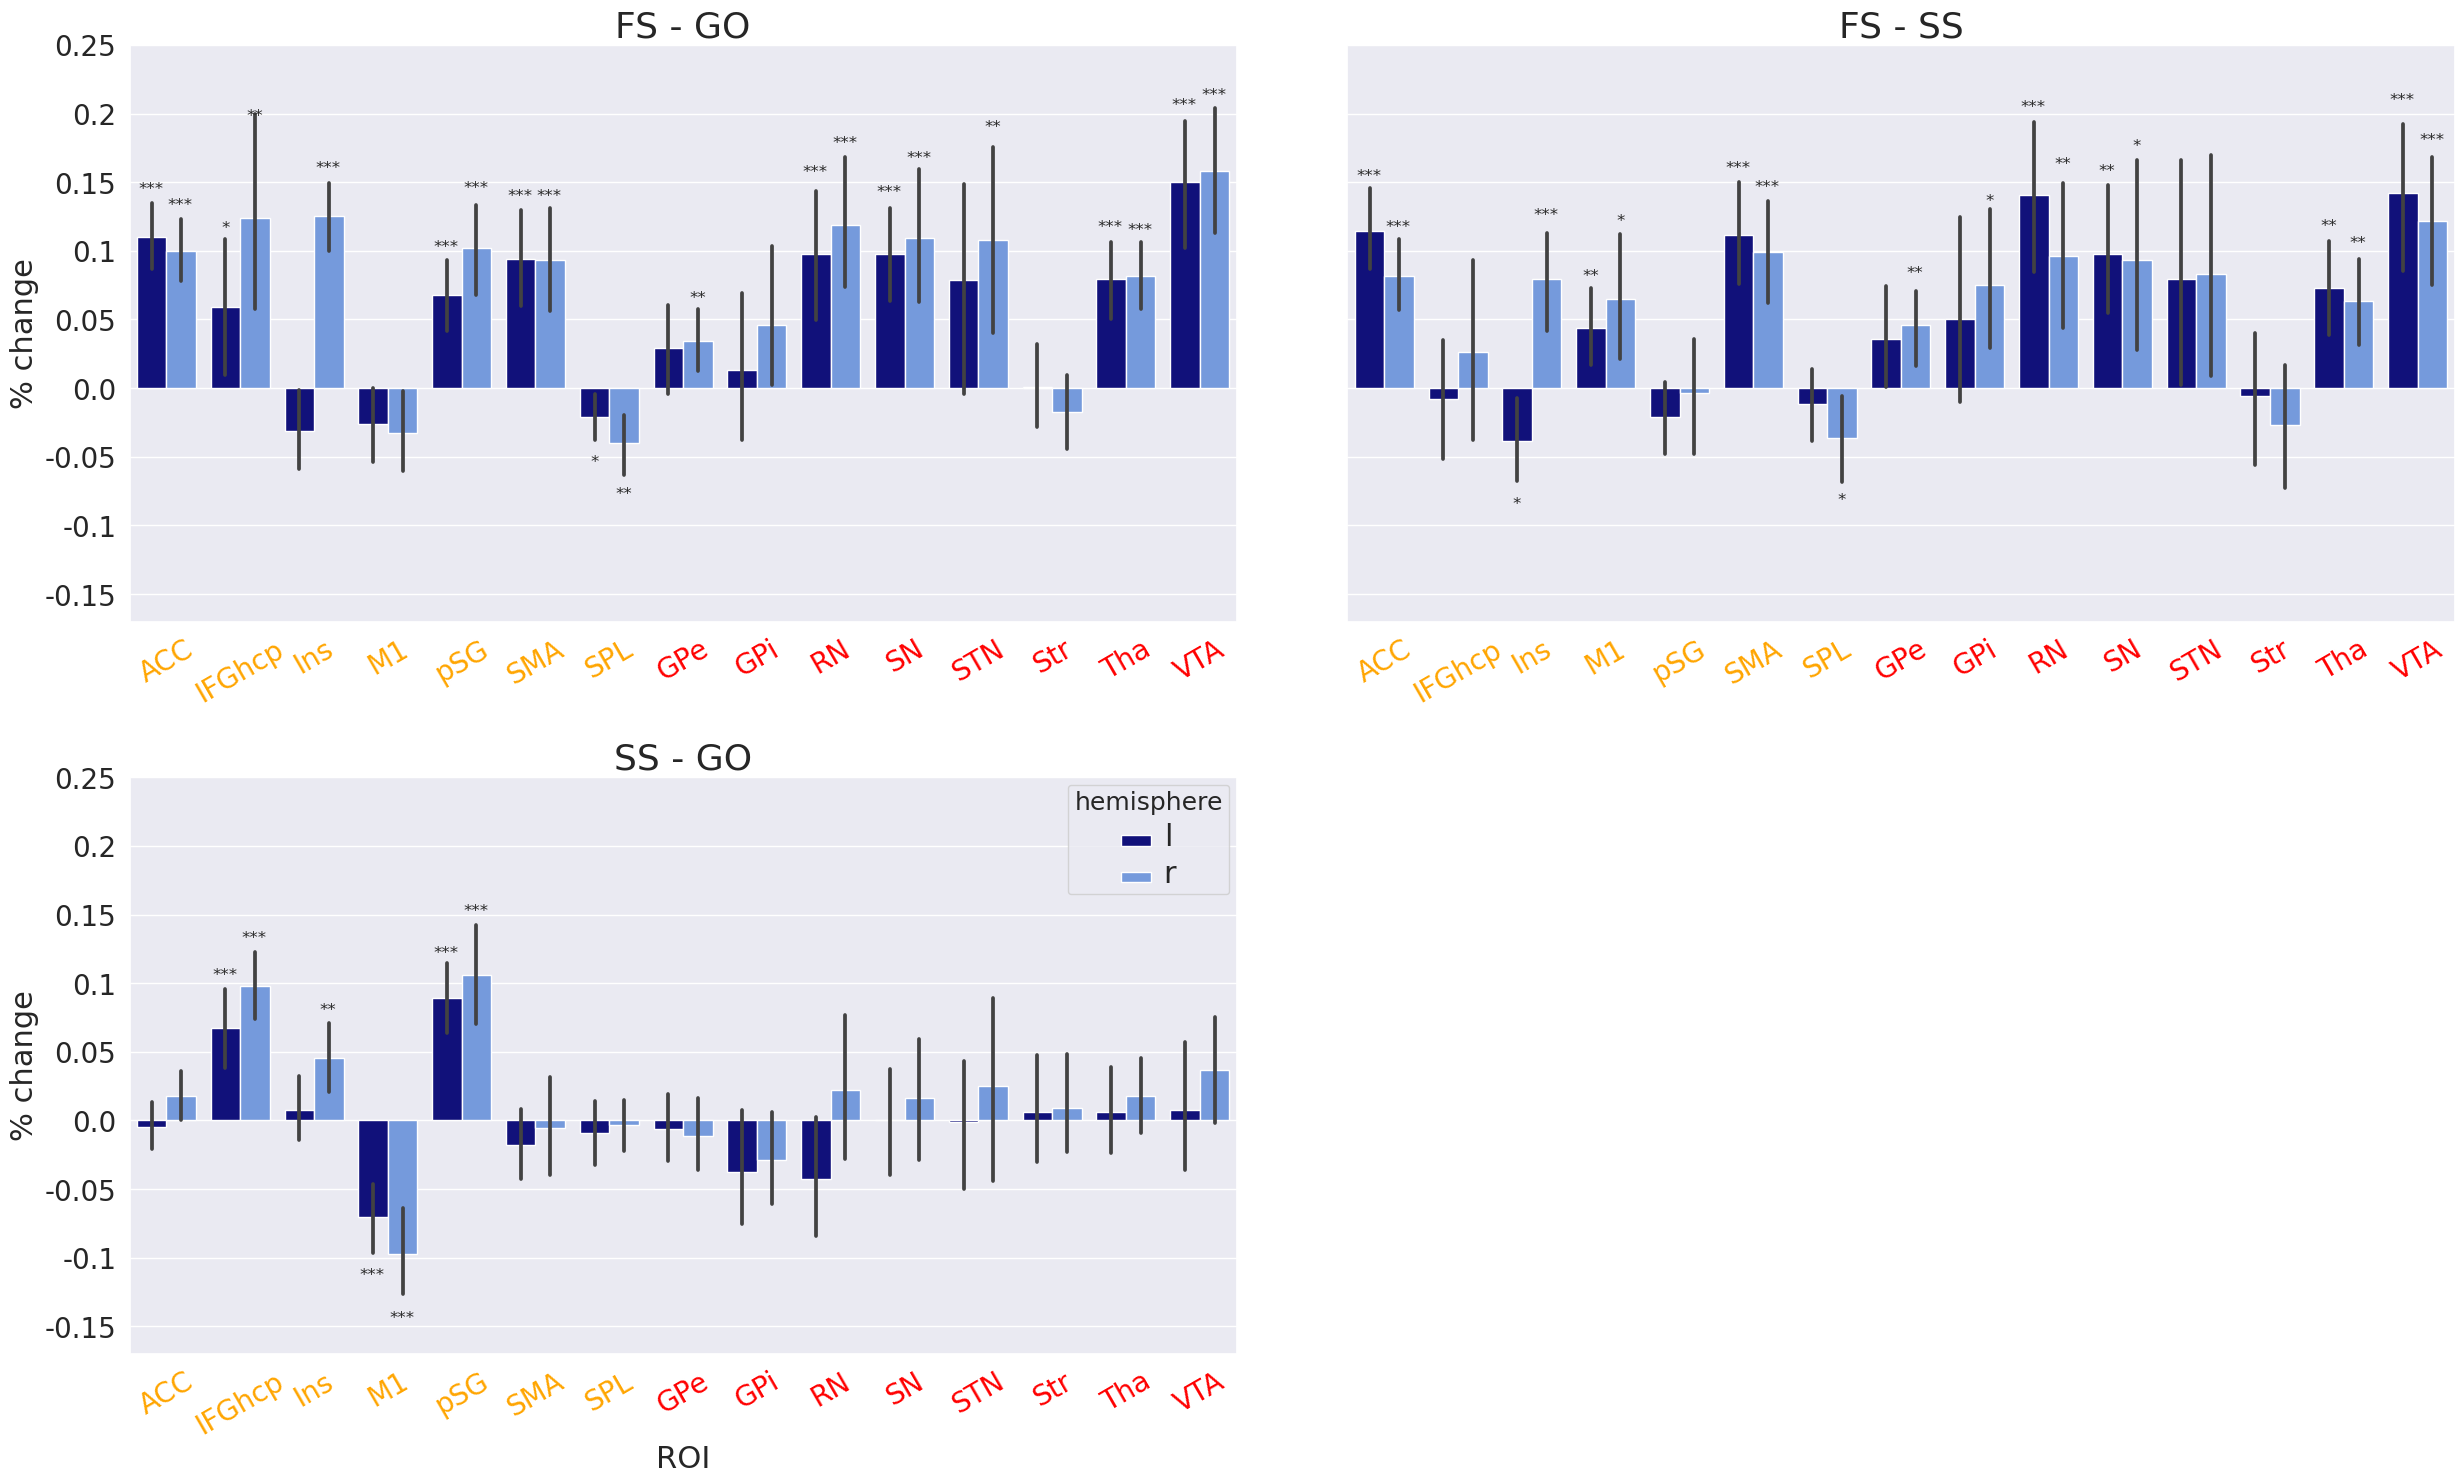

In [52]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

sns.set_theme() # to make style changable from defaults use this line of code befor using set_style
with sns.axes_style("darkgrid"):

#     # 1 ## MOTOR RESPONSE
#     sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
#                 data=contrast_betas_motor, ax=ax[0],palette=("darkblue","cornflowerblue"))
#     ax[0].set_ylabel('% change', fontsize=22)
#     ax[0].set_xlabel('')
#     ax[0].legend_.remove()
#     ax[0].set_title('Contralateral - ipsilateral', fontsize=26)
#     ax[0].set(ylim=(-0.17,0.25))
#     add_asteriks(0, contrast_betas_motor, 'beta_contra-ipsi', stat_leftright['significance'])
#     # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
#     ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_fs-go', hue='hemisphere', 
                data=contrast_betas_fsgo, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS - GO', fontsize=26)
    ax[0].set(ylim=(-0.17,0.25))
    add_asteriks(0, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)

    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_fs-ss', hue='hemisphere', 
                data=contrast_betas_fsss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('FS - SS', fontsize=26)
    ax[1].set(ylim=(-0.17,0.25))
    add_asteriks(1, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)

    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_ss-go', hue='hemisphere', 
                data=contrast_betas_ssgo, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[3].legend_.remove()
    ax[2].set_title('SS - GO', fontsize=26)
    ax[2].set(ylim=(-0.17,0.25))
    add_asteriks(2, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    plt.setp(ax[2].get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax[2].get_legend().get_title(), fontsize='18') # for legend title

    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].axis('off')


    f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

/tmp/ipykernel_1217929/1157392251.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1217929/1157392251.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


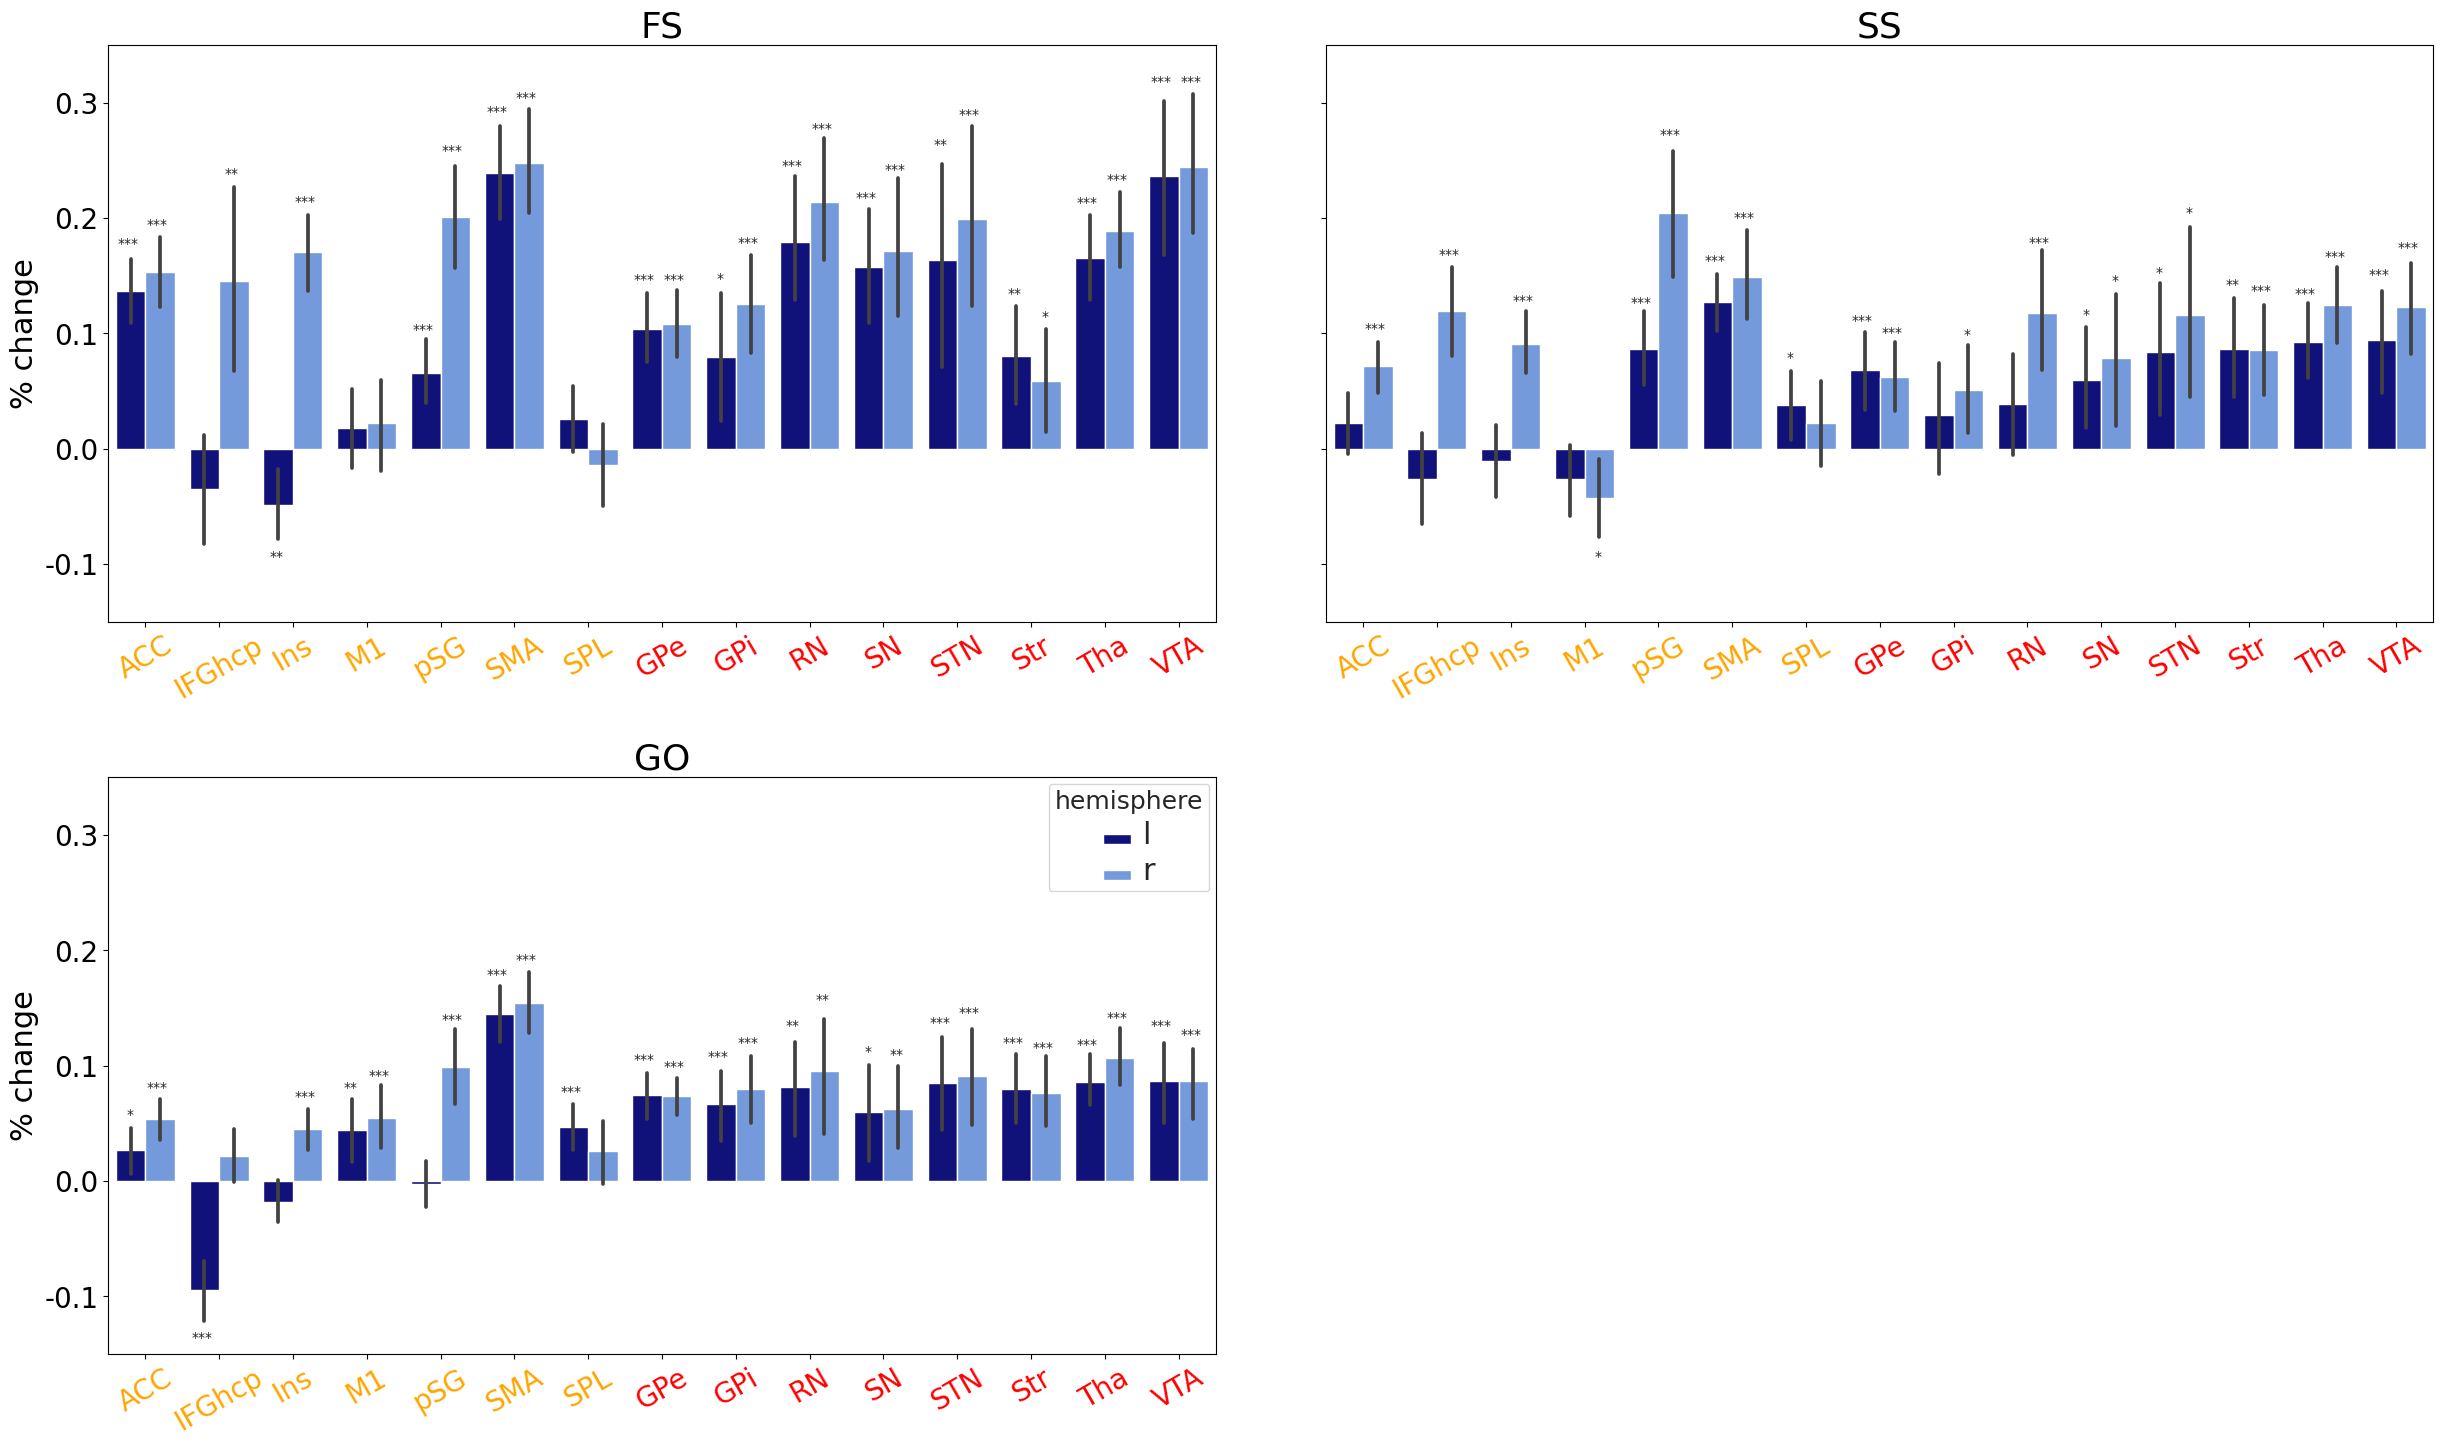

In [50]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    ## 1 ## FS
    sns.barplot(x='ROI_nohemi', y='beta_fs', hue='hemisphere', 
                data=betas_fs, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS', fontsize=26)
    ax[0].set(ylim=(-0.15,0.35))
    add_asteriks(0, betas_fs, 'beta_fs', stat_fs['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2 SS
    sns.barplot(x='ROI_nohemi', y='beta_ss', hue='hemisphere', 
                data=betas_ss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('SS', fontsize=26)
    ax[1].set(ylim=(-0.15,0.35))
    add_asteriks(1, betas_ss, 'beta_ss', stat_ss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)

    ## 3 GO
    sns.barplot(x='ROI_nohemi', y='beta_go', hue='hemisphere', 
                data=betas_go, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('GO', fontsize=26)
    ax[2].set(ylim=(-0.15,0.35))
    add_asteriks(2, betas_go, 'beta_go', stat_go['significance'])
    # ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    plt.setp(ax[2].get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax[2].get_legend().get_title(), fontsize='18') # for legend title
    
    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].set_visible(False)
    
    f.savefig('figure_download_scott/GLM_ROI_SST_supplementary.pdf', bbox_inches='tight')

# OLD SHIT

## PIck an atlas, have a quick look at each subject

In [4]:
# load confounds, events, timeseries and sort
df = load_timeseries(atlas_type='THAL', ses='sstmsit', task='msit')

events, df, confounds = sort_data(df)

No retroicor found sub-007 run-1, including 20 a_comp_cor components


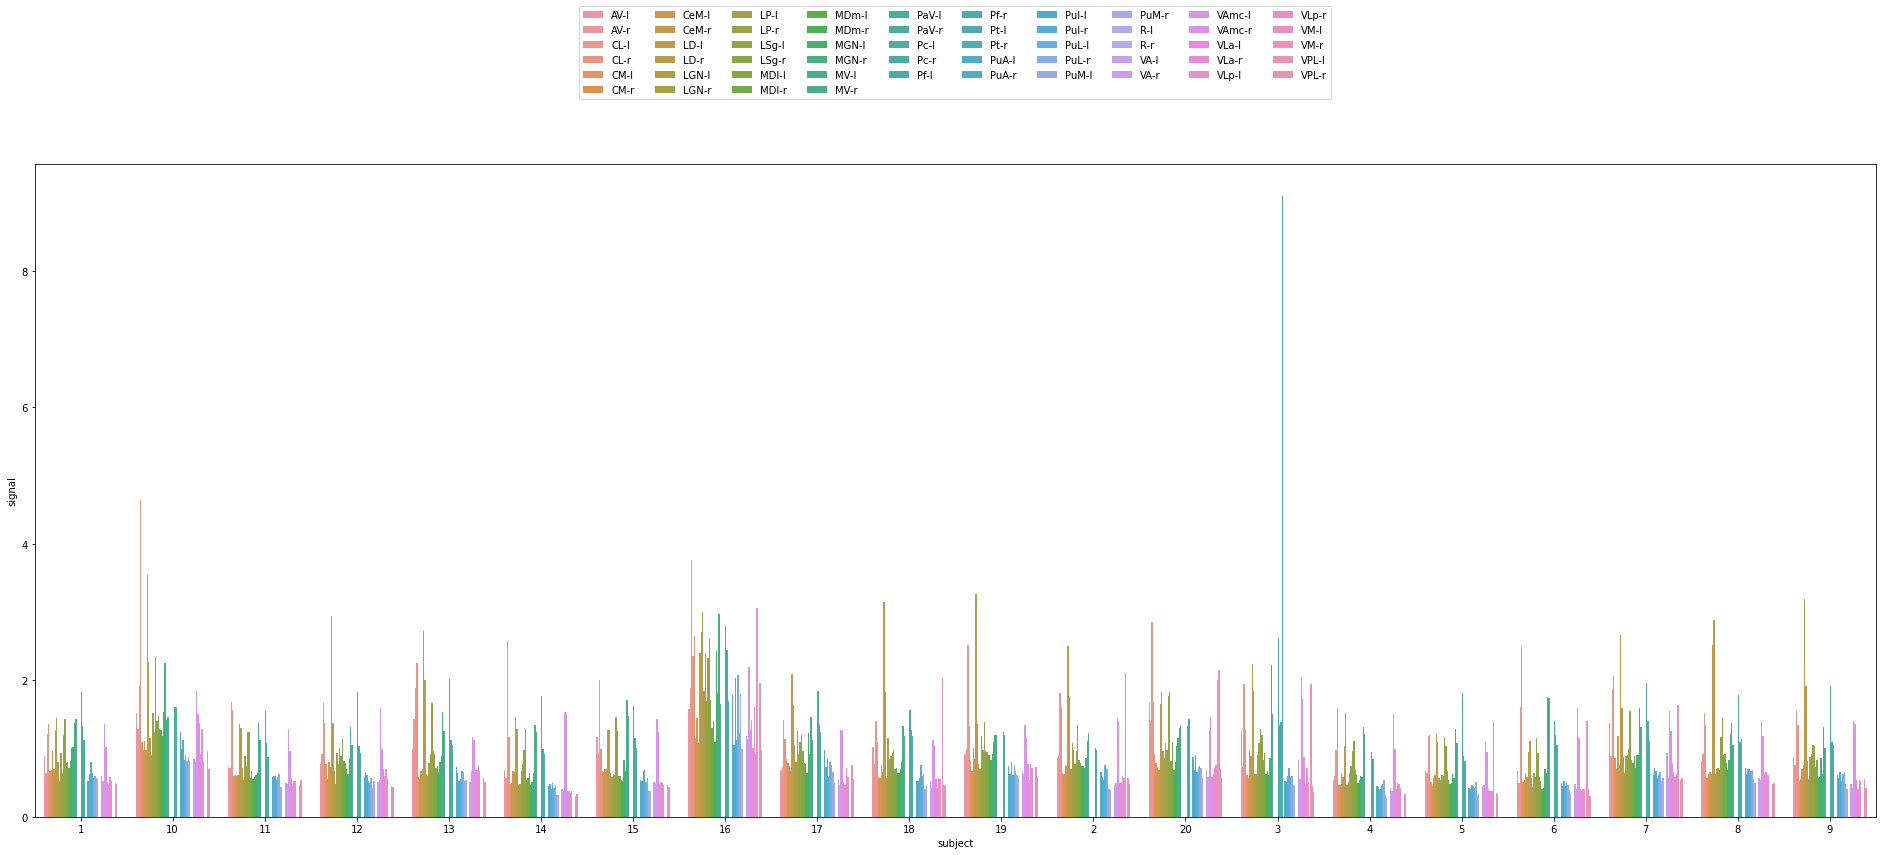

In [7]:
df_long = df.reset_index().reset_index() #.set_index(['sub', 'run', 'time', 'index']) #_long #df.reset_index()#.melt(index_vars=['sub', 'run', 'time'])
df_long = df_long.melt(id_vars=['subject', 'run', 'time','index'], value_name='signal', var_name='ROI')

df_long['hemisphere'] = df_long['ROI'].str.split('-').apply(lambda x: x[-1])
df_long['roi_nohemi'] = df_long['ROI'].str.split('-').apply(lambda x: x[0])
df_long.loc[~df_long.hemisphere.isin(['l', 'r']), 'hemisphere'] = 'lr'

# plot
# g = sns.FacetGrid(data=df_long.reset_index(), row='roi_nohemi', col='hemisphere', hue='subject', sharey=False)
# g.map(sns.lineplot, 'index', 'signal')
# plt.gcf().set_size_inches(20,15*3)
#plt.plot(df['Amg-r'].values) #.groupby(level=[0,1]).mean()

# One subject has no right claustrum voxels
df_long.loc[(df_long['subject']=='006') & (df_long['ROI'] == 'Cl-r'),'signal'] = 0

all_sds = df_long.groupby(['subject', 'ROI'])['signal'].apply(np.std).reset_index()

sns.barplot(x='subject', y='signal', hue='ROI', data=all_sds)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=10)

plt.gcf().set_size_inches(33,12)

# Create timeseries maps and correlation matrices between extraction methods

In [5]:
subs = [s.replace('sub-','') for s in [x.split('/')[-1] for x in sorted(glob.glob('../derivatives/extracted_signals/sub*'))]]
params = [('MASSP',True,True,'man_hp'),
          ('MASSP',True,False,'man'),
          ('MASSP',False,False,'nilearn')]

make_figs(subs,ses='sstmsit',task='msit',params=params, overwrite=False)

ValueError: No objects to concatenate

# OLD SHIZZLEEE

In [ ]:
tc_subs = tc.loc[(tc['event type'] == 'inc')] # & (tc['covariate'] == 'covariate')]

roi = 'STN-r'
for subject in tc_subs.subject.unique():
    idx = (tc_subs['subject']==subject) & (tc_subs['roi'] == roi)
    plt.plot(tc_subs.loc[idx, 'time'], tc_subs.loc[idx, 'signal'], alpha=0.3)

group_mean = tc_subs.loc[tc_subs['roi'] == roi].groupby(['time'])['signal'].mean()
plt.plot(tc_subs.loc[idx, 'time'], group_mean, color='k')
plt.axhline(0, color='k')

<Figure size 640x480 with 0 Axes>

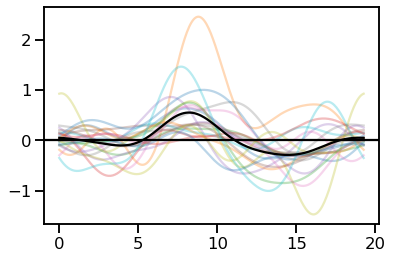

<Figure size 640x480 with 0 Axes>

In [23]:
tc_subs = tc.loc[(tc['event type'] == 'inc')] # & (tc['covariate'] == 'covariate')]

roi = 'STN-l'
for subject in tc_subs.subject.unique():
    idx = (tc_subs['subject']==subject) & (tc_subs['roi'] == roi)
    plt.plot(tc_subs.loc[idx, 'time'], tc_subs.loc[idx, 'signal'], alpha=0.3)

group_mean = tc_subs.loc[tc_subs['roi'] == roi].groupby(['time'])['signal'].mean()
plt.plot(tc_subs.loc[idx, 'time'], group_mean, color='k')
plt.axhline(0, color='k')
figure(figsize=(8, 6), dpi=80)


In [30]:
## Load timeseries
atlas_type = 'ATAG'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/sub-*/ses-sstmsit/func/*task-msit*{atlas_type}*.tsv'))
#signal_fns = sorted(glob.glob('../derivatives/extracted_signals/sub-*/ses-rlsat/func/*rlsat*.tsv'))
signal_fns

regex = re.compile(f'.*sub-(?P<sub>\d+)_ses-sstmsit_task-msit_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
dfs = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t')
    gd = regex.match(signal_fn).groupdict()
#     if gd['sub'] == '010' and gd['run'] == '3':
#         continue
    
    if 'time' in signals.columns:
        signals = signals.rename(columns={'time': 'volume'})
#    signals = signals.set_index(['volume']).apply(to_psc).reset_index()  # to PSC
    signals['time'] = signals['volume'] * 1.38
    del signals['volume']
    signals['sub'] = gd['sub']
    signals['run'] = int(gd['run'])
    signals = signals.set_index(['sub', 'run', 'time'])
    dfs.append(signals)
df = pd.concat(dfs)
# df = df.set_index(['sub', 'run', 't'])
df.head()

ACC            M1           THA         lGPe  \
sub run time                                                          
002 1   0.00  14630.982695  16121.369361  11547.302494  7653.938010   
        1.38  14595.463951  15985.604112  11536.035410  7640.127922   
        2.76  14537.876889  16028.774022  11556.363461  7680.195650   
        4.14  14578.018211  16033.329769  11534.748109  7676.869520   
        5.52  14580.667999  16044.575262  11552.899271  7681.381261   

                     lGPi           lLC           lM1       lPreSMA  \
sub run time                                                          
002 1   0.00  8610.895524  10435.293744  16617.337974  14646.077506   
        1.38  8566.442344  10368.628821  16462.785200  14545.518844   
        2.76  8683.219813  10689.770592  16505.142349  14572.657703   
        4.14  8639.640612  10442.979005  16509.551495  14614.395575   
        5.52  8625.497753  10365.915145  16515.451235  14613.738365   

                      lSN         lSTN  ...         rGPe         rGPi  \
sub run time                            ...                             
002 1   0.00  7172.119167  8422.172797  ...  7393.267249  8148.157558   
        1.38  7161.515964  8366.976211  ...  7390.923188  8104.850719   
        2.76  7107.546337  8469.061212  ...  7421.485704  8180.192603   
        4.14  7180.556909  8523.122793  ...  7400.421330  8121.562738   
        5.52  7177.258555  8381.584220  ...  7413.757815  8129.626616   

                      rIFG           rLC           rM1       rPreSMA  \
sub run time                                                           
002 1   0.00  11817.176098  10348.300952  15723.026552  13203.339447   
        1.38  11805.127751  10241.996615  15602.350717  13050.397125   
        2.76  11782.624660  10462.957880  15646.173405  13071.900350   
        4.14  11803.255000  10227.285665  15650.846897  13102.014142   
        5.52  11805.032344  10260.444462  15666.385892  13105.614827   

                      rSN         rSTN         rSTR         rVTA  
sub run time                                                      
002 1   0.00  7212.398191  8500.133588  9773.736423  9453.464229  
        1.38  7183.243786  8426.342496  9751.760401  9460.950260  
        2.76  7199.489010  8465.216275  9758.674515  9539.806532  
        4.14  7237.443392  8534.769006  9767.629809  9461.884150  
        5.52  7175.216037  8372.757549  9761.769596  9438.175746  

[5 rows x 22 columns]

In [46]:
df

3V            4V         Amg-l        Amg-r  \
subject run time                                                            
1       1   0.00    10197.430147   9943.450148  11188.610580  9890.704658   
            1.38    10124.353897   9994.907296  11122.565411  9808.398339   
            2.76    10178.263604   9820.188720  11085.107519  9804.673792   
            4.14    10188.538902   9813.459582  10975.920634  9805.267918   
            5.52    10182.953269   9766.082256  11105.228261  9849.431331   
...                          ...           ...           ...          ...   
35      2   764.52   7452.437024  10235.034646   9783.582290  9879.246114   
            765.90   7438.197192  10189.668414   9785.475007  9909.909765   
            767.28   7374.506457  10206.412139   9767.070797  9860.438736   
            768.66   7416.209582  10161.375610   9817.419001  9933.209755   
            770.04   7502.188092  10040.528091   9815.368719  9854.322042   

                            Cl-l          Cl-r        GPe-l        GPe-r  \
subject run time                                                           
1       1   0.00    12063.889500  11224.693382  7198.222403  6807.215326   
            1.38    12015.361079  11228.357402  7146.181970  6762.084441   
            2.76    12057.678145  11221.461103  7179.327834  6775.917031   
            4.14    12067.687262  11300.426001  7190.800415  6824.218897   
            5.52    12059.260794  11266.270518  7159.775108  6790.704894   
...                          ...           ...          ...          ...   
35      2   764.52  11195.929259  10623.992329  6410.740038  6625.977537   
            765.90  11167.509379  10633.311095  6401.115588  6615.826439   
            767.28  11203.489858  10612.263779  6390.247583  6586.831411   
            768.66  11251.088545  10609.992945  6453.035870  6628.616783   
            770.04  11257.373507  10633.928521  6466.329208  6642.505569   

                          GPi-l        GPi-r  ...        STN-r         Str-l  \
subject run time                              ...                              
1       1   0.00    7740.666047  6364.868727  ...  5764.665190  10825.129166   
            1.38    7722.772482  6313.872622  ...  5581.822619  10816.109516   
            2.76    7817.733843  6363.942357  ...  5615.314861  10839.946511   
            4.14    7824.852075  6393.705984  ...  5684.042428  10852.725878   
            5.52    7738.878153  6330.373653  ...  5723.030977  10822.614108   
...                         ...          ...  ...          ...           ...   
35      2   764.52  6667.079285  6751.147131  ...  5847.878488  10039.559254   
            765.90  6648.906118  6704.271174  ...  5935.150600  10044.757252   
            767.28  6628.421632  6651.016736  ...  5901.501639  10076.376048   
            768.66  6666.917800  6728.552551  ...  5753.874360  10132.608801   
            770.04  6671.920961  6695.877913  ...  5881.356268  10122.450044   

                           Str-r         Tha-l         Tha-r        VTA-l  \
subject run time                                                            
1       1   0.00     9784.507332  11191.691844  11491.260882  9292.457501   
            1.38     9778.667056  11132.577273  11447.170442  9216.518954   
            2.76     9798.219988  11168.524496  11489.511279  9174.344972   
            4.14     9804.466475  11195.419240  11511.335855  9221.745091   
            5.52     9770.282329  11128.365451  11456.953403  9240.065267   
...                          ...           ...           ...          ...   
35      2   764.52   9990.295051   9014.344306   9782.611014  7393.519201   
            765.90   9996.612526   9008.454830   9777.963717  7359.615674   
            767.28  10013.964307   8989.894491   9778.197563  7392.565035   
            768.66  10057.860451   8998.376141   9834.714587  7398.593010   
            770.04  10062.429818   9049.405524   9852.601258  7406.198013 

In [31]:


def load_events_confounds(sub, ses, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
#    regressors  = pd.read_csv(regressor_fn, sep='\t')
#    events = merge_events_regressors(events, regressors)[['onset', 'trial_type', 'duration', 'modulation']]
    
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        retroicor_fn = f'../derivatives/retroicor/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run_idx}_desc-retroicor_regressors.tsv'
        if not os.path.exists(retroicor_fn):
            ## take first 20 aCompCor components
            print("No retroicor found, including 20 a_comp_cor components")
            a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
#             confounds = pd.concat([confounds, a_comp_cor], axis=1)
        else:
            retroicor = pd.read_csv(retroicor_fn, sep='\t', header=None).iloc[:,:20]  ## 20 components in total
            retroicor.columns = ['cardiac_' + str(x) for x in range(6)] + ['respiratory_' + str(x) for x in range(8)] + ['respiratoryxcardiac_' + str(x) for x in range(4)] + ['HRV', 'RVT']
            confounds = pd.concat([confounds, retroicor], axis=1)

    return events, confounds

In [21]:
sub = '009'
ses = 'sstmsit'
task = 'sst'
run = 2

event_fn = f'../derivatives/event_files/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_events.tsv'
regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
confounds_fn = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'

events = pd.read_csv(event_fn, sep='\t', index_col=None)

## Load events and confounds data

In [22]:
df.loc[('006', slice(None), slice(None)), 'Cl-r'] = 0

In [32]:
all_events = []
all_confounds = []

for sub, run in df.reset_index().set_index(['sub', 'run']).index.unique():
#     if sub == '010' and run == '2':    # no RETROICOR
#         continue
    events, confounds = load_events_confounds(sub, 'sstmsit', 'msit', run, include_physio=False)
    events['sub'] = sub
    events['run'] = run
    confounds['sub'] = sub
    confounds['run'] = run
    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['sub', 'run'])
confounds = pd.concat(all_confounds).set_index(['sub', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})

events['duration'] = 0.001  # stick function

In [33]:
confounds['global_signal'] = (confounds['global_signal']-confounds['global_signal'].mean())/confounds['global_signal'].std()

In [10]:
## ok, fuck, we may need to change the subject number ordering..

In [35]:
subs = df.reset_index()['sub'].unique()
mapping = {y:x+1 for x,y in enumerate(subs)}

events = events.reset_index()
events['sub'] = events['sub'].replace(mapping).astype(str)
events = events.set_index(['sub', 'run'])

df = df.reset_index()
df['sub'] = df['sub'].replace(mapping).astype(str)
df = df.set_index(['sub', 'run', 'time'])

confounds = confounds.reset_index()
confounds['sub'] = confounds['sub'].replace(mapping).astype(str)
confounds = confounds.set_index(['sub', 'run'])

In [36]:
events.index = events.index.rename('subject', level=0)
df.index = df.index.rename('subject', level=0)
confounds.index = confounds.index.rename('subject', level=0)

In [37]:
events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), ['con', 'flanker', 'simon', 'inc']),:] #events_final.loc[events_final['event_type'].isin(['cue_ACC', 'cue_SPD', 'stimulus', 'feedback', 'response_left', 'response_right'])]
events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
events_1.onset -= 1.38/2  # stc

glm1 = GroupResponseFitter(df.copy(),
                           events_1, 
                           confounds=confounds.copy().reset_index(),
                           input_sample_rate=1/1.38, 
                           oversample_design_matrix=20, 
                           concatenate_runs=True)
for event_type in ['con', 'flanker', 'simon', 'inc']:
    glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
#    glm1.add_event(event_type, basis_set='fourier', n_regressors=8, interval=[0, 18])

glm1.fit()
# glm1.plot_groupwise_timecourses()

/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:549: PerformanceWarning: indexing past lexsort depth may impact performance.
  t.loc[ix] = np.linspace(0, len(df.loc[ix]) * TR, len(d), endpoint=False)
/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nideconv/group_analysis.py:122: PerformanceWarning: indexing past lexsort depth may impact performance.
  'confounds', self.confounds.loc[idx])
/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2876: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
/home/scotti/.conda/envs/py38/lib/python3.8/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   17.94].
  warnings.warn(warning)


In [38]:
tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('-').apply(lambda x: x[-1])
tc['roi_nohemi'] = tc['roi'].str.split('-').apply(lambda x: x[0])
tc.loc[~tc.hemisphere.isin(['l', 'r']), 'hemisphere'] = 'lr'

## plot
# fac = sns.FacetGrid(tc, row='roi_nohemi', col='hemisphere')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

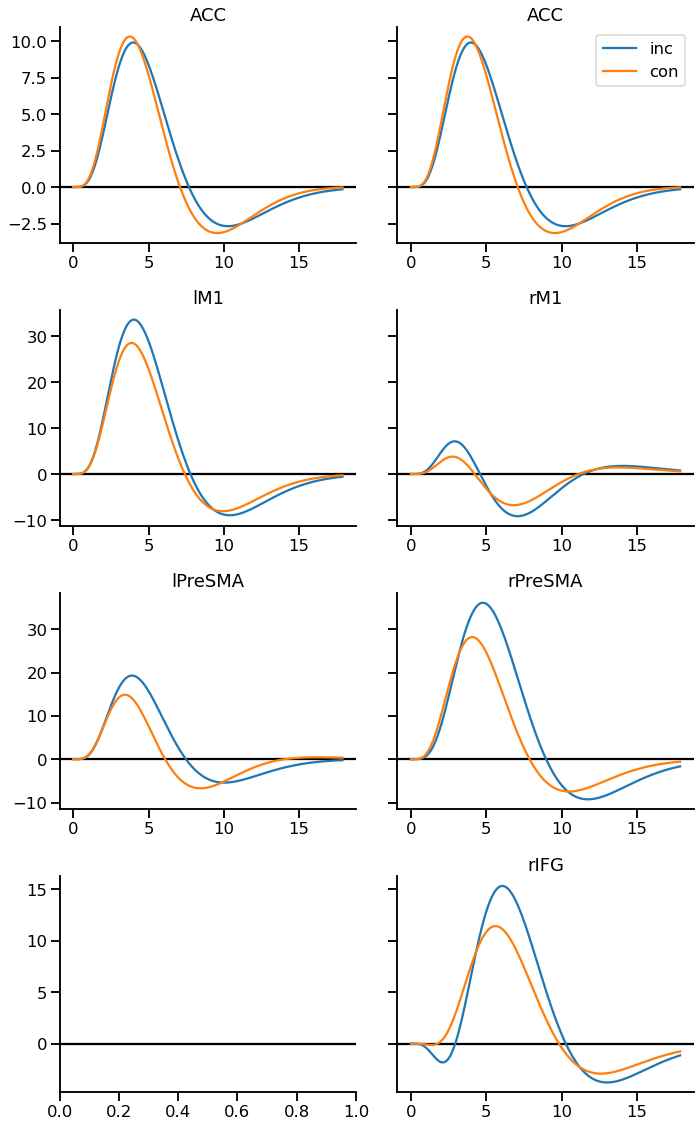

In [43]:
sns.set_context('talk')

plot_rois = ['STN', 'Tha', 'RN', 'VTA', 'SN', 'GPi', 'GPe', 'Str', 'PAG', 'PPN', 'ic', 'fx']
plot_rois = ['ACC', 'M1', 'PreSMA', 'IFG']
f, ax = plt.subplots(len(plot_rois),2, figsize=(10,4*len(plot_rois)), sharey='row')

# ax[0].axhline(0, color='k')
# ax[1].axhline(0, color='k')

# for i, roi in enumerate(plot_rois):
#     for ii, hemi in enumerate(['l', 'r']):
#         this_roi = roi + '-' + hemi
#         ax[i,ii].axhline(0, color='k')
#         for contrast in ['con', 'simon', 'flanker','inc']:
# #             if contrast == 'fs':
# #                 tc_fs = tc.loc[(tc['event type'] == 'fs')]
#             tc_subs = tc.loc[(tc['event type'] == contrast)] # & (tc['covariate'] == 'covariate')]        
#             group_mean = tc_subs.loc[tc_subs['roi'] == this_roi].groupby(['time'])['signal'].mean()
# #             sns.lineplot(x='time', y='signal', data=tc_subs, ax=ax[i,ii], label=contrast)
#             ax[i,ii].plot(group_mean, label=contrast)
#             ax[i,ii].set_title(this_roi)
        
for i, roi in enumerate(plot_rois):
    for ii, hemi in enumerate(['l', 'r']):
        this_roi = hemi + roi
        ax[i,ii].axhline(0, color='k')
        if this_roi not in tc.roi.unique() and not roi == 'ACC':
            continue
        if roi == 'ACC':
            this_roi = 'ACC'
        for contrast in ['inc', 'con']:
            tc_subs = tc.loc[(tc['event type'] == contrast)] # & (tc['covariate'] == 'covariate')]
            group_mean = tc_subs.loc[tc_subs['roi'] == this_roi].groupby(['time'])['signal'].mean()
            ax[i,ii].plot(group_mean, label=contrast)
            ax[i,ii].set_title(this_roi)

# ax[1].legend()

# ax[0].set_title('STN L')
# ax[1].set_title('STN R')
ax[0,1].legend()
plt.tight_layout()
sns.despine()


In [40]:
tc

subject event type  covariate    time   roi    signal hemisphere  \
0            1        con  intercept   0.000   ACC  0.000001         lr   
1            1        con  intercept   0.069   ACC  0.000031         lr   
2            1        con  intercept   0.138   ACC  0.000214         lr   
3            1        con  intercept   0.207   ACC  0.000866         lr   
4            1        con  intercept   0.276   ACC  0.002539         lr   
...        ...        ...        ...     ...   ...       ...        ...   
777915       9      simon  intercept  17.595  rVTA -1.141840         lr   
777916       9      simon  intercept  17.664  rVTA -1.099456         lr   
777917       9      simon  intercept  17.733  rVTA -1.058447         lr   
777918       9      simon  intercept  17.802  rVTA -1.018777         lr   
777919       9      simon  intercept  17.871  rVTA -0.980413         lr   

       roi_nohemi  
0             ACC  
1             ACC  
2             ACC  
3             ACC  
4             ACC  
...           ...  
777915       rVTA  
777916       rVTA  
777917       rVTA  
777918       rVTA  
777919       rVTA  

[777920 rows x 8 columns]

In [673]:
for i in sorted(glob.glob('/home/Public/trondheim/sourcedata/zipdata/sub-*/ses-sstmsit/sub-*_ses-sstmsit_data_tmpunzip/sub-*_ses-sstmsit_data/RESOURCES/task_data/*.tsv')):
    shutil.copy(i,i.replace(os.path.dirname(i), '/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU'))
    print(i.replace(os.path.dirname(i), '/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU'))

/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-002_ses-1_tr-1.4_task-MSIT_20210205-100802_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-002_ses-1_tr-1.4_task-MSIT_20210205-102657_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-002_ses-1_tr-1.4_task-MSIT_20210205-102657_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-002_ses-1_tr-1.4_task-SST_20210205-104229_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-002_ses-1_tr-1.4_task-SST_20210205-104229_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-003_ses-1_tr-1.4_task-MSIT_20210128-101759_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-003_ses-1_tr-1.4_task-MSIT_20210128-103934_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-

/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-014_ses-1_tr-1.4_task-MSIT_20210520-100036_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-014_ses-1_tr-1.4_task-MSIT_20210520-100036_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-014_ses-1_tr-1.4_task-MSIT_20210520-100036_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-014_ses-1_tr-1.4_task-SST_20210520-103218_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-014_ses-1_tr-1.4_task-SST_20210520-103218_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-015_ses-1_tr-1.4_task-MSIT_20210312-075935_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-015_ses-1_tr-1.4_task-MSIT_20210312-081709_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-

/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-027_ses-1_tr-1.4_task-MSIT_20211117-120530_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-027_ses-1_tr-1.4_task-MSIT_20211117-120530_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-027_ses-1_tr-1.4_task-MSIT_20211117-120530_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-027_ses-1_tr-1.4_task-SST_20211117-123648_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-027_ses-1_tr-1.4_task-SST_20211117-123648_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-029_ses-1_tr-1.4_task-MSIT_20210826-100044_block-1_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-029_ses-1_tr-1.4_task-MSIT_20210826-101732_block-2_events.tsv
/home/Public/trondheim/scripts/stopSignal/all_behavioural_data_NTNU/sub-